# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib‚Äôs Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn‚Äôt leverage TensorFlow‚Äôs broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
# pip install jax --upgrade s

## Experimental Parameters

In [ ]:
# e_1
# Fiber lengths
Ls = jnp.linspace(0, 200, 1000)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10**9] #[10 ** s for s in range(4, 11)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = jnp.array(n_X_values)
e_4 = jnp.log(N)

## Other Parameters

In [5]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [6]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [7]:
from QKD_Functions.QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [ ]:
# Initialize dataset storage
categorized_dataset = {n_X: [] for n_X in n_X_values}

# Initial guess and bounds
initial_guess = np.array([0.52, 0.40, 0.18, 0.785, 0.88])

    # 0.65, 0.15, 0.05, 0.61, 0.425 for 1e4
    # 0.62, 0.24, 0.10, 0.70, 0.55 for 1e5
    # 0.68, 0.30, 0.14, 0.74, 0.66 for 1e6
    # 0.55, 0.34, 0.15, 0.75, 0.75 for 1e7 
    # 0.54, 0.375, 0.16, 0.775, 0.83 for 1e8
    # 0.52, 0.40, 0.18, 0.785, 0.88 for 1e9

bounds = [
    (4e-4, 0.9),  
    (2e-4, 0.5),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
]

# Define L values
L_values = np.linspace(0, 200, 1000)
n_X_values = [1e9] # np.logspace(4, 9, 6)  # Logarithmically spaced values from 10^4 to 10^9

In [9]:
import numpy as np
from scipy.optimize import dual_annealing, minimize
from tqdm import tqdm
import concurrent.futures
import logging
import json
import time

In [10]:
# Global variables
x0 = initial_guess.copy()  # Store the last used initial guess
last_valid_x0 = initial_guess.copy()  # Store the last valid parameters

In [ ]:
# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def optimize_single_instance(L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    """Optimize key rate for a given fiber length L and fixed n_X."""
    global x0, last_valid_x0
    print(f"\n--- [DEBUG] Starting optimization for L={L} km ---")

    try:
        def wrapped_objective(params):
            key_rate = objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
            return  -key_rate

        print(f"üîµ Initial Guess for L={L}: {x0}")

        # Global optimization
        # Perform global optimization
        global_result = dual_annealing(
            func=wrapped_objective,
            bounds=bounds,

            x0=x0
        )
        # Local refinement
        local_result = minimize(
            fun=wrapped_objective,
            x0=global_result.x,
            method='Nelder-Mead',
            options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
        )

        optimized_params = local_result.x
        optimized_params = np.clip(optimized_params,  
                           [b[0] for b in bounds], 
                           [b[1] for b in bounds])
        optimized_key_rate = -local_result.fun

        print(f"‚úÖ Final Optimized Parameters for L={L} km: {optimized_params}")
        print(f"‚úÖ Final Optimized Key Rate for L={L} km: {optimized_key_rate}")

        # Update x0 with the latest optimized parameters
        x0 = optimized_params.copy()

        # Check if parameters are within bounds
        out_of_bounds_flags = [param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds)]
        out_of_bounds = any(out_of_bounds_flags)  

        if not out_of_bounds:
            return L, n_X, optimized_key_rate, optimized_params, optimized_params.copy()  
        else:
            print(f"‚ö†Ô∏è Parameters out of bounds for L={L} km, but keeping best parameters seen so far.")
            return L, n_X, optimized_key_rate, optimized_params, x0  

    except Exception as e:
        print(f"‚ùå Error at L={L}: {e}")
        return L, n_X, float('nan'), [float('nan')] * len(bounds), x0
    
def submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, batch_size=16 ):
    all_results = []
    tasks = [(L, n_X) for L in L_values for n_X in n_X_values]
    total = len(tasks)
    with tqdm(total=total, desc="Optimizing") as pbar:
        for i in range(0, total, batch_size):
            batch = tasks[i:i + batch_size]
            futures = [executor.submit(optimize_single_instance, L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event) for L, n_X in batch]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    return all_results

if __name__ == '__main__':
    # Define constants and bounds
    bounds = [(4e-4, 0.9), (2e-4, 0.5), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12)]
    initial_guess = np.array([0.52, 0.40, 0.18, 0.785, 0.88])
    # 0.65, 0.15, 0.05, 0.61, 0.425 for 1e4
# 0.62, 0.24, 0.10, 0.70, 0.55 for 1e5
    # 0.68, 0.30, 0.14, 0.74, 0.66 for 1e6
    # 0.55, 0.34, 0.15, 0.75, 0.75 for 1e7 
    # 0.54, 0.375, 0.16, 0.775, 0.83 for 1e8
    # 0.52, 0.40, 0.18, 0.785, 0.88 for 1e9

    L_values = np.linspace(0, 200, 1000)
    n_X_values = [1e9] # Detected events

    # Optimization parameters
    alpha = 0.2
    eta_Bob = 0.1
    P_dc_value = 6*10**-7
    epsilon_sec = 1e-10
    epsilon_cor = 1e-15
    f_EC = 1.16
    e_mis = 0.01
    P_ap = 0
    n_event = 1

    # Run optimization using ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        all_results_sorted = submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)

    # Generate and save dataset
    dataset = [{
        "fiber_length": float(L),
        "n_X": int(n_X),
        "key_rate": float(key_rate),
        "optimized_parameters": { "mu_1": float(params[0]), "mu_2": float(params[1]), "P_mu_1": float(params[2]), "P_mu_2": float(params[3]), "P_X_value": float(params[4]) },
        "initial_guess": { "mu_1": float(init_guess[0]), "mu_2": float(init_guess[1]), "P_mu_1": float(init_guess[2]), "P_mu_2": float(init_guess[3]), "P_X_value": float(init_guess[4]) }
    } for L, n_X, key_rate, params, init_guess in all_results_sorted]

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f'qkd_optimization_results_{timestamp}.json'
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=2)

    # Print dataset summary
    print("\nDataset Summary:")
    print(f"Total Entries: {len(dataset)}")
    print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
    print(f"n_X Values: {', '.join(map(str, n_X_values))}")

Optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]


--- [DEBUG] Starting optimization for L=0.0 km ---
--- [DEBUG] Starting optimization for L=0.2002002002002002 km ---
üîµ Initial Guess for L=0.2002002002002002: [0.65  0.15  0.05  0.61  0.425]

üîµ Initial Guess for L=0.0: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting optimization for L=0.4004004004004004 km ---
üîµ Initial Guess for L=0.4004004004004004: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting optimization for L=0.6006006006006006 km ---
üîµ Initial Guess for L=0.6006006006006006: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting optimization for L=0.8008008008008008 km ---
üîµ Initial Guess for L=0.8008008008008008: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting optimization for L=1.001001001001001 km ---
üîµ Initial Guess for L=1.001001001001001: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting optimization for L=1.2012012012012012 km ---
üîµ Initial Guess for L=1.2012012012012012: [0.65  0.15  0.05  0.61  0.425]

--- [DEBUG] Starting op

Optimizing:   0%|          | 2/1000 [01:09<7:56:55, 28.67s/it] 

‚úÖ Final Optimized Parameters for L=0.4004004004004004 km: [0.6120708  0.13806808 0.04602778 0.61099552 0.41471943]
‚úÖ Final Optimized Key Rate for L=0.4004004004004004 km: 0.00037268053170772295

--- [DEBUG] Starting optimization for L=2.4024024024024024 km ---
üîµ Initial Guess for L=2.4024024024024024: [0.6120708  0.13806808 0.04602778 0.61099552 0.41471943]
‚úÖ Final Optimized Parameters for L=2.2022022022022023 km: [0.60968578 0.13756271 0.04596379 0.61092503 0.41466559]
‚úÖ Final Optimized Key Rate for L=2.2022022022022023 km: 0.0003416755809353487

--- [DEBUG] Starting optimization for L=2.6026026026026026 km ---
üîµ Initial Guess for L=2.6026026026026026: [0.60968578 0.13756271 0.04596379 0.61092503 0.41466559]


Optimizing:   0%|          | 5/1000 [01:09<1:53:11,  6.83s/it]

‚úÖ Final Optimized Parameters for L=1.8018018018018018 km: [0.61019767 0.13767104 0.0459774  0.61094033 0.41467751]
‚úÖ Final Optimized Key Rate for L=1.8018018018018018 km: 0.00034832627268805485

--- [DEBUG] Starting optimization for L=2.802802802802803 km ---
üîµ Initial Guess for L=2.802802802802803: [0.61019767 0.13767104 0.0459774  0.61094033 0.41467751]
‚úÖ Final Optimized Parameters for L=0.8008008008008008 km: [0.61152233 0.13795172 0.04601294 0.61097952 0.41470742]
‚úÖ Final Optimized Key Rate for L=0.8008008008008008 km: 0.000365546915956034

--- [DEBUG] Starting optimization for L=3.0030030030030033 km ---
üîµ Initial Guess for L=3.0030030030030033: [0.61152233 0.13795172 0.04601294 0.61097952 0.41470742]
‚úÖ Final Optimized Parameters for L=0.6006006006006006 km: [0.61179516 0.1380096  0.04602032 0.6109875  0.41471342]
‚úÖ Final Optimized Key Rate for L=0.6006006006006006 km: 0.0003690958180984481


Optimizing:   1%|          | 8/1000 [01:09<51:20,  3.10s/it]  

‚úÖ Final Optimized Parameters for L=1.4014014014014016 km: [0.6107197  0.1377816  0.04599135 0.61095586 0.41468944]
‚úÖ Final Optimized Key Rate for L=1.4014014014014016 km: 0.0003551112541731818
‚úÖ Final Optimized Parameters for L=1.001001001001001 km: [0.61125216 0.13789443 0.04600565 0.61097158 0.41470142]
‚úÖ Final Optimized Key Rate for L=1.001001001001001 km: 0.0003620334405535909
‚úÖ Final Optimized Parameters for L=1.2012012012012012 km: [0.61098459 0.13783771 0.04599845 0.61096371 0.41469543]
‚úÖ Final Optimized Key Rate for L=1.2012012012012012 km: 0.0003585550117996493
‚úÖ Final Optimized Parameters for L=0.0 km: [0.61263013 0.13818684 0.046043   0.61101174 0.41473149]
‚úÖ Final Optimized Key Rate for L=0.0 km: 0.00037995895580899045


Optimizing:   1%|          | 10/1000 [01:10<34:05,  2.07s/it]

‚úÖ Final Optimized Parameters for L=2.002002002002002 km: [0.60994049 0.1376166  0.04597055 0.61093267 0.41467154]
‚úÖ Final Optimized Key Rate for L=2.002002002002002 km: 0.00034498432006936186
‚úÖ Final Optimized Parameters for L=1.6016016016016017 km: [0.61045743 0.13772603 0.04598433 0.61094812 0.41468348]
‚úÖ Final Optimized Key Rate for L=1.6016016016016017 km: 0.00035170179665962065


Optimizing:   1%|          | 12/1000 [01:10<23:28,  1.43s/it]

‚úÖ Final Optimized Parameters for L=0.2002002002002002 km: [0.61234908 0.13812715 0.04603534 0.61100363 0.41472547]
‚úÖ Final Optimized Key Rate for L=0.2002002002002002 km: 0.00037630144621220586


Optimizing:   1%|‚ñè         | 14/1000 [01:25<55:03,  3.35s/it]

‚úÖ Final Optimized Parameters for L=2.4024024024024024 km: [0.60943366 0.1375094  0.04595712 0.61091744 0.41465962]
‚úÖ Final Optimized Key Rate for L=2.4024024024024024 km: 0.0003383997016789853
‚úÖ Final Optimized Parameters for L=3.0030030030030033 km: [0.60869189 0.13735265 0.04593759 0.61089492 0.41464177]
‚úÖ Final Optimized Key Rate for L=3.0030030030030033 km: 0.0003287657497928313
‚úÖ Final Optimized Parameters for L=2.6026026026026026 km: [0.60918387 0.1374566  0.04595053 0.61090987 0.41465368]
‚úÖ Final Optimized Key Rate for L=2.6026026026026026 km: 0.00033515633289549305
‚úÖ Final Optimized Parameters for L=2.802802802802803 km: [0.60893671 0.13740436 0.04594402 0.61090238 0.41464772]
‚úÖ Final Optimized Key Rate for L=2.802802802802803 km: 0.0003319451293244436

--- [DEBUG] Starting optimization for L=3.2032032032032034 km ---
üîµ Initial Guess for L=3.2032032032032034: [0.60893671 0.13740436 0.04594402 0.61090238 0.41464772]

--- [DEBUG] Starting optimization for L=3.4

Optimizing:   2%|‚ñè         | 17/1000 [02:32<3:00:52, 11.04s/it]

‚úÖ Final Optimized Parameters for L=4.804804804804805 km: [0.60659315 0.1369103  0.04588335 0.61082967 0.41458827]
‚úÖ Final Optimized Key Rate for L=4.804804804804805 km: 0.0003015290748820461

--- [DEBUG] Starting optimization for L=5.605605605605606 km ---
üîµ Initial Guess for L=5.605605605605606: [0.60659315 0.1369103  0.04588335 0.61082967 0.41458827]


Optimizing:   2%|‚ñè         | 18/1000 [02:32<2:32:25,  9.31s/it]

‚úÖ Final Optimized Parameters for L=5.405405405405406 km: [0.60593374 0.13677171 0.04586664 0.61080864 0.4145704 ]
‚úÖ Final Optimized Key Rate for L=5.405405405405406 km: 0.0002929766250300465

--- [DEBUG] Starting optimization for L=5.805805805805806 km ---
üîµ Initial Guess for L=5.805805805805806: [0.60593374 0.13677171 0.04586664 0.61080864 0.4145704 ]
‚úÖ Final Optimized Parameters for L=5.205205205205205 km: [0.60615141 0.13681743 0.04587213 0.61081565 0.41457637]
‚úÖ Final Optimized Key Rate for L=5.205205205205205 km: 0.00029579931364767203

--- [DEBUG] Starting optimization for L=6.0060060060060065 km ---
üîµ Initial Guess for L=6.0060060060060065: [0.60615141 0.13681743 0.04587213 0.61081565 0.41457637]
‚úÖ Final Optimized Parameters for L=5.005005005005005 km: [0.60637124 0.13686363 0.04587769 0.61082264 0.41458233]
‚úÖ Final Optimized Key Rate for L=5.005005005005005 km: 0.0002986500315152232

--- [DEBUG] Starting optimization for L=6.206206206206207 km ---
üîµ Initial

Optimizing:   2%|‚ñè         | 24/1000 [02:32<57:11,  3.52s/it]  

‚úÖ Final Optimized Parameters for L=4.2042042042042045 km: [0.60727224 0.13705324 0.04590073 0.61085106 0.41460612]
‚úÖ Final Optimized Key Rate for L=4.2042042042042045 km: 0.00031033917281715536
‚úÖ Final Optimized Parameters for L=3.4034034034034035 km: [0.60820929 0.13725079 0.04592499 0.61088012 0.41462989]
‚úÖ Final Optimized Key Rate for L=3.4034034034034035 km: 0.0003225011182573765
‚úÖ Final Optimized Parameters for L=3.2032032032032034 km: [0.60844939 0.13730145 0.04593125 0.61088751 0.41463583]
‚úÖ Final Optimized Key Rate for L=3.2032032032032034 km: 0.0003256178571589734
‚úÖ Final Optimized Parameters for L=3.8038038038038042 km: [0.60773623 0.137151   0.04591269 0.61086555 0.41461801]
‚úÖ Final Optimized Key Rate for L=3.8038038038038042 km: 0.0003163597885454613


Optimizing:   3%|‚ñé         | 26/1000 [02:33<42:39,  2.63s/it]

‚úÖ Final Optimized Parameters for L=4.004004004004004 km: [0.6075031  0.13710187 0.04590668 0.61085827 0.41461206]
‚úÖ Final Optimized Key Rate for L=4.004004004004004 km: 0.00031333455080121526
‚úÖ Final Optimized Parameters for L=4.404404404404405 km: [0.60704366 0.1370051  0.04589486 0.6108439  0.41460018]
‚úÖ Final Optimized Key Rate for L=4.404404404404405 km: 0.0003073733405121219
‚úÖ Final Optimized Parameters for L=3.6036036036036037 km: [0.60797156 0.13720063 0.04591881 0.61087278 0.41462396]
‚úÖ Final Optimized Key Rate for L=3.6036036036036037 km: 0.0003194152038445351
‚úÖ Final Optimized Parameters for L=4.604604604604605 km: [0.60681734 0.13695747 0.04588907 0.61083676 0.41459423]
‚úÖ Final Optimized Key Rate for L=4.604604604604605 km: 0.0003044367434683193


Optimizing:   3%|‚ñé         | 29/1000 [02:47<55:01,  3.40s/it]

‚úÖ Final Optimized Parameters for L=5.805805805805806 km: [0.60550478 0.13668167 0.04585586 0.61079482 0.41455848]
‚úÖ Final Optimized Key Rate for L=5.805805805805806 km: 0.00028741416762505294
‚úÖ Final Optimized Parameters for L=5.605605605605606 km: [0.60571821 0.13672646 0.04586121 0.61080173 0.41456444]
‚úÖ Final Optimized Key Rate for L=5.605605605605606 km: 0.00029018167283768897
‚úÖ Final Optimized Parameters for L=6.0060060060060065 km: [0.6052934  0.13663734 0.04585058 0.61078795 0.4145525 ]
‚úÖ Final Optimized Key Rate for L=6.0060060060060065 km: 0.0002846738232808676
‚úÖ Final Optimized Parameters for L=6.206206206206207 km: [0.60508409 0.13659346 0.04584538 0.61078112 0.41454651]
‚úÖ Final Optimized Key Rate for L=6.206206206206207 km: 0.0002819603569840516

--- [DEBUG] Starting optimization for L=6.406406406406407 km ---
üîµ Initial Guess for L=6.406406406406407: [0.60508409 0.13659346 0.04584538 0.61078112 0.41454651]

--- [DEBUG] Starting optimization for L=6.606606

Optimizing:   4%|‚ñé         | 35/1000 [03:53<1:48:46,  6.76s/it]

‚úÖ Final Optimized Parameters for L=8.208208208208209 km: [0.60309959 0.13617877 0.04579707 0.6107146  0.41448615]
‚úÖ Final Optimized Key Rate for L=8.208208208208209 km: 0.0002562440334818412

--- [DEBUG] Starting optimization for L=8.80880880880881 km ---
üîµ Initial Guess for L=8.80880880880881: [0.60309959 0.13617877 0.04579707 0.6107146  0.41448615]
‚úÖ Final Optimized Parameters for L=8.408408408408409 km: [0.60291153 0.13613961 0.04579261 0.61070811 0.41448006]
‚úÖ Final Optimized Key Rate for L=8.408408408408409 km: 0.0002538084583370298

--- [DEBUG] Starting optimization for L=9.00900900900901 km ---
üîµ Initial Guess for L=9.00900900900901: [0.60291153 0.13613961 0.04579261 0.61070811 0.41448006]
‚úÖ Final Optimized Parameters for L=6.406406406406407 km: [0.6048768  0.13655004 0.04584024 0.61077431 0.41454052]
‚úÖ Final Optimized Key Rate for L=6.406406406406407 km: 0.0002792734891602718

--- [DEBUG] Starting optimization for L=9.20920920920921 km ---
üîµ Initial Guess f

Optimizing:   4%|‚ñç         | 38/1000 [03:53<1:13:32,  4.59s/it]

‚úÖ Final Optimized Parameters for L=8.008008008008009 km: [0.6032895  0.13621833 0.04580159 0.61072112 0.41449224]
‚úÖ Final Optimized Key Rate for L=8.008008008008009 km: 0.0002587035808366983

--- [DEBUG] Starting optimization for L=9.40940940940941 km ---
üîµ Initial Guess for L=9.40940940940941: [0.6032895  0.13621833 0.04580159 0.61072112 0.41449224]
‚úÖ Final Optimized Parameters for L=6.606606606606607 km: [0.60467158 0.13650705 0.04583517 0.61076757 0.41453451]
‚úÖ Final Optimized Key Rate for L=6.606606606606607 km: 0.0002766129434392061
‚úÖ Final Optimized Parameters for L=8.608608608608609 km: [0.60272538 0.13610086 0.0457882  0.61070166 0.41447395]
‚úÖ Final Optimized Key Rate for L=8.608608608608609 km: 0.00025139660885919996


Optimizing:   4%|‚ñç         | 40/1000 [03:53<56:15,  3.52s/it]  

‚úÖ Final Optimized Parameters for L=7.007007007007007 km: [0.60426695 0.13642241 0.04582525 0.61075413 0.41452248]
‚úÖ Final Optimized Key Rate for L=7.007007007007007 km: 0.0002713697285916187
‚úÖ Final Optimized Parameters for L=7.6076076076076085 km: [0.60367472 0.13629868 0.04581086 0.61073423 0.41450438]
‚úÖ Final Optimized Key Rate for L=7.6076076076076085 km: 0.00026369559243932437
‚úÖ Final Optimized Parameters for L=6.806806806806807 km: [0.60446828 0.13646452 0.04583017 0.61076085 0.41452851]
‚úÖ Final Optimized Key Rate for L=6.806806806806807 km: 0.0002739784466123257


Optimizing:   4%|‚ñç         | 42/1000 [03:54<42:28,  2.66s/it]

‚úÖ Final Optimized Parameters for L=7.207207207207207 km: [0.60406769 0.13638075 0.04582037 0.61074749 0.41451645]
‚úÖ Final Optimized Key Rate for L=7.207207207207207 km: 0.00026878652236860966
‚úÖ Final Optimized Parameters for L=7.407407407407407 km: [0.6038702  0.13633951 0.04581558 0.61074081 0.41451041]
‚úÖ Final Optimized Key Rate for L=7.407407407407407 km: 0.0002662285639742612
‚úÖ Final Optimized Parameters for L=7.807807807807809 km: [0.60348118 0.13625831 0.04580619 0.61072767 0.41449832]
‚úÖ Final Optimized Key Rate for L=7.807807807807809 km: 0.0002611873497554454


Optimizing:   4%|‚ñç         | 45/1000 [04:08<53:30,  3.36s/it]

‚úÖ Final Optimized Parameters for L=8.80880880880881 km: [0.602541   0.13606251 0.04578386 0.61069522 0.41446785]
‚úÖ Final Optimized Key Rate for L=8.80880880880881 km: 0.0002490082412799249
‚úÖ Final Optimized Parameters for L=9.20920920920921 km: [0.60217755 0.13598702 0.04577539 0.61068241 0.41445553]
‚úÖ Final Optimized Key Rate for L=9.20920920920921 km: 0.0002443009904035833
‚úÖ Final Optimized Parameters for L=9.40940940940941 km: [0.60199843 0.13594984 0.04577125 0.61067607 0.41444937]
‚úÖ Final Optimized Key Rate for L=9.40940940940941 km: 0.00024198163312533615
‚úÖ Final Optimized Parameters for L=9.00900900900901 km: [0.60235837 0.13602455 0.04577958 0.61068883 0.4144617 ]
‚úÖ Final Optimized Key Rate for L=9.00900900900901 km: 0.000246643114569834

--- [DEBUG] Starting optimization for L=9.60960960960961 km ---
üîµ Initial Guess for L=9.60960960960961: [0.60235837 0.13602455 0.04577958 0.61068883 0.4144617 ]

--- [DEBUG] Starting optimization for L=9.80980980980981 km --

Optimizing:   5%|‚ñå         | 50/1000 [05:13<1:58:31,  7.49s/it]

‚úÖ Final Optimized Parameters for L=11.211211211211213 km: [0.60046248 0.1356323  0.04573663 0.61061996 0.41439304]
‚úÖ Final Optimized Key Rate for L=11.211211211211213 km: 0.00022209432285647405

--- [DEBUG] Starting optimization for L=12.012012012012013 km ---
üîµ Initial Guess for L=12.012012012012013: [0.60046248 0.1356323  0.04573663 0.61061996 0.41439304]
‚úÖ Final Optimized Parameters for L=11.411411411411413 km: [0.60030002 0.13559884 0.04573307 0.61061389 0.4143867 ]
‚úÖ Final Optimized Key Rate for L=11.411411411411413 km: 0.00021999023699860077

--- [DEBUG] Starting optimization for L=12.212212212212213 km ---
üîµ Initial Guess for L=12.212212212212213: [0.60030002 0.13559884 0.04573307 0.61061389 0.4143867 ]


Optimizing:   5%|‚ñå         | 52/1000 [05:13<1:27:21,  5.53s/it]

‚úÖ Final Optimized Parameters for L=11.811811811811813 km: [0.59997967 0.13553298 0.04572615 0.61060167 0.41437391]
‚úÖ Final Optimized Key Rate for L=11.811811811811813 km: 0.00021584288360385528

--- [DEBUG] Starting optimization for L=12.412412412412413 km ---
üîµ Initial Guess for L=12.412412412412413: [0.59997967 0.13553298 0.04572615 0.61060167 0.41437391]
‚úÖ Final Optimized Parameters for L=11.611611611611613 km: [0.60013909 0.13556574 0.04572959 0.61060777 0.41438029]
‚úÖ Final Optimized Key Rate for L=11.611611611611613 km: 0.00021790649262631062

--- [DEBUG] Starting optimization for L=12.612612612612613 km ---
üîµ Initial Guess for L=12.612612612612613: [0.60013909 0.13556574 0.04572959 0.61060777 0.41438029]
‚úÖ Final Optimized Parameters for L=9.80980980980981 km: [0.60164539 0.13587666 0.04576313 0.61066346 0.41443697]
‚úÖ Final Optimized Key Rate for L=9.80980980980981 km: 0.0002374102897534152
‚úÖ Final Optimized Parameters for L=10.21021021021021 km: [0.6012992  0.

Optimizing:   6%|‚ñå         | 59/1000 [05:13<33:16,  2.12s/it]  

‚úÖ Final Optimized Parameters for L=10.41041041041041 km: [0.60112859 0.13576972 0.04575141 0.6106447  0.41441826]
‚úÖ Final Optimized Key Rate for L=10.41041041041041 km: 0.00023071828472188302
‚úÖ Final Optimized Parameters for L=9.60960960960961 km: [0.60182101 0.13591306 0.04576715 0.61066977 0.41444319]
‚úÖ Final Optimized Key Rate for L=9.60960960960961 km: 0.00023968480971472695
‚úÖ Final Optimized Parameters for L=10.61061061061061 km: [0.60095965 0.13573483 0.04574762 0.61063851 0.414412  ]
‚úÖ Final Optimized Key Rate for L=10.61061061061061 km: 0.00022853072526912718
‚úÖ Final Optimized Parameters for L=10.01001001001001 km: [0.6014715  0.13584065 0.04575916 0.61065718 0.41443076]
‚úÖ Final Optimized Key Rate for L=10.01001001001001 km: 0.00023515784539200713
‚úÖ Final Optimized Parameters for L=10.810810810810812 km: [0.60079234 0.13570029 0.0457439  0.61063231 0.41440571]
‚úÖ Final Optimized Key Rate for L=10.810810810810812 km: 0.0002263643550655909
‚úÖ Final Optimized P

Optimizing:   6%|‚ñå         | 61/1000 [05:27<50:16,  3.21s/it]

‚úÖ Final Optimized Parameters for L=12.012012012012013 km: [0.59982181 0.13550058 0.04572277 0.6105956  0.41436747]
‚úÖ Final Optimized Key Rate for L=12.012012012012013 km: 0.0002137992060599534
‚úÖ Final Optimized Parameters for L=12.412412412412413 km: [0.59951072 0.13543676 0.04571617 0.61058356 0.41435456]
‚úÖ Final Optimized Key Rate for L=12.412412412412413 km: 0.0002097708410771033
‚úÖ Final Optimized Parameters for L=12.612612612612613 km: [0.5993573  0.13540536 0.04571296 0.61057752 0.41434806]
‚úÖ Final Optimized Key Rate for L=12.612612612612613 km: 0.00020778575696735207
‚úÖ Final Optimized Parameters for L=12.212212212212213 km: [0.59966547 0.13546849 0.04571944 0.61058958 0.41436104]
‚úÖ Final Optimized Key Rate for L=12.212212212212213 km: 0.0002117752583597498

--- [DEBUG] Starting optimization for L=12.812812812812814 km ---
üîµ Initial Guess for L=12.812812812812814: [0.59966547 0.13546849 0.04571944 0.61058958 0.41436104]

--- [DEBUG] Starting optimization for L=1

Optimizing:   7%|‚ñã         | 66/1000 [06:35<1:57:07,  7.52s/it]

‚úÖ Final Optimized Parameters for L=14.414414414414415 km: [0.59804215 0.13513746 0.0456865  0.6105241  0.41428837]
‚úÖ Final Optimized Key Rate for L=14.414414414414415 km: 0.0001907584932769584

--- [DEBUG] Starting optimization for L=15.215215215215217 km ---
üîµ Initial Guess for L=15.215215215215217: [0.59804215 0.13513746 0.0456865  0.6105241  0.41428837]
‚úÖ Final Optimized Parameters for L=14.814814814814815 km: [0.59776522 0.13508138 0.04568118 0.61051238 0.41427478]
‚úÖ Final Optimized Key Rate for L=14.814814814814815 km: 0.00018717151402203381

--- [DEBUG] Starting optimization for L=15.415415415415417 km ---
üîµ Initial Guess for L=15.415415415415417: [0.59776522 0.13508138 0.04568118 0.61051238 0.41427478]


Optimizing:   7%|‚ñã         | 71/1000 [06:35<55:51,  3.61s/it]  

‚úÖ Final Optimized Parameters for L=15.015015015015017 km: [0.59762874 0.1350538  0.04567861 0.61050658 0.41426795]
‚úÖ Final Optimized Key Rate for L=15.015015015015017 km: 0.00018540380139461064

--- [DEBUG] Starting optimization for L=15.615615615615617 km ---
üîµ Initial Guess for L=15.615615615615617: [0.59762874 0.1350538  0.04567861 0.61050658 0.41426795]
‚úÖ Final Optimized Parameters for L=12.812812812812814 km: [0.59920554 0.13537431 0.0457098  0.61057154 0.41434154]
‚úÖ Final Optimized Key Rate for L=12.812812812812814 km: 0.0002058198109404432

--- [DEBUG] Starting optimization for L=15.815815815815817 km ---
üîµ Initial Guess for L=15.815815815815817: [0.59920554 0.13537431 0.0457098  0.61057154 0.41434154]
‚úÖ Final Optimized Parameters for L=13.813813813813814 km: [0.59846794 0.13522389 0.04569483 0.6105418  0.41430853]
‚úÖ Final Optimized Key Rate for L=13.813813813813814 km: 0.0001962704714109826
‚úÖ Final Optimized Parameters for L=13.213213213213214 km: [0.5989062

Optimizing:   8%|‚ñä         | 75/1000 [06:35<31:09,  2.02s/it]

‚úÖ Final Optimized Parameters for L=13.013013013013014 km: [0.59905509 0.13534358 0.04570671 0.61056553 0.41433499]
‚úÖ Final Optimized Key Rate for L=13.013013013013014 km: 0.0002038728100343874
‚úÖ Final Optimized Parameters for L=14.214214214214214 km: [0.59818276 0.13516596 0.04568921 0.61053004 0.41429512]
‚úÖ Final Optimized Key Rate for L=14.214214214214214 km: 0.00019257810790324683
‚úÖ Final Optimized Parameters for L=14.014014014014014 km: [0.59832463 0.13519478 0.045692   0.61053589 0.41430184]
‚úÖ Final Optimized Key Rate for L=14.014014014014014 km: 0.0001944153743558907
‚úÖ Final Optimized Parameters for L=14.614614614614615 km: [0.59790303 0.13510927 0.04568381 0.61051829 0.4142816 ]
‚úÖ Final Optimized Key Rate for L=14.614614614614615 km: 0.000188956353630183
‚úÖ Final Optimized Parameters for L=13.613613613613614 km: [0.59861263 0.13525334 0.04569773 0.61054767 0.41431521]
‚úÖ Final Optimized Key Rate for L=13.613613613613614 km: 0.00019814357979745057


Optimizing:   8%|‚ñä         | 77/1000 [06:53<58:45,  3.82s/it]

‚úÖ Final Optimized Parameters for L=15.615615615615617 km: [0.59722701 0.13497283 0.0456712  0.61048907 0.41424722]
‚úÖ Final Optimized Key Rate for L=15.615615615615617 km: 0.0001802017225881645
‚úÖ Final Optimized Parameters for L=15.815815815815817 km: [0.59709577 0.13494643 0.04566883 0.61048334 0.41424022]
‚úÖ Final Optimized Key Rate for L=15.815815815815817 km: 0.00017850082417706386
‚úÖ Final Optimized Parameters for L=15.415415415415417 km: [0.59735964 0.13499953 0.04567362 0.61049492 0.41425417]
‚úÖ Final Optimized Key Rate for L=15.415415415415417 km: 0.00018191907412938541
‚úÖ Final Optimized Parameters for L=15.215215215215217 km: [0.59749351 0.13502649 0.04567608 0.61050073 0.41426109]
‚úÖ Final Optimized Key Rate for L=15.215215215215217 km: 0.00018365304455028234

--- [DEBUG] Starting optimization for L=16.016016016016017 km ---
üîµ Initial Guess for L=16.016016016016017: [0.59749351 0.13502649 0.04567608 0.61050073 0.41426109]

--- [DEBUG] Starting optimization for L

Optimizing:   8%|‚ñä         | 81/1000 [08:05<2:35:07, 10.13s/it]

‚úÖ Final Optimized Parameters for L=18.21821821821822 km: [0.59561509 0.13465148 0.04564423 0.6104142  0.41415366]
‚úÖ Final Optimized Key Rate for L=18.21821821821822 km: 0.00015931541231967543

--- [DEBUG] Starting optimization for L=18.41841841841842 km ---
üîµ Initial Guess for L=18.41841841841842: [0.59561509 0.13465148 0.04564423 0.6104142  0.41415366]


Optimizing:   8%|‚ñä         | 84/1000 [08:06<1:37:25,  6.38s/it]

‚úÖ Final Optimized Parameters for L=18.01801801801802 km: [0.59573204 0.13467456 0.045646   0.61041995 0.4141611 ]
‚úÖ Final Optimized Key Rate for L=18.01801801801802 km: 0.0001608311769409629

--- [DEBUG] Starting optimization for L=18.61861861861862 km ---
üîµ Initial Guess for L=18.61861861861862: [0.59573204 0.13467456 0.045646   0.61041995 0.4141611 ]
‚úÖ Final Optimized Parameters for L=16.616616616616618 km: [0.59658288 0.13484369 0.04565986 0.61046017 0.41421199]
‚úÖ Final Optimized Key Rate for L=16.616616616616618 km: 0.0001718585084474974

--- [DEBUG] Starting optimization for L=18.81881881881882 km ---
üîµ Initial Guess for L=18.81881881881882: [0.59658288 0.13484369 0.04565986 0.61046017 0.41421199]
‚úÖ Final Optimized Parameters for L=16.416416416416418 km: [0.59670934 0.13486896 0.04566201 0.61046595 0.41421912]
‚úÖ Final Optimized Key Rate for L=16.416416416416418 km: 0.00017349521669383266

--- [DEBUG] Starting optimization for L=19.01901901901902 km ---
üîµ Initi

Optimizing:   9%|‚ñâ         | 88/1000 [08:06<54:07,  3.56s/it]  

‚úÖ Final Optimized Parameters for L=16.216216216216218 km: [0.59683688 0.13489449 0.04566424 0.61047174 0.41422619]
‚úÖ Final Optimized Key Rate for L=16.216216216216218 km: 0.00017514773258970467
‚úÖ Final Optimized Parameters for L=17.81781781781782 km: [0.59585008 0.13469794 0.04564784 0.61042569 0.41416846]
‚úÖ Final Optimized Key Rate for L=17.81781781781782 km: 0.0001623615381295518
‚úÖ Final Optimized Parameters for L=17.61761761761762 km: [0.59596938 0.13472154 0.04564972 0.61043142 0.41417583]
‚úÖ Final Optimized Key Rate for L=17.61761761761762 km: 0.0001639066416952856


Optimizing:   9%|‚ñâ         | 92/1000 [08:06<31:04,  2.05s/it]

‚úÖ Final Optimized Parameters for L=16.016016016016017 km: [0.59696561 0.13492031 0.04566652 0.61047748 0.41423325]
‚úÖ Final Optimized Key Rate for L=16.016016016016017 km: 0.00017681621491931192
‚úÖ Final Optimized Parameters for L=17.217217217217218 km: [0.59621123 0.13476956 0.04565362 0.61044291 0.4141904 ]
‚úÖ Final Optimized Key Rate for L=17.217217217217218 km: 0.0001670416669931704
‚úÖ Final Optimized Parameters for L=17.017017017017018 km: [0.59633399 0.134794   0.04565564 0.61044865 0.41419764]
‚úÖ Final Optimized Key Rate for L=17.017017017017018 km: 0.00016863188819639524
‚úÖ Final Optimized Parameters for L=16.816816816816818 km: [0.59645781 0.13481869 0.04565772 0.61045436 0.41420484]
‚úÖ Final Optimized Key Rate for L=16.816816816816818 km: 0.00017023745075646138


Optimizing:   9%|‚ñâ         | 94/1000 [08:24<54:52,  3.63s/it]  

‚úÖ Final Optimized Parameters for L=18.41841841841842 km: [0.5954993  0.13462865 0.0456425  0.61040854 0.41414614]
‚úÖ Final Optimized Key Rate for L=18.41841841841842 km: 0.0001578140999932002
‚úÖ Final Optimized Parameters for L=19.01901901901902 km: [0.59515857 0.13456171 0.04563756 0.61039129 0.41412349]
‚úÖ Final Optimized Key Rate for L=19.01901901901902 km: 0.00015339545674247955
‚úÖ Final Optimized Parameters for L=18.81881881881882 km: [0.59527095 0.13458376 0.04563915 0.61039708 0.4141311 ]
‚úÖ Final Optimized Key Rate for L=18.81881881881882 km: 0.00015485426271394614
‚úÖ Final Optimized Parameters for L=18.61861861861862 km: [0.59538471 0.13460607 0.04564079 0.6104028  0.41413864]
‚úÖ Final Optimized Key Rate for L=18.61861861861862 km: 0.0001563270972084335

--- [DEBUG] Starting optimization for L=19.21921921921922 km ---
üîµ Initial Guess for L=19.21921921921922: [0.59538471 0.13460607 0.04564079 0.6104028  0.41413864]

--- [DEBUG] Starting optimization for L=19.4194194

Optimizing:  10%|‚ñâ         | 97/1000 [09:37<3:10:46, 12.68s/it]

‚úÖ Final Optimized Parameters for L=20.22022022022022 km: [0.59450614 0.13443459 0.04562893 0.61035704 0.41407686]
‚úÖ Final Optimized Key Rate for L=20.22022022022022 km: 0.00014492957564906262

--- [DEBUG] Starting optimization for L=21.621621621621625 km ---
üîµ Initial Guess for L=21.621621621621625: [0.59450614 0.13443459 0.04562893 0.61035704 0.41407686]


Optimizing:  10%|‚ñà         | 100/1000 [09:37<1:46:08,  7.08s/it]

‚úÖ Final Optimized Parameters for L=19.41941941941942 km: [0.59493683 0.13451835 0.04563451 0.61037988 0.41410812]
‚úÖ Final Optimized Key Rate for L=19.41941941941942 km: 0.0001505193786176479

--- [DEBUG] Starting optimization for L=21.821821821821825 km ---
üîµ Initial Guess for L=21.821821821821825: [0.59493683 0.13451835 0.04563451 0.61037988 0.41410812]
‚úÖ Final Optimized Parameters for L=20.82082082082082 km: [0.59419379 0.13437432 0.04562525 0.61033987 0.41405288]
‚úÖ Final Optimized Key Rate for L=20.82082082082082 km: 0.00014087513784017907

--- [DEBUG] Starting optimization for L=22.022022022022025 km ---
üîµ Initial Guess for L=22.022022022022025: [0.59419379 0.13437432 0.04562525 0.61033987 0.41405288]
‚úÖ Final Optimized Parameters for L=19.81981981981982 km: [0.5947194  0.13447597 0.04563162 0.61036845 0.4140926 ]
‚úÖ Final Optimized Key Rate for L=19.81981981981982 km: 0.00014769777373131284

--- [DEBUG] Starting optimization for L=22.222222222222225 km ---
üîµ Ini

Optimizing:  10%|‚ñà         | 102/1000 [09:37<1:12:34,  4.85s/it]

‚úÖ Final Optimized Parameters for L=20.02002002002002 km: [0.59461229 0.13445519 0.04563025 0.61036273 0.41408475]
‚úÖ Final Optimized Key Rate for L=20.02002002002002 km: 0.00014630706462064952
‚úÖ Final Optimized Parameters for L=21.421421421421424 km: [0.59389052 0.13431617 0.04562196 0.61032266 0.41402844]
‚úÖ Final Optimized Key Rate for L=21.421421421421424 km: 0.00013693508709376924
‚úÖ Final Optimized Parameters for L=21.22122122122122 km: [0.59399059 0.13433532 0.04562302 0.61032836 0.41403667]
‚úÖ Final Optimized Key Rate for L=21.22122122122122 km: 0.0001382359352279079
‚úÖ Final Optimized Parameters for L=20.42042042042042 km: [0.59440084 0.13441427 0.04562768 0.61035126 0.41406891]
‚úÖ Final Optimized Key Rate for L=20.42042042042042 km: 0.0001435651769689412
‚úÖ Final Optimized Parameters for L=19.21921921921922 km: [0.5950471  0.13453991 0.04563601 0.61038562 0.41411581]
‚úÖ Final Optimized Key Rate for L=19.21921921921922 km: 0.00015195054099379203
‚úÖ Final Optimized 

Optimizing:  11%|‚ñà         | 107/1000 [09:38<33:51,  2.28s/it]  

‚úÖ Final Optimized Parameters for L=20.62062062062062 km: [0.59429695 0.13439419 0.04562643 0.61034558 0.41406091]
‚úÖ Final Optimized Key Rate for L=20.62062062062062 km: 0.00014221374008528288
‚úÖ Final Optimized Parameters for L=19.61961961961962 km: [0.59482756 0.13449705 0.04563305 0.61037423 0.41410035]
‚úÖ Final Optimized Key Rate for L=19.61961961961962 km: 0.000149101834196949


Optimizing:  11%|‚ñà         | 109/1000 [09:52<51:12,  3.45s/it]

‚úÖ Final Optimized Parameters for L=21.621621621621625 km: [0.59379132 0.13429725 0.04562095 0.61031695 0.41402019]
‚úÖ Final Optimized Key Rate for L=21.621621621621625 km: 0.00013564657803466718
‚úÖ Final Optimized Parameters for L=21.821821821821825 km: [0.59369306 0.13427855 0.04562    0.61031113 0.4140119 ]
‚úÖ Final Optimized Key Rate for L=21.821821821821825 km: 0.00013437028735274615
‚úÖ Final Optimized Parameters for L=22.222222222222225 km: [0.59349953 0.13424184 0.04561821 0.61029964 0.41399514]
‚úÖ Final Optimized Key Rate for L=22.222222222222225 km: 0.0001318538845563237
‚úÖ Final Optimized Parameters for L=22.022022022022025 km: [0.59359583 0.13426008 0.04561907 0.61030538 0.41400354]
‚úÖ Final Optimized Key Rate for L=22.022022022022025 km: 0.00013310609559843994

--- [DEBUG] Starting optimization for L=22.422422422422425 km ---
üîµ Initial Guess for L=22.422422422422425: [0.59359583 0.13426008 0.04561907 0.61030538 0.41400354]

--- [DEBUG] Starting optimization for L

Optimizing:  11%|‚ñà‚ñè        | 113/1000 [11:04<2:17:22,  9.29s/it]

‚úÖ Final Optimized Parameters for L=24.224224224224226 km: [0.5925862  0.13407139 0.04561188 0.61024156 0.41390778]
‚úÖ Final Optimized Key Rate for L=24.224224224224226 km: 0.00011996556091218362

--- [DEBUG] Starting optimization for L=24.824824824824827 km ---
üîµ Initial Guess for L=24.824824824824827: [0.5925862  0.13407139 0.04561188 0.61024156 0.41390778]
‚úÖ Final Optimized Parameters for L=23.823823823823826 km: [0.59276185 0.13410378 0.04561281 0.61025326 0.41392572]
‚úÖ Final Optimized Key Rate for L=23.823823823823826 km: 0.00012225371238426192

--- [DEBUG] Starting optimization for L=25.025025025025027 km ---
üîµ Initial Guess for L=25.025025025025027: [0.59276185 0.13410378 0.04561281 0.61025326 0.41392572]


Optimizing:  12%|‚ñà‚ñè        | 115/1000 [11:05<1:46:56,  7.25s/it]

‚úÖ Final Optimized Parameters for L=24.624624624624627 km: [0.59241398 0.13403982 0.04561113 0.61022981 0.41388956]
‚úÖ Final Optimized Key Rate for L=24.624624624624627 km: 0.0001177204422343747

--- [DEBUG] Starting optimization for L=25.225225225225227 km ---
üîµ Initial Guess for L=25.225225225225227: [0.59241398 0.13403982 0.04561113 0.61022981 0.41388956]
‚úÖ Final Optimized Parameters for L=24.424424424424426 km: [0.59249966 0.13405552 0.04561149 0.61023566 0.4138987 ]
‚úÖ Final Optimized Key Rate for L=24.424424424424426 km: 0.00011883767483120023

--- [DEBUG] Starting optimization for L=25.425425425425427 km ---
üîµ Initial Guess for L=25.425425425425427: [0.59249966 0.13405552 0.04561149 0.61023566 0.4138987 ]
‚úÖ Final Optimized Parameters for L=23.223223223223226 km: [0.59303171 0.13415393 0.0456145  0.6102707  0.41395221]
‚úÖ Final Optimized Key Rate for L=23.223223223223226 km: 0.00012576848713516985


Optimizing:  12%|‚ñà‚ñè        | 119/1000 [11:05<1:00:40,  4.13s/it]

‚úÖ Final Optimized Parameters for L=22.422422422422425 km: [0.59340413 0.13422382 0.04561737 0.61029387 0.41398667]
‚úÖ Final Optimized Key Rate for L=22.422422422422425 km: 0.0001306135372311565
‚úÖ Final Optimized Parameters for L=22.822822822822825 km: [0.59321612 0.13418843 0.04561585 0.61028233 0.41396954]
‚úÖ Final Optimized Key Rate for L=22.822822822822825 km: 0.00012816797176917557
‚úÖ Final Optimized Parameters for L=23.423423423423426 km: [0.59294081 0.13413698 0.04561389 0.61026489 0.41394345]
‚úÖ Final Optimized Key Rate for L=23.423423423423426 km: 0.00012458574521810034
‚úÖ Final Optimized Parameters for L=23.623623623623626 km: [0.59285083 0.13412026 0.04561333 0.6102591  0.41393464]
‚úÖ Final Optimized Key Rate for L=23.623623623623626 km: 0.00012341418991113567


Optimizing:  12%|‚ñà‚ñè        | 122/1000 [11:05<39:12,  2.68s/it]  

‚úÖ Final Optimized Parameters for L=22.622622622622625 km: [0.59330963 0.13420602 0.04561659 0.6102881  0.41397814]
‚úÖ Final Optimized Key Rate for L=22.622622622622625 km: 0.00012938493783411437
‚úÖ Final Optimized Parameters for L=24.024024024024026 km: [0.59267356 0.13408748 0.04561231 0.61024745 0.41391679]
‚úÖ Final Optimized Key Rate for L=24.024024024024026 km: 0.00012110420492224883
‚úÖ Final Optimized Parameters for L=23.023023023023026 km: [0.59312346 0.13417107 0.04561514 0.61027654 0.41396092]
‚úÖ Final Optimized Key Rate for L=23.023023023023026 km: 0.0001269625256196993


Optimizing:  12%|‚ñà‚ñé        | 125/1000 [11:20<49:56,  3.42s/it]

‚úÖ Final Optimized Parameters for L=25.225225225225227 km: [0.59216171 0.13399402 0.04561036 0.6102121  0.41386177]
‚úÖ Final Optimized Key Rate for L=25.225225225225227 km: 0.00011443163681806985
‚úÖ Final Optimized Parameters for L=25.425425425425427 km: [0.59207921 0.13397914 0.04561019 0.61020617 0.41385237]
‚úÖ Final Optimized Key Rate for L=25.425425425425427 km: 0.00011335599485119473
‚úÖ Final Optimized Parameters for L=24.824824824824827 km: [0.59232896 0.13402434 0.04561084 0.61022395 0.41388036]
‚úÖ Final Optimized Key Rate for L=24.824824824824827 km: 0.00011661375974272278
‚úÖ Final Optimized Parameters for L=25.025025025025027 km: [0.59224496 0.13400909 0.04561058 0.61021801 0.41387107]
‚úÖ Final Optimized Key Rate for L=25.025025025025027 km: 0.00011551752503141457

--- [DEBUG] Starting optimization for L=25.625625625625627 km ---
üîµ Initial Guess for L=25.625625625625627: [0.59224496 0.13400909 0.04561058 0.61021801 0.41387107]

--- [DEBUG] Starting optimization for 

Optimizing:  13%|‚ñà‚ñé        | 130/1000 [12:25<1:48:24,  7.48s/it]

‚úÖ Final Optimized Parameters for L=26.626626626626628 km: [0.59160124 0.13389403 0.04561002 0.61017028 0.41379449]
‚úÖ Final Optimized Key Rate for L=26.626626626626628 km: 0.00010711182720268158

--- [DEBUG] Starting optimization for L=28.02802802802803 km ---
üîµ Initial Guess for L=28.02802802802803: [0.59160124 0.13389403 0.04561002 0.61017028 0.41379449]
‚úÖ Final Optimized Parameters for L=26.026026026026027 km: [0.5918368  0.13393573 0.04560991 0.61018828 0.41382375]
‚úÖ Final Optimized Key Rate for L=26.026026026026027 km: 0.00011018955914086886

--- [DEBUG] Starting optimization for L=28.22822822822823 km ---
üîµ Initial Guess for L=28.22822822822823: [0.5918368  0.13393573 0.04560991 0.61018828 0.41382375]


Optimizing:  13%|‚ñà‚ñé        | 133/1000 [12:26<1:11:06,  4.92s/it]

‚úÖ Final Optimized Parameters for L=27.227227227227228 km: [0.59137262 0.13385406 0.0456105  0.6101521  0.41376458]
‚úÖ Final Optimized Key Rate for L=27.227227227227228 km: 0.00010412025264970849

--- [DEBUG] Starting optimization for L=28.42842842842843 km ---
üîµ Initial Guess for L=28.42842842842843: [0.59137262 0.13385406 0.0456105  0.6101521  0.41376458]
‚úÖ Final Optimized Parameters for L=27.62762762762763 km: [0.5912239  0.13382837 0.04561105 0.61013988 0.41374424]
‚úÖ Final Optimized Key Rate for L=27.62762762762763 km: 0.00010217251203759395

--- [DEBUG] Starting optimization for L=28.62862862862863 km ---
üîµ Initial Guess for L=28.62862862862863: [0.5912239  0.13382837 0.04561105 0.61013988 0.41374424]
‚úÖ Final Optimized Parameters for L=26.826826826826828 km: [0.59152434 0.13388051 0.04561013 0.61016423 0.41378458]
‚úÖ Final Optimized Key Rate for L=26.826826826826828 km: 0.00010610518616319155
‚úÖ Final Optimized Parameters for L=27.42742742742743 km: [0.59129776 0.1

Optimizing:  14%|‚ñà‚ñç        | 139/1000 [12:26<31:35,  2.20s/it]  

‚úÖ Final Optimized Parameters for L=26.226226226226228 km: [0.59175755 0.13392162 0.04560989 0.61018236 0.41381406]
‚úÖ Final Optimized Key Rate for L=26.226226226226228 km: 0.00010915391986852665
‚úÖ Final Optimized Parameters for L=27.027027027027028 km: [0.59144822 0.1338672  0.04561026 0.61015821 0.41377462]
‚úÖ Final Optimized Key Rate for L=27.027027027027028 km: 0.00010510802513512302
‚úÖ Final Optimized Parameters for L=27.82782782782783 km: [0.59115055 0.13381577 0.04561139 0.61013377 0.41373396]
‚úÖ Final Optimized Key Rate for L=27.82782782782783 km: 0.00010121236554928075
‚úÖ Final Optimized Parameters for L=25.825825825825827 km: [0.59191682 0.13394999 0.04560995 0.61019431 0.41383337]
‚úÖ Final Optimized Key Rate for L=25.825825825825827 km: 0.00011123505373760328
‚úÖ Final Optimized Parameters for L=25.625625625625627 km: [0.59199761 0.13396445 0.04561004 0.61020025 0.4138429 ]
‚úÖ Final Optimized Key Rate for L=25.625625625625627 km: 0.00011229049989891318
‚úÖ Final Op

Optimizing:  14%|‚ñà‚ñç        | 141/1000 [12:40<47:24,  3.31s/it]

‚úÖ Final Optimized Parameters for L=28.02802802802803 km: [0.59107796 0.13380343 0.04561177 0.61012755 0.41372354]
‚úÖ Final Optimized Key Rate for L=28.02802802802803 km: 0.00010026125086062841
‚úÖ Final Optimized Parameters for L=28.42842842842843 km: [0.590935   0.13377914 0.04561266 0.61011523 0.41370264]
‚úÖ Final Optimized Key Rate for L=28.42842842842843 km: 9.838576994837883e-05
‚úÖ Final Optimized Parameters for L=28.22822822822823 km: [0.5910062  0.13379118 0.04561217 0.61012143 0.41371318]
‚úÖ Final Optimized Key Rate for L=28.22822822822823 km: 9.931908101963913e-05
‚úÖ Final Optimized Parameters for L=28.62862862862863 km: [0.59086448 0.1337673  0.04561317 0.61010892 0.41369205]
‚úÖ Final Optimized Key Rate for L=28.62862862862863 km: 9.74612324336793e-05

--- [DEBUG] Starting optimization for L=28.82882882882883 km ---
üîµ Initial Guess for L=28.82882882882883: [0.59086448 0.1337673  0.04561317 0.61010892 0.41369205]

--- [DEBUG] Starting optimization for L=29.029029029

Optimizing:  14%|‚ñà‚ñç        | 145/1000 [13:46<2:01:52,  8.55s/it]

‚úÖ Final Optimized Parameters for L=29.62962962962963 km: [0.59052256 0.13371068 0.04561631 0.61007752 0.41363783]
‚úÖ Final Optimized Key Rate for L=29.62962962962963 km: 9.296722510716082e-05

--- [DEBUG] Starting optimization for L=31.231231231231234 km ---
üîµ Initial Guess for L=31.231231231231234: [0.59052256 0.13371068 0.04561631 0.61007752 0.41363783]
‚úÖ Final Optimized Parameters for L=30.630630630630634 km: [0.5901969  0.13365842 0.04562058 0.61004534 0.41358141]
‚úÖ Final Optimized Key Rate for L=30.630630630630634 km: 8.868025587512472e-05

--- [DEBUG] Starting optimization for L=31.431431431431434 km ---
üîµ Initial Guess for L=31.431431431431434: [0.5901969  0.13365842 0.04562058 0.61004534 0.41358141]


Optimizing:  15%|‚ñà‚ñå        | 151/1000 [13:47<58:26,  4.13s/it]  

‚úÖ Final Optimized Parameters for L=29.82982982982983 km: [0.59045599 0.1336999  0.04561709 0.6100711  0.41362672]
‚úÖ Final Optimized Key Rate for L=29.82982982982983 km: 9.209358671415027e-05

--- [DEBUG] Starting optimization for L=31.631631631631635 km ---
üîµ Initial Guess for L=31.631631631631635: [0.59045599 0.1336999  0.04561709 0.6100711  0.41362672]
‚úÖ Final Optimized Parameters for L=29.22922922922923 km: [0.59065742 0.13373281 0.04561491 0.61009022 0.41365976]
‚úÖ Final Optimized Key Rate for L=29.22922922922923 km: 9.473942187189647e-05

--- [DEBUG] Starting optimization for L=31.831831831831835 km ---
üîµ Initial Guess for L=31.831831831831835: [0.59065742 0.13373281 0.04561491 0.61009022 0.41365976]
‚úÖ Final Optimized Parameters for L=30.430430430430434 km: [0.59026069 0.13366852 0.04561963 0.61005184 0.41359289]
‚úÖ Final Optimized Key Rate for L=30.430430430430434 km: 8.952156085647773e-05
‚úÖ Final Optimized Parameters for L=28.82882882882883 km: [0.5907947  0.13

Optimizing:  15%|‚ñà‚ñå        | 154/1000 [13:47<41:42,  2.96s/it]

‚úÖ Final Optimized Parameters for L=30.030030030030034 km: [0.59039032 0.13368927 0.0456179  0.61006471 0.41361552]
‚úÖ Final Optimized Key Rate for L=30.030030030030034 km: 9.12281488258098e-05
‚úÖ Final Optimized Parameters for L=31.031031031031034 km: [0.59007114 0.13363873 0.04562257 0.61003229 0.41355819]
‚úÖ Final Optimized Key Rate for L=31.031031031031034 km: 8.70212424394665e-05
‚úÖ Final Optimized Parameters for L=30.230230230230234 km: [0.59032528 0.13367882 0.04561873 0.61005833 0.41360424]
‚úÖ Final Optimized Key Rate for L=30.230230230230234 km: 9.037083281933813e-05
‚úÖ Final Optimized Parameters for L=29.02902902902903 km: [0.59072567 0.13374412 0.04561429 0.61009642 0.41367063]
‚úÖ Final Optimized Key Rate for L=29.02902902902903 km: 9.563814148866284e-05


Optimizing:  16%|‚ñà‚ñå        | 156/1000 [13:47<32:46,  2.33s/it]

‚úÖ Final Optimized Parameters for L=29.42942942942943 km: [0.59058954 0.13372169 0.04561562 0.61008377 0.41364881]
‚úÖ Final Optimized Key Rate for L=29.42942942942943 km: 9.384914342060806e-05


Optimizing:  16%|‚ñà‚ñå        | 159/1000 [14:03<41:27,  2.96s/it]

‚úÖ Final Optimized Parameters for L=31.231231231231234 km: [0.59000924 0.13362909 0.04562363 0.61002577 0.41354651]
‚úÖ Final Optimized Key Rate for L=31.231231231231234 km: 8.620338366757913e-05
‚úÖ Final Optimized Parameters for L=31.431431431431434 km: [0.58994791 0.13361965 0.04562474 0.61001915 0.41353464]
‚úÖ Final Optimized Key Rate for L=31.431431431431434 km: 8.539319122582891e-05
‚úÖ Final Optimized Parameters for L=31.831831831831835 km: [0.5898271  0.13360129 0.04562708 0.61000585 0.41351068]
‚úÖ Final Optimized Key Rate for L=31.831831831831835 km: 8.379551284571295e-05
‚úÖ Final Optimized Parameters for L=31.631631631631635 km: [0.58988719 0.13361037 0.04562589 0.61001255 0.41352273]
‚úÖ Final Optimized Key Rate for L=31.631631631631635 km: 8.459059181051395e-05

--- [DEBUG] Starting optimization for L=32.032032032032035 km ---
üîµ Initial Guess for L=32.032032032032035: [0.58988719 0.13361037 0.04562589 0.61001255 0.41352273]

--- [DEBUG] Starting optimization for L=32

Optimizing:  16%|‚ñà‚ñã        | 164/1000 [15:14<1:46:20,  7.63s/it]

‚úÖ Final Optimized Parameters for L=32.632632632632635 km: [0.58959257 0.13356641 0.04563228 0.60997895 0.41346164]
‚úÖ Final Optimized Key Rate for L=32.632632632632635 km: 8.06889750206893e-05

--- [DEBUG] Starting optimization for L=34.434434434434436 km ---
üîµ Initial Guess for L=34.434434434434436: [0.58959257 0.13356641 0.04563228 0.60997895 0.41346164]
‚úÖ Final Optimized Parameters for L=32.832832832832835 km: [0.58953534 0.13355812 0.04563371 0.60997206 0.41344908]
‚úÖ Final Optimized Key Rate for L=32.832832832832835 km: 7.993043461122302e-05

--- [DEBUG] Starting optimization for L=34.63463463463464 km ---
üîµ Initial Guess for L=34.63463463463464: [0.58953534 0.13355812 0.04563371 0.60997206 0.41344908]
‚úÖ Final Optimized Parameters for L=34.034034034034036 km: [0.58920414 0.13351157 0.04564308 0.6099304  0.41337178]
‚úÖ Final Optimized Key Rate for L=34.034034034034036 km: 7.552594315293428e-05

--- [DEBUG] Starting optimization for L=34.83483483483484 km ---
üîµ Ini

Optimizing:  17%|‚ñà‚ñã        | 166/1000 [15:14<1:18:14,  5.63s/it]

‚úÖ Final Optimized Parameters for L=33.833833833833836 km: [0.58925781 0.13351896 0.04564145 0.60993732 0.41338494]
‚úÖ Final Optimized Key Rate for L=33.833833833833836 km: 7.624288654102583e-05
‚úÖ Final Optimized Parameters for L=33.633633633633636 km: [0.58931239 0.13352648 0.04563978 0.60994443 0.41339797]
‚úÖ Final Optimized Key Rate for L=33.633633633633636 km: 7.696659794181686e-05
‚úÖ Final Optimized Parameters for L=34.234234234234236 km: [0.58915087 0.13350439 0.04564481 0.60992334 0.41335852]
‚úÖ Final Optimized Key Rate for L=34.234234234234236 km: 7.48157033595133e-05


Optimizing:  17%|‚ñà‚ñã        | 170/1000 [15:15<41:09,  2.97s/it]  

‚úÖ Final Optimized Parameters for L=32.232232232232235 km: [0.58970863 0.13358353 0.0456296  0.60999244 0.41348634]
‚úÖ Final Optimized Key Rate for L=32.232232232232235 km: 8.222762955744664e-05
‚úÖ Final Optimized Parameters for L=33.233233233233236 km: [0.58942277 0.13354199 0.04563665 0.60995833 0.41342376]
‚úÖ Final Optimized Key Rate for L=33.233233233233236 km: 7.843458566549508e-05
‚úÖ Final Optimized Parameters for L=32.032032032032035 km: [0.58976767 0.13359231 0.04562831 0.60999919 0.41349859]
‚úÖ Final Optimized Key Rate for L=32.032032032032035 km: 8.3007882475759e-05


Optimizing:  17%|‚ñà‚ñã        | 172/1000 [15:15<29:48,  2.16s/it]

‚úÖ Final Optimized Parameters for L=33.433433433433436 km: [0.58936725 0.13353413 0.04563818 0.60995144 0.41341091]
‚úÖ Final Optimized Key Rate for L=33.433433433433436 km: 7.769714241435227e-05
‚úÖ Final Optimized Parameters for L=33.033033033033036 km: [0.58947864 0.13354997 0.04563516 0.6099652  0.41343647]
‚úÖ Final Optimized Key Rate for L=33.033033033033036 km: 7.917899405673892e-05


Optimizing:  17%|‚ñà‚ñã        | 173/1000 [15:32<1:05:04,  4.72s/it]

‚úÖ Final Optimized Parameters for L=34.83483483483484 km: [0.58899401 0.13348367 0.04565027 0.6099018  0.41331806]
‚úÖ Final Optimized Key Rate for L=34.83483483483484 km: 7.272457084196677e-05
‚úÖ Final Optimized Parameters for L=35.03503503503504 km: [0.58894301 0.13347707 0.04565215 0.60989464 0.41330433]
‚úÖ Final Optimized Key Rate for L=35.03503503503504 km: 7.204051383425631e-05
‚úÖ Final Optimized Parameters for L=34.434434434434436 km: [0.58909811 0.13349733 0.04564658 0.60991624 0.41334514]
‚úÖ Final Optimized Key Rate for L=34.434434434434436 km: 7.411210337704977e-05
‚úÖ Final Optimized Parameters for L=34.63463463463464 km: [0.58904587 0.13349039 0.04564838 0.60990908 0.41333168]
‚úÖ Final Optimized Key Rate for L=34.63463463463464 km: 7.34150800494885e-05

--- [DEBUG] Starting optimization for L=35.23523523523524 km ---
üîµ Initial Guess for L=35.23523523523524: [0.58904587 0.13349039 0.04564838 0.60990908 0.41333168]

--- [DEBUG] Starting optimization for L=35.43543543

Optimizing:  18%|‚ñà‚ñä        | 177/1000 [16:48<2:40:02, 11.67s/it]

‚úÖ Final Optimized Parameters for L=36.23623623623624 km: [0.58864658 0.13344064 0.04566455 0.60985033 0.41321959]
‚úÖ Final Optimized Key Rate for L=36.23623623623624 km: 6.806827630003062e-05

--- [DEBUG] Starting optimization for L=37.63763763763764 km ---
üîµ Initial Guess for L=37.63763763763764: [0.58864658 0.13344064 0.04566455 0.60985033 0.41321959]


Optimizing:  18%|‚ñà‚ñä        | 178/1000 [16:48<2:16:55,  9.99s/it]

‚úÖ Final Optimized Parameters for L=35.83583583583584 km: [0.58874334 0.13345219 0.04566022 0.60986525 0.41324832]
‚úÖ Final Optimized Key Rate for L=35.83583583583584 km: 6.936759055343366e-05

--- [DEBUG] Starting optimization for L=37.83783783783784 km ---
üîµ Initial Guess for L=37.83783783783784: [0.58874334 0.13345219 0.04566022 0.60986525 0.41324832]
‚úÖ Final Optimized Parameters for L=35.63563563563564 km: [0.58879248 0.13345818 0.04565815 0.60987267 0.4132625 ]
‚úÖ Final Optimized Key Rate for L=35.63563563563564 km: 7.002644589358845e-05

--- [DEBUG] Starting optimization for L=38.03803803803804 km ---
üîµ Initial Guess for L=38.03803803803804: [0.58879248 0.13345818 0.04565815 0.60987267 0.4132625 ]
‚úÖ Final Optimized Parameters for L=35.23523523523524 km: [0.58889228 0.13347062 0.04565412 0.60988735 0.41329051]
‚úÖ Final Optimized Key Rate for L=35.23523523523524 km: 7.136284771438007e-05

--- [DEBUG] Starting optimization for L=38.23823823823824 km ---
üîµ Initial Gu

Optimizing:  18%|‚ñà‚ñä        | 181/1000 [16:48<1:23:31,  6.12s/it]

‚úÖ Final Optimized Parameters for L=37.03703703703704 km: [0.58845924 0.13341932 0.04567368 0.60981993 0.41316072]
‚úÖ Final Optimized Key Rate for L=37.03703703703704 km: 6.554161917741502e-05
‚úÖ Final Optimized Parameters for L=37.43743743743744 km: [0.58836818 0.13340954 0.04567857 0.60980443 0.41313048]
‚úÖ Final Optimized Key Rate for L=37.43743743743744 km: 6.431337398526527e-05


Optimizing:  18%|‚ñà‚ñä        | 184/1000 [16:49<51:23,  3.78s/it]  

‚úÖ Final Optimized Parameters for L=36.03603603603604 km: [0.58869472 0.13344632 0.04566237 0.60985783 0.41323402]
‚úÖ Final Optimized Key Rate for L=36.03603603603604 km: 6.871488681031609e-05
‚úÖ Final Optimized Parameters for L=37.23723723723724 km: [0.58841342 0.13341435 0.04567611 0.60981218 0.41314566]
‚úÖ Final Optimized Key Rate for L=37.23723723723724 km: 6.492461916051853e-05
‚úÖ Final Optimized Parameters for L=36.83683683683684 km: [0.58850532 0.13342442 0.04567131 0.60982763 0.41317562]
‚úÖ Final Optimized Key Rate for L=36.83683683683684 km: 6.616442905933496e-05


Optimizing:  19%|‚ñà‚ñä        | 186/1000 [16:49<35:30,  2.62s/it]

‚úÖ Final Optimized Parameters for L=36.63663663663664 km: [0.58855196 0.1334297  0.04566904 0.60983519 0.41319036]
‚úÖ Final Optimized Key Rate for L=36.63663663663664 km: 6.679310437213823e-05
‚úÖ Final Optimized Parameters for L=35.43543543543544 km: [0.58884215 0.13346433 0.0456561  0.60988003 0.41327655]
‚úÖ Final Optimized Key Rate for L=35.43543543543544 km: 7.069151177226865e-05
‚úÖ Final Optimized Parameters for L=36.43643643643644 km: [0.588599   0.13343509 0.04566677 0.60984284 0.41320503]
‚úÖ Final Optimized Key Rate for L=36.43643643643644 km: 6.742770122976832e-05


Optimizing:  19%|‚ñà‚ñâ        | 191/1000 [17:06<37:58,  2.82s/it]

‚úÖ Final Optimized Parameters for L=37.63763763763764 km: [0.58832336 0.13340486 0.04568108 0.60979663 0.4131152 ]
‚úÖ Final Optimized Key Rate for L=37.63763763763764 km: 6.370782916513487e-05
‚úÖ Final Optimized Parameters for L=38.23823823823824 km: [0.58819207 0.13339169 0.04568884 0.60977287 0.4130685 ]
‚úÖ Final Optimized Key Rate for L=38.23823823823824 km: 6.192485990827383e-05
‚úÖ Final Optimized Parameters for L=38.03803803803804 km: [0.5882353  0.13339595 0.04568622 0.60978084 0.41308419]
‚úÖ Final Optimized Key Rate for L=38.03803803803804 km: 6.251362529563846e-05
‚úÖ Final Optimized Parameters for L=37.83783783783784 km: [0.58827908 0.13340034 0.04568363 0.60978871 0.41309976]
‚úÖ Final Optimized Key Rate for L=37.83783783783784 km: 6.310793074500574e-05

--- [DEBUG] Starting optimization for L=38.43843843843844 km ---
üîµ Initial Guess for L=38.43843843843844: [0.58827908 0.13340034 0.04568363 0.60978871 0.41309976]

--- [DEBUG] Starting optimization for L=38.638638638

Optimizing:  19%|‚ñà‚ñâ        | 193/1000 [18:21<2:50:51, 12.70s/it]

‚úÖ Final Optimized Parameters for L=38.63863863863864 km: [0.58810656 0.13338363 0.04569428 0.60975681 0.41303671]
‚úÖ Final Optimized Key Rate for L=38.63863863863864 km: 6.0763740255269715e-05

--- [DEBUG] Starting optimization for L=40.84084084084084 km ---
üîµ Initial Guess for L=40.84084084084084: [0.58810656 0.13338363 0.04569428 0.60975681 0.41303671]
‚úÖ Final Optimized Parameters for L=40.64064064064064 km: [0.58770548 0.13335184 0.04572441 0.60967312 0.41286922]
‚úÖ Final Optimized Key Rate for L=40.64064064064064 km: 5.5273228963895286e-05

--- [DEBUG] Starting optimization for L=41.04104104104104 km ---
üîµ Initial Guess for L=41.04104104104104: [0.58770548 0.13335184 0.04572441 0.60967312 0.41286922]


Optimizing:  20%|‚ñà‚ñâ        | 197/1000 [18:22<1:26:09,  6.44s/it]

‚úÖ Final Optimized Parameters for L=39.63963963963964 km: [0.58790062 0.13336599 0.04570875 0.60971566 0.41295476]
‚úÖ Final Optimized Key Rate for L=39.63963963963964 km: 5.795428646739013e-05

--- [DEBUG] Starting optimization for L=41.24124124124124 km ---
üîµ Initial Guess for L=41.24124124124124: [0.58790062 0.13336599 0.04570875 0.60971566 0.41295476]
‚úÖ Final Optimized Parameters for L=40.24024024024024 km: [0.58778245 0.13335711 0.04571799 0.60969026 0.41290389]
‚úÖ Final Optimized Key Rate for L=40.24024024024024 km: 5.633063117702257e-05

--- [DEBUG] Starting optimization for L=41.44144144144144 km ---
üîµ Initial Guess for L=41.44144144144144: [0.58778245 0.13335711 0.04571799 0.60969026 0.41290389]
‚úÖ Final Optimized Parameters for L=39.03903903903904 km: [0.58802294 0.13337619 0.04569993 0.60974046 0.41300433]
‚úÖ Final Optimized Key Rate for L=39.03903903903904 km: 5.96241587248827e-05
‚úÖ Final Optimized Parameters for L=40.44044044044044 km: [0.58774364 0.13335438 

Optimizing:  20%|‚ñà‚ñâ        | 199/1000 [18:22<1:01:03,  4.57s/it]

‚úÖ Final Optimized Parameters for L=40.04004004004004 km: [0.58782136 0.13335993 0.04571486 0.60969877 0.41292098]
‚úÖ Final Optimized Key Rate for L=40.04004004004004 km: 5.686679515407923e-05
‚úÖ Final Optimized Parameters for L=38.43843843843844 km: [0.5881491  0.1333876  0.04569151 0.60976492 0.41305265]
‚úÖ Final Optimized Key Rate for L=38.43843843843844 km: 6.134158218938003e-05


Optimizing:  20%|‚ñà‚ñà        | 201/1000 [18:22<43:16,  3.25s/it]  

‚úÖ Final Optimized Parameters for L=39.83983983983984 km: [0.58786077 0.13336289 0.0457118  0.60970723 0.41293794]
‚úÖ Final Optimized Key Rate for L=39.83983983983984 km: 5.740799758832327e-05
‚úÖ Final Optimized Parameters for L=39.43943943943944 km: [0.5879409  0.13336925 0.04570579 0.60972392 0.41297142]
‚úÖ Final Optimized Key Rate for L=39.43943943943944 km: 5.850571024864577e-05
‚úÖ Final Optimized Parameters for L=38.83883883883884 km: [0.58806454 0.13337984 0.04569709 0.60974868 0.41302059]
‚úÖ Final Optimized Key Rate for L=38.83883883883884 km: 6.01912827269341e-05


Optimizing:  20%|‚ñà‚ñà        | 204/1000 [18:22<26:49,  2.02s/it]

‚úÖ Final Optimized Parameters for L=39.23923923923924 km: [0.58798181 0.13337264 0.04570279 0.60973228 0.41298798]
‚úÖ Final Optimized Key Rate for L=39.23923923923924 km: 5.906231786403467e-05


Optimizing:  21%|‚ñà‚ñà        | 206/1000 [18:40<50:06,  3.79s/it]

‚úÖ Final Optimized Parameters for L=41.04104104104104 km: [0.58763037 0.13334717 0.04573103 0.60965562 0.41283395]
‚úÖ Final Optimized Key Rate for L=41.04104104104104 km: 5.4235416262180736e-05
‚úÖ Final Optimized Parameters for L=41.44144144144144 km: [0.58755676 0.13334305 0.0457379  0.60963796 0.41279806]
‚úÖ Final Optimized Key Rate for L=41.44144144144144 km: 5.321682560062898e-05
‚úÖ Final Optimized Parameters for L=40.84084084084084 km: [0.58766764 0.13334943 0.04572772 0.60966434 0.41285168]
‚úÖ Final Optimized Key Rate for L=40.84084084084084 km: 5.4751897058462084e-05
‚úÖ Final Optimized Parameters for L=41.24124124124124 km: [0.58759329 0.13334501 0.04573444 0.60964687 0.41281611]
‚úÖ Final Optimized Key Rate for L=41.24124124124124 km: 5.372374086549151e-05

--- [DEBUG] Starting optimization for L=41.64164164164164 km ---
üîµ Initial Guess for L=41.64164164164164: [0.58759329 0.13334501 0.04573444 0.60964687 0.41281611]

--- [DEBUG] Starting optimization for L=41.8418418

Optimizing:  21%|‚ñà‚ñà        | 209/1000 [19:54<2:32:10, 11.54s/it]

‚úÖ Final Optimized Parameters for L=43.44344344344345 km: [0.5872121  0.13333064 0.0457752  0.60954567 0.41260892]
‚úÖ Final Optimized Key Rate for L=43.44344344344345 km: 4.839982842865312e-05

--- [DEBUG] Starting optimization for L=44.04404404404405 km ---
üîµ Initial Guess for L=44.04404404404405: [0.5872121  0.13333064 0.0457752  0.60954567 0.41260892]


Optimizing:  21%|‚ñà‚ñà        | 212/1000 [19:55<1:31:16,  6.95s/it]

‚úÖ Final Optimized Parameters for L=42.84284284284285 km: [0.58731151 0.13333292 0.04576345 0.60957418 0.41266741]
‚úÖ Final Optimized Key Rate for L=42.84284284284285 km: 4.9797990696531855e-05

--- [DEBUG] Starting optimization for L=44.24424424424425 km ---
üîµ Initial Guess for L=44.24424424424425: [0.58731151 0.13333292 0.04576345 0.60957418 0.41266741]
‚úÖ Final Optimized Parameters for L=43.64364364364365 km: [0.58717977 0.13333021 0.04577927 0.60953593 0.41258906]
‚úÖ Final Optimized Key Rate for L=43.64364364364365 km: 4.794240893784883e-05

--- [DEBUG] Starting optimization for L=44.44444444444445 km ---
üîµ Initial Guess for L=44.44444444444445: [0.58717977 0.13333021 0.04577927 0.60953593 0.41258906]
‚úÖ Final Optimized Parameters for L=43.24324324324325 km: [0.58724476 0.13333123 0.04577126 0.60955535 0.41262854]
‚úÖ Final Optimized Key Rate for L=43.24324324324325 km: 4.886153802496116e-05

--- [DEBUG] Starting optimization for L=44.64464464464465 km ---
üîµ Initial G

Optimizing:  21%|‚ñà‚ñà‚ñè       | 213/1000 [19:55<1:15:40,  5.77s/it]

‚úÖ Final Optimized Parameters for L=42.04204204204204 km: [0.58744935 0.13333784 0.04574852 0.6096109  0.4127431 ]
‚úÖ Final Optimized Key Rate for L=42.04204204204204 km: 5.172419445410358e-05


Optimizing:  22%|‚ñà‚ñà‚ñè       | 215/1000 [19:55<47:39,  3.64s/it]  

‚úÖ Final Optimized Parameters for L=42.24224224224224 km: [0.58741449 0.13333643 0.04575217 0.60960191 0.41272437]
‚úÖ Final Optimized Key Rate for L=42.24224224224224 km: 5.1235875721055147e-05
‚úÖ Final Optimized Parameters for L=41.84184184184184 km: [0.58748475 0.13333945 0.04574493 0.60962001 0.41276154]
‚úÖ Final Optimized Key Rate for L=41.84184184184184 km: 5.221709657801331e-05


Optimizing:  22%|‚ñà‚ñà‚ñè       | 218/1000 [19:56<21:56,  1.68s/it]

‚úÖ Final Optimized Parameters for L=42.64264264264264 km: [0.58734529 0.13333397 0.04575962 0.60958342 0.41268663]
‚úÖ Final Optimized Key Rate for L=42.64264264264264 km: 5.027281634520977e-05
‚úÖ Final Optimized Parameters for L=42.44244244244244 km: [0.58737962 0.13333512 0.04575589 0.60959265 0.41270558]
‚úÖ Final Optimized Key Rate for L=42.44244244244244 km: 5.075209725434843e-05
‚úÖ Final Optimized Parameters for L=41.64164164164164 km: [0.5875205  0.13334118 0.04574139 0.60962899 0.4127799 ]
‚úÖ Final Optimized Key Rate for L=41.64164164164164 km: 5.2714625637250215e-05


Optimizing:  22%|‚ñà‚ñà‚ñè       | 220/1000 [19:56<14:14,  1.10s/it]

‚úÖ Final Optimized Parameters for L=43.04304304304305 km: [0.5872781  0.13333203 0.04576732 0.60956465 0.41264809]
‚úÖ Final Optimized Key Rate for L=43.04304304304305 km: 4.932757841856512e-05
‚úÖ Final Optimized Parameters for L=43.84384384384385 km: [0.58714763 0.13332977 0.04578331 0.60952644 0.41256908]
‚úÖ Final Optimized Key Rate for L=43.84384384384385 km: 4.7489239252143154e-05


Optimizing:  22%|‚ñà‚ñà‚ñè       | 221/1000 [20:11<53:43,  4.14s/it]

‚úÖ Final Optimized Parameters for L=44.04404404404405 km: [0.58711593 0.13332957 0.04578746 0.60951669 0.41254887]
‚úÖ Final Optimized Key Rate for L=44.04404404404405 km: 4.7040279458462444e-05
‚úÖ Final Optimized Parameters for L=44.24424424424425 km: [0.58708463 0.1333295  0.04579165 0.60950682 0.41252852]
‚úÖ Final Optimized Key Rate for L=44.24424424424425 km: 4.6595490027311944e-05
‚úÖ Final Optimized Parameters for L=44.44444444444445 km: [0.58705366 0.13332952 0.0457959  0.60949705 0.41250792]
‚úÖ Final Optimized Key Rate for L=44.44444444444445 km: 4.6154831808899536e-05
‚úÖ Final Optimized Parameters for L=44.64464464464465 km: [0.58702295 0.13332972 0.04580022 0.60948705 0.41248722]
‚úÖ Final Optimized Key Rate for L=44.64464464464465 km: 4.5718266029316094e-05

--- [DEBUG] Starting optimization for L=44.84484484484485 km ---
üîµ Initial Guess for L=44.84484484484485: [0.58702295 0.13332972 0.04580022 0.60948705 0.41248722]

--- [DEBUG] Starting optimization for L=45.04504

Optimizing:  22%|‚ñà‚ñà‚ñé       | 225/1000 [21:21<2:26:52, 11.37s/it]

‚úÖ Final Optimized Parameters for L=46.44644644644645 km: [0.58676269 0.13333751 0.04584156 0.6093939  0.41229212]
‚úÖ Final Optimized Key Rate for L=46.44644644644645 km: 4.196711737126873e-05

--- [DEBUG] Starting optimization for L=47.24724724724725 km ---
üîµ Initial Guess for L=47.24724724724725: [0.58676269 0.13333751 0.04584156 0.6093939  0.41229212]
‚úÖ Final Optimized Parameters for L=46.24624624624625 km: [0.58679014 0.13333609 0.04583673 0.6094045  0.41231461]
‚úÖ Final Optimized Key Rate for L=46.24624624624625 km: 4.236853583110934e-05

--- [DEBUG] Starting optimization for L=47.44744744744745 km ---
üîµ Initial Guess for L=47.44744744744745: [0.58679014 0.13333609 0.04583673 0.6094045  0.41231461]


Optimizing:  23%|‚ñà‚ñà‚ñé       | 227/1000 [21:22<1:46:09,  8.24s/it]

‚úÖ Final Optimized Parameters for L=46.64664664664665 km: [0.58673544 0.13333907 0.04584648 0.60938308 0.41226946]
‚úÖ Final Optimized Key Rate for L=46.64664664664665 km: 4.156942347913565e-05

--- [DEBUG] Starting optimization for L=47.64764764764765 km ---
üîµ Initial Guess for L=47.64764764764765: [0.58673544 0.13333907 0.04584648 0.60938308 0.41226946]
‚úÖ Final Optimized Parameters for L=45.04504504504505 km: [0.58696276 0.1333305  0.04580899 0.6094668  0.41244519]
‚úÖ Final Optimized Key Rate for L=45.04504504504505 km: 4.4857258548002406e-05

--- [DEBUG] Starting optimization for L=47.84784784784785 km ---
üîµ Initial Guess for L=47.84784784784785: [0.58696276 0.1333305  0.04580899 0.6094668  0.41244519]
‚úÖ Final Optimized Parameters for L=44.84484484484485 km: [0.58699269 0.13333007 0.04580458 0.60947692 0.41246629]
‚úÖ Final Optimized Key Rate for L=44.84484484484485 km: 4.5285754286804163e-05


Optimizing:  23%|‚ñà‚ñà‚ñé       | 230/1000 [21:22<1:06:32,  5.18s/it]

‚úÖ Final Optimized Parameters for L=46.84684684684685 km: [0.58670834 0.13334081 0.04585145 0.60937207 0.41224666]
‚úÖ Final Optimized Key Rate for L=46.84684684684685 km: 4.117541927647585e-05


Optimizing:  23%|‚ñà‚ñà‚ñé       | 233/1000 [21:22<39:51,  3.12s/it]  

‚úÖ Final Optimized Parameters for L=46.04604604604605 km: [0.58681823 0.13333485 0.04583196 0.6094151  0.41233681]
‚úÖ Final Optimized Key Rate for L=46.04604604604605 km: 4.2773714073574595e-05
‚úÖ Final Optimized Parameters for L=45.84584584584585 km: [0.58684646 0.13333372 0.04582725 0.60942561 0.4123589 ]
‚úÖ Final Optimized Key Rate for L=45.84584584584585 km: 4.318268765374498e-05
‚úÖ Final Optimized Parameters for L=47.04704704704705 km: [0.58668182 0.13334258 0.04585642 0.60936127 0.41222357]
‚úÖ Final Optimized Key Rate for L=47.04704704704705 km: 4.078507021848371e-05


Optimizing:  23%|‚ñà‚ñà‚ñé       | 234/1000 [21:22<33:21,  2.61s/it]

‚úÖ Final Optimized Parameters for L=45.24524524524525 km: [0.58693314 0.1333311  0.04581348 0.60945669 0.41242391]
‚úÖ Final Optimized Key Rate for L=45.24524524524525 km: 4.443274114433934e-05
‚úÖ Final Optimized Parameters for L=45.64564564564565 km: [0.5868751  0.13333272 0.04582259 0.60943599 0.41238077]
‚úÖ Final Optimized Key Rate for L=45.64564564564565 km: 4.359549247016847e-05
‚úÖ Final Optimized Parameters for L=45.44544544544545 km: [0.58690402 0.13333182 0.04581798 0.60944646 0.41240241]
‚úÖ Final Optimized Key Rate for L=45.44544544544545 km: 4.401216476838228e-05


Optimizing:  24%|‚ñà‚ñà‚ñé       | 237/1000 [21:38<47:09,  3.71s/it]

‚úÖ Final Optimized Parameters for L=47.44744744744745 km: [0.58662962 0.13334656 0.04586657 0.60933931 0.41217685]
‚úÖ Final Optimized Key Rate for L=47.44744744744745 km: 4.0015201004377614e-05
‚úÖ Final Optimized Parameters for L=47.84784784784785 km: [0.5865784  0.13335118 0.04587709 0.60931675 0.41212926]
‚úÖ Final Optimized Key Rate for L=47.84784784784785 km: 3.925954602151381e-05
‚úÖ Final Optimized Parameters for L=47.64764764764765 km: [0.58660381 0.13334881 0.04587182 0.60932799 0.41215314]
‚úÖ Final Optimized Key Rate for L=47.64764764764765 km: 3.963561339605303e-05
‚úÖ Final Optimized Parameters for L=47.24724724724725 km: [0.58665566 0.13334452 0.04586148 0.60935029 0.41220028]
‚úÖ Final Optimized Key Rate for L=47.24724724724725 km: 4.039834209041766e-05

--- [DEBUG] Starting optimization for L=48.04804804804805 km ---
üîµ Initial Guess for L=48.04804804804805: [0.58665566 0.13334452 0.04586148 0.60935029 0.41220028]

--- [DEBUG] Starting optimization for L=48.24824824

Optimizing:  24%|‚ñà‚ñà‚ñç       | 241/1000 [22:48<2:05:10,  9.90s/it]

‚úÖ Final Optimized Parameters for L=50.250250250250254 km: [0.58629742 0.13339017 0.04594519 0.60917407 0.41182526]
‚úÖ Final Optimized Key Rate for L=50.250250250250254 km: 3.500963874306097e-05

--- [DEBUG] Starting optimization for L=50.450450450450454 km ---
üîµ Initial Guess for L=50.450450450450454: [0.58629742 0.13339017 0.04594519 0.60917407 0.41182526]


Optimizing:  24%|‚ñà‚ñà‚ñç       | 242/1000 [22:48<1:48:04,  8.55s/it]

‚úÖ Final Optimized Parameters for L=48.84884884884885 km: [0.58645613 0.13336501 0.04590433 0.60925903 0.41200651]
‚úÖ Final Optimized Key Rate for L=48.84884884884885 km: 3.743087114953605e-05

--- [DEBUG] Starting optimization for L=50.650650650650654 km ---
üîµ Initial Guess for L=50.650650650650654: [0.58645613 0.13336501 0.04590433 0.60925903 0.41200651]


Optimizing:  24%|‚ñà‚ñà‚ñç       | 244/1000 [22:48<1:13:34,  5.84s/it]

‚úÖ Final Optimized Parameters for L=49.84984984984985 km: [0.58634127 0.13338229 0.0459332  0.60919884 0.41187819]
‚úÖ Final Optimized Key Rate for L=49.84984984984985 km: 3.568539431193381e-05

--- [DEBUG] Starting optimization for L=50.850850850850854 km ---
üîµ Initial Guess for L=50.850850850850854: [0.58634127 0.13338229 0.0459332  0.60919884 0.41187819]
‚úÖ Final Optimized Parameters for L=50.050050050050054 km: [0.58631916 0.13338612 0.04593913 0.60918664 0.41185192]
‚úÖ Final Optimized Key Rate for L=50.050050050050054 km: 3.534594393874145e-05

--- [DEBUG] Starting optimization for L=51.051051051051054 km ---
üîµ Initial Guess for L=51.051051051051054: [0.58631916 0.13338612 0.04593913 0.60918664 0.41185192]


Optimizing:  25%|‚ñà‚ñà‚ñç       | 246/1000 [22:48<47:46,  3.80s/it]  

‚úÖ Final Optimized Parameters for L=49.64964964964965 km: [0.58636372 0.13337858 0.04592728 0.6092111  0.41190431]
‚úÖ Final Optimized Key Rate for L=49.64964964964965 km: 3.6028019499557664e-05
‚úÖ Final Optimized Parameters for L=48.64864864864865 km: [0.5864799  0.13336196 0.04589876 0.6092707  0.4120315 ]
‚úÖ Final Optimized Key Rate for L=48.64864864864865 km: 3.7789825020062806e-05
‚úÖ Final Optimized Parameters for L=48.04804804804805 km: [0.58655341 0.13335368 0.0458824  0.60930538 0.41210512]
‚úÖ Final Optimized Key Rate for L=48.04804804804805 km: 3.888696595406737e-05
‚úÖ Final Optimized Parameters for L=49.04904904904905 km: [0.58643254 0.13336819 0.04590995 0.60924716 0.41198135]
‚úÖ Final Optimized Key Rate for L=49.04904904904905 km: 3.707524460252009e-05
‚úÖ Final Optimized Parameters for L=48.44844844844845 km: [0.58650417 0.1333591  0.04589323 0.60928239 0.4120563 ]
‚úÖ Final Optimized Key Rate for L=48.44844844844845 km: 3.8152137600977626e-05
‚úÖ Final Optimized Pa

Optimizing:  25%|‚ñà‚ñà‚ñå       | 252/1000 [22:49<19:17,  1.55s/it]

‚úÖ Final Optimized Parameters for L=49.44944944944945 km: [0.58638643 0.13337498 0.04592143 0.60922323 0.41193023]
‚úÖ Final Optimized Key Rate for L=49.44944944944945 km: 3.637384942299408e-05


Optimizing:  25%|‚ñà‚ñà‚ñå       | 253/1000 [23:04<40:34,  3.26s/it]

‚úÖ Final Optimized Parameters for L=50.650650650650654 km: [0.58625471 0.13339856 0.04595747 0.60914905 0.41177132]
‚úÖ Final Optimized Key Rate for L=50.650650650650654 km: 3.434634674263849e-05
‚úÖ Final Optimized Parameters for L=50.850850850850854 km: [0.58623352 0.13340302 0.04596377 0.60913624 0.41174399]
‚úÖ Final Optimized Key Rate for L=50.850850850850854 km: 3.4019302061731165e-05
‚úÖ Final Optimized Parameters for L=50.450450450450454 km: [0.58627573 0.13339432 0.04595134 0.60916161 0.4117984 ]
‚úÖ Final Optimized Key Rate for L=50.450450450450454 km: 3.46764493697685e-05
‚úÖ Final Optimized Parameters for L=51.051051051051054 km: [0.58621298 0.13340755 0.04597002 0.60912353 0.41171647]
‚úÖ Final Optimized Key Rate for L=51.051051051051054 km: 3.369528680061343e-05

--- [DEBUG] Starting optimization for L=51.251251251251254 km ---
üîµ Initial Guess for L=51.251251251251254: [0.58621298 0.13340755 0.04597002 0.60912353 0.41171647]

--- [DEBUG] Starting optimization for L=51

Optimizing:  26%|‚ñà‚ñà‚ñå       | 259/1000 [24:15<1:28:30,  7.17s/it]

‚úÖ Final Optimized Parameters for L=52.452452452452455 km: [0.58607546 0.13344337 0.04601628 0.60903061 0.41151635]
‚úÖ Final Optimized Key Rate for L=52.452452452452455 km: 3.1509663724773004e-05

--- [DEBUG] Starting optimization for L=53.653653653653656 km ---
üîµ Initial Guess for L=53.653653653653656: [0.58607546 0.13344337 0.04601628 0.60903061 0.41151635]
‚úÖ Final Optimized Parameters for L=53.453453453453456 km: [0.58598527 0.13347316 0.04605143 0.60896106 0.41136557]
‚úÖ Final Optimized Key Rate for L=53.453453453453456 km: 3.0033376688214646e-05

--- [DEBUG] Starting optimization for L=53.853853853853856 km ---
üîµ Initial Guess for L=53.853853853853856: [0.58598527 0.13347316 0.04605143 0.60896106 0.41136557]
‚úÖ Final Optimized Parameters for L=51.651651651651655 km: [0.58615218 0.13342206 0.04598943 0.60908438 0.4116322 ]
‚úÖ Final Optimized Key Rate for L=51.651651651651655 km: 3.274113631871422e-05

--- [DEBUG] Starting optimization for L=54.054054054054056 km ---
ü

Optimizing:  26%|‚ñà‚ñà‚ñå       | 261/1000 [24:15<1:06:55,  5.43s/it]

‚úÖ Final Optimized Parameters for L=52.052052052052055 km: [0.58611345 0.13343244 0.0460027  0.60905772 0.41157481]
‚úÖ Final Optimized Key Rate for L=52.052052052052055 km: 3.211967217923959e-05


Optimizing:  26%|‚ñà‚ñà‚ñã       | 265/1000 [24:16<36:29,  2.98s/it]  

‚úÖ Final Optimized Parameters for L=51.851851851851855 km: [0.586133   0.1334272  0.04599602 0.60907117 0.41160359]
‚úÖ Final Optimized Key Rate for L=51.851851851851855 km: 3.242895885002004e-05
‚úÖ Final Optimized Parameters for L=52.252252252252255 km: [0.58609439 0.13343784 0.04600943 0.60904421 0.41154574]
‚úÖ Final Optimized Key Rate for L=52.252252252252255 km: 3.181324936586144e-05
‚úÖ Final Optimized Parameters for L=51.451451451451454 km: [0.58617231 0.13341706 0.04598286 0.60909757 0.41166058]
‚úÖ Final Optimized Key Rate for L=51.451451451451454 km: 3.305623178368139e-05
‚úÖ Final Optimized Parameters for L=52.852852852852855 km: [0.58603878 0.13345485 0.04603007 0.60900316 0.41145687]
‚úÖ Final Optimized Key Rate for L=52.852852852852855 km: 3.09108984808501e-05


Optimizing:  27%|‚ñà‚ñà‚ñã       | 267/1000 [24:16<26:53,  2.20s/it]

‚úÖ Final Optimized Parameters for L=52.652652652652655 km: [0.58605708 0.13344906 0.04602312 0.60901695 0.41148675]
‚úÖ Final Optimized Key Rate for L=52.652652652652655 km: 3.120888882371578e-05
‚úÖ Final Optimized Parameters for L=53.253253253253256 km: [0.58600295 0.13346694 0.04604426 0.60897514 0.41139627]
‚úÖ Final Optimized Key Rate for L=53.253253253253256 km: 3.032316797982221e-05
‚úÖ Final Optimized Parameters for L=53.053053053053056 km: [0.58602069 0.13346082 0.04603713 0.60898931 0.41142667]
‚úÖ Final Optimized Key Rate for L=53.053053053053056 km: 3.061566676231135e-05


Optimizing:  27%|‚ñà‚ñà‚ñã       | 269/1000 [24:33<47:56,  3.93s/it]

‚úÖ Final Optimized Parameters for L=54.254254254254256 km: [0.58591799 0.13349961 0.04608096 0.60890307 0.41123999]
‚úÖ Final Optimized Key Rate for L=54.254254254254256 km: 2.890078590760203e-05
‚úÖ Final Optimized Parameters for L=54.054054054054056 km: [0.58593434 0.13349281 0.04607348 0.60891775 0.41127174]
‚úÖ Final Optimized Key Rate for L=54.054054054054056 km: 2.9179996905663596e-05
‚úÖ Final Optimized Parameters for L=53.853853853853856 km: [0.58595121 0.13348614 0.04606605 0.60893238 0.41130331]
‚úÖ Final Optimized Key Rate for L=53.853853853853856 km: 2.94618159989166e-05
‚úÖ Final Optimized Parameters for L=53.653653653653656 km: [0.58596826 0.13347958 0.04605869 0.60894677 0.41133457]
‚úÖ Final Optimized Key Rate for L=53.653653653653656 km: 2.9746267683205157e-05

--- [DEBUG] Starting optimization for L=54.454454454454456 km ---
üîµ Initial Guess for L=54.454454454454456: [0.58596826 0.13347958 0.04605869 0.60894677 0.41133457]

--- [DEBUG] Starting optimization for L=5

Optimizing:  27%|‚ñà‚ñà‚ñã       | 273/1000 [25:47<2:07:11, 10.50s/it]

‚úÖ Final Optimized Parameters for L=55.65565565565566 km: [0.58580937 0.13355154 0.04613568 0.60879705 0.41100886]
‚úÖ Final Optimized Key Rate for L=55.65565565565566 km: 2.7017326009382446e-05

--- [DEBUG] Starting optimization for L=56.85685685685686 km ---
üîµ Initial Guess for L=56.85685685685686: [0.58580937 0.13355154 0.04613568 0.60879705 0.41100886]


Optimizing:  28%|‚ñà‚ñà‚ñä       | 275/1000 [25:47<1:32:07,  7.62s/it]

‚úÖ Final Optimized Parameters for L=56.05605605605606 km: [0.58578042 0.13356767 0.046152   0.60876569 0.41094013]
‚úÖ Final Optimized Key Rate for L=56.05605605605606 km: 2.6501322275831912e-05

--- [DEBUG] Starting optimization for L=57.05705705705706 km ---
üîµ Initial Guess for L=57.05705705705706: [0.58578042 0.13356767 0.046152   0.60876569 0.41094013]
‚úÖ Final Optimized Parameters for L=56.25625625625626 km: [0.58576613 0.13357599 0.04616038 0.60874965 0.41090527]
‚úÖ Final Optimized Key Rate for L=56.25625625625626 km: 2.6246894815080785e-05

--- [DEBUG] Starting optimization for L=57.25725725725726 km ---
üîµ Initial Guess for L=57.25725725725726: [0.58576613 0.13357599 0.04616038 0.60874965 0.41090527]


Optimizing:  28%|‚ñà‚ñà‚ñä       | 279/1000 [25:48<43:10,  3.59s/it]  

‚úÖ Final Optimized Parameters for L=54.65465465465466 km: [0.58588581 0.13351375 0.0460962  0.60887351 0.41117536]
‚úÖ Final Optimized Key Rate for L=54.65465465465466 km: 2.835009136943889e-05

--- [DEBUG] Starting optimization for L=57.45745745745746 km ---
üîµ Initial Guess for L=57.45745745745746: [0.58588581 0.13351375 0.0460962  0.60887351 0.41117536]
‚úÖ Final Optimized Parameters for L=54.454454454454456 km: [0.58590144 0.13350658 0.04608856 0.6088884  0.41120783]
‚úÖ Final Optimized Key Rate for L=54.454454454454456 km: 2.862415874048243e-05
‚úÖ Final Optimized Parameters for L=56.65665665665666 km: [0.58573886 0.13359304 0.04617726 0.60871728 0.41083463]
‚úÖ Final Optimized Key Rate for L=56.65665665665666 km: 2.574507836280363e-05
‚úÖ Final Optimized Parameters for L=55.45545545545546 km: [0.5858242  0.13354374 0.04612762 0.60881262 0.41104281]
‚úÖ Final Optimized Key Rate for L=55.45545545545546 km: 2.7278947050919917e-05


Optimizing:  28%|‚ñà‚ñà‚ñä       | 282/1000 [25:48<25:53,  2.16s/it]

‚úÖ Final Optimized Parameters for L=56.45645645645646 km: [0.58575252 0.13358444 0.04616873 0.60873369 0.41087014]
‚úÖ Final Optimized Key Rate for L=56.45645645645646 km: 2.5994820797416012e-05
‚úÖ Final Optimized Parameters for L=55.25525525525526 km: [0.58583909 0.13353595 0.04611965 0.60882805 0.41107638]
‚úÖ Final Optimized Key Rate for L=55.25525525525526 km: 2.7543011077207514e-05
‚úÖ Final Optimized Parameters for L=54.85485485485486 km: [0.58586981 0.13352101 0.04610393 0.60885847 0.41114268]
‚úÖ Final Optimized Key Rate for L=54.85485485485486 km: 2.8078559986641033e-05


Optimizing:  28%|‚ñà‚ñà‚ñä       | 284/1000 [25:48<19:17,  1.62s/it]

‚úÖ Final Optimized Parameters for L=55.85585585585586 km: [0.58579471 0.13355952 0.04614383 0.60878148 0.41097464]
‚úÖ Final Optimized Key Rate for L=55.85585585585586 km: 2.6758125247844e-05
‚úÖ Final Optimized Parameters for L=55.05505505505506 km: [0.58585432 0.13352839 0.04611177 0.6088433  0.41110966]
‚úÖ Final Optimized Key Rate for L=55.05505505505506 km: 2.7809541009265826e-05


Optimizing:  28%|‚ñà‚ñà‚ñä       | 285/1000 [26:05<49:39,  4.17s/it]

‚úÖ Final Optimized Parameters for L=57.25725725725726 km: [0.58569926 0.13361976 0.04620321 0.60866788 0.41072626]
‚úÖ Final Optimized Key Rate for L=57.25725725725726 km: 2.5009625036416827e-05
‚úÖ Final Optimized Parameters for L=57.45745745745746 km: [0.58568672 0.13362897 0.04621203 0.60865105 0.41068944]
‚úÖ Final Optimized Key Rate for L=57.45745745745746 km: 2.4768994425834904e-05
‚úÖ Final Optimized Parameters for L=57.05705705705706 km: [0.58571239 0.13361076 0.04619451 0.60868449 0.41076263]
‚úÖ Final Optimized Key Rate for L=57.05705705705706 km: 2.52525018310692e-05
‚úÖ Final Optimized Parameters for L=56.85685685685686 km: [0.5857255  0.13360179 0.04618581 0.60870108 0.41079886]
‚úÖ Final Optimized Key Rate for L=56.85685685685686 km: 2.549764585730896e-05

--- [DEBUG] Starting optimization for L=57.65765765765766 km ---
üîµ Initial Guess for L=57.65765765765766: [0.5857255  0.13360179 0.04618581 0.60870108 0.41079886]

--- [DEBUG] Starting optimization for L=57.85785785

Optimizing:  29%|‚ñà‚ñà‚ñâ       | 290/1000 [27:21<1:54:00,  9.63s/it]

‚úÖ Final Optimized Parameters for L=59.65965965965966 km: [0.58556158 0.13374062 0.04631519 0.60845674 0.41026202]
‚úÖ Final Optimized Key Rate for L=59.65965965965966 km: 2.2264480979141693e-05

--- [DEBUG] Starting optimization for L=60.06006006006007 km ---
üîµ Initial Guess for L=60.06006006006007: [0.58556158 0.13374062 0.04631519 0.60845674 0.41026202]
‚úÖ Final Optimized Parameters for L=58.85885885885886 km: [0.58560381 0.13369777 0.04627638 0.60852956 0.41042241]
‚úÖ Final Optimized Key Rate for L=58.85885885885886 km: 2.3145746476111907e-05

--- [DEBUG] Starting optimization for L=60.26026026026027 km ---
üîµ Initial Guess for L=60.26026026026027: [0.58560381 0.13369777 0.04627638 0.60852956 0.41042241]
‚úÖ Final Optimized Parameters for L=59.25925925925926 km: [0.58558243 0.1337189  0.04629557 0.60849339 0.41034299]
‚úÖ Final Optimized Key Rate for L=59.25925925925926 km: 2.270102102702028e-05

--- [DEBUG] Starting optimization for L=60.46046046046047 km ---
üîµ Initial 

Optimizing:  30%|‚ñà‚ñà‚ñâ       | 295/1000 [27:21<55:12,  4.70s/it]  

‚úÖ Final Optimized Parameters for L=58.25825825825826 km: [0.58563805 0.13366737 0.04624827 0.60858247 0.41053898]
‚úÖ Final Optimized Key Rate for L=58.25825825825826 km: 2.3828519773908602e-05

--- [DEBUG] Starting optimization for L=60.66066066066067 km ---
üîµ Initial Guess for L=60.66066066066067: [0.58563805 0.13366737 0.04624827 0.60858247 0.41053898]
‚úÖ Final Optimized Parameters for L=58.45845845845846 km: [0.58562644 0.13367735 0.04625756 0.60856503 0.41050045]
‚úÖ Final Optimized Key Rate for L=58.45845845845846 km: 2.3598811244342444e-05
‚úÖ Final Optimized Parameters for L=59.85985985985987 km: [0.58555137 0.13375167 0.04632513 0.60843796 0.41022106]
‚úÖ Final Optimized Key Rate for L=59.85985985985987 km: 2.2049233170483784e-05
‚úÖ Final Optimized Parameters for L=59.05905905905906 km: [0.58559308 0.13370824 0.04628594 0.60851162 0.41038292]
‚úÖ Final Optimized Key Rate for L=59.05905905905906 km: 2.292235102470782e-05
‚úÖ Final Optimized Parameters for L=57.8578578578

Optimizing:  30%|‚ñà‚ñà‚ñà       | 300/1000 [27:21<29:54,  2.56s/it]

‚úÖ Final Optimized Parameters for L=58.65865865865866 km: [0.58561483 0.13368752 0.04626697 0.60854717 0.4104616 ]
‚úÖ Final Optimized Key Rate for L=58.65865865865866 km: 2.3371226711422663e-05
‚úÖ Final Optimized Parameters for L=57.65765765765766 km: [0.58567449 0.13363839 0.04622087 0.6086342  0.41065235]
‚úÖ Final Optimized Key Rate for L=57.65765765765766 km: 2.453058915008749e-05
‚úÖ Final Optimized Parameters for L=59.45945945945946 km: [0.5855718  0.13372969 0.04630536 0.60847504 0.41030265]
‚úÖ Final Optimized Key Rate for L=59.45945945945946 km: 2.2481737334624374e-05


Optimizing:  30%|‚ñà‚ñà‚ñà       | 302/1000 [27:38<46:54,  4.03s/it]

‚úÖ Final Optimized Parameters for L=60.46046046046047 km: [0.58552261 0.13378602 0.04635554 0.60838114 0.41009578]
‚úÖ Final Optimized Key Rate for L=60.46046046046047 km: 2.1415355763174875e-05
‚úÖ Final Optimized Parameters for L=60.66066066066067 km: [0.58551317 0.13379772 0.0463659  0.60836198 0.41005322]
‚úÖ Final Optimized Key Rate for L=60.66066066066067 km: 2.1207957747405084e-05
‚úÖ Final Optimized Parameters for L=60.26026026026027 km: [0.58553201 0.13377441 0.04634535 0.60840028 0.41013789]
‚úÖ Final Optimized Key Rate for L=60.26026026026027 km: 2.162468891448522e-05
‚úÖ Final Optimized Parameters for L=60.06006006006007 km: [0.58554161 0.13376294 0.04633516 0.60841927 0.41017964]
‚úÖ Final Optimized Key Rate for L=60.06006006006007 km: 2.1835975295120896e-05

--- [DEBUG] Starting optimization for L=60.86086086086087 km ---
üîµ Initial Guess for L=60.86086086086087: [0.58554161 0.13376294 0.04633516 0.60841927 0.41017964]

--- [DEBUG] Starting optimization for L=61.061061

Optimizing:  30%|‚ñà‚ñà‚ñà       | 305/1000 [28:53<2:09:49, 11.21s/it]

‚úÖ Final Optimized Parameters for L=61.06106106106107 km: [0.58549533 0.13382171 0.04638683 0.60832296 0.40996704]
‚úÖ Final Optimized Key Rate for L=61.06106106106107 km: 2.079889559525463e-05

--- [DEBUG] Starting optimization for L=63.26326326326327 km ---
üîµ Initial Guess for L=63.26326326326327: [0.58549533 0.13382171 0.04638683 0.60832296 0.40996704]


Optimizing:  31%|‚ñà‚ñà‚ñà       | 308/1000 [28:53<1:19:44,  6.91s/it]

‚úÖ Final Optimized Parameters for L=61.46146146146147 km: [0.58547861 0.13384639 0.04640823 0.60828324 0.40987925]
‚úÖ Final Optimized Key Rate for L=61.46146146146147 km: 2.039736107699807e-05

--- [DEBUG] Starting optimization for L=63.46346346346347 km ---
üîµ Initial Guess for L=63.46346346346347: [0.58547861 0.13384639 0.04640823 0.60828324 0.40987925]
‚úÖ Final Optimized Parameters for L=63.06306306306307 km: [0.58541848 0.13395184 0.04649801 0.60811702 0.40951168]
‚úÖ Final Optimized Key Rate for L=63.06306306306307 km: 1.8863763135995554e-05

--- [DEBUG] Starting optimization for L=63.66366366366367 km ---
üîµ Initial Guess for L=63.66366366366367: [0.58541848 0.13395184 0.04649801 0.60811702 0.40951168]
‚úÖ Final Optimized Parameters for L=62.66266266266267 km: [0.58543216 0.13392444 0.04647493 0.60815966 0.4096061 ]
‚úÖ Final Optimized Key Rate for L=62.66266266266267 km: 1.92365488412253e-05

--- [DEBUG] Starting optimization for L=63.86386386386387 km ---
üîµ Initial Gu

Optimizing:  31%|‚ñà‚ñà‚ñà‚ñè      | 313/1000 [28:54<34:54,  3.05s/it]  

‚úÖ Final Optimized Parameters for L=61.26126126126127 km: [0.58548674 0.13383396 0.04639749 0.60830304 0.40992337]
‚úÖ Final Optimized Key Rate for L=61.26126126126127 km: 2.059719611441411e-05
‚úÖ Final Optimized Parameters for L=60.86086086086087 km: [0.58550444 0.13380963 0.0463763  0.60834255 0.41001036]
‚úÖ Final Optimized Key Rate for L=60.86086086086087 km: 2.1002476943298915e-05
‚úÖ Final Optimized Parameters for L=62.26226226226227 km: [0.5854469  0.13389777 0.04645228 0.60820153 0.40969879]
‚úÖ Final Optimized Key Rate for L=62.26226226226227 km: 1.961632257655652e-05
‚úÖ Final Optimized Parameters for L=62.06206206206207 km: [0.58545447 0.13388466 0.04644112 0.60822221 0.4097445 ]
‚úÖ Final Optimized Key Rate for L=62.06206206206207 km: 1.9808870830954386e-05
‚úÖ Final Optimized Parameters for L=61.66166166166167 km: [0.58547016 0.13385897 0.04641911 0.6082631  0.40983473]
‚úÖ Final Optimized Key Rate for L=61.66166166166167 km: 2.0199373222734403e-05


Optimizing:  32%|‚ñà‚ñà‚ñà‚ñè      | 315/1000 [28:54<25:48,  2.26s/it]

‚úÖ Final Optimized Parameters for L=61.86186186186187 km: [0.58546224 0.13387171 0.04643004 0.60824275 0.40978983]
‚úÖ Final Optimized Key Rate for L=61.86186186186187 km: 2.0003215453341798e-05
‚úÖ Final Optimized Parameters for L=62.46246246246247 km: [0.58543936 0.13391099 0.04646357 0.60818067 0.40965265]
‚úÖ Final Optimized Key Rate for L=62.46246246246247 km: 1.942555406856113e-05


Optimizing:  32%|‚ñà‚ñà‚ñà‚ñè      | 317/1000 [29:10<43:41,  3.84s/it]

‚úÖ Final Optimized Parameters for L=63.26326326326327 km: [0.58541192 0.13396581 0.04650972 0.6080955  0.4094638 ]
‚úÖ Final Optimized Key Rate for L=63.26326326326327 km: 1.867995049267348e-05
‚úÖ Final Optimized Parameters for L=63.46346346346347 km: [0.58540556 0.13397993 0.04652151 0.60807365 0.40941558]
‚úÖ Final Optimized Key Rate for L=63.46346346346347 km: 1.8497836796278875e-05
‚úÖ Final Optimized Parameters for L=63.66366366366367 km: [0.58539935 0.13399424 0.04653342 0.6080517  0.40936681]
‚úÖ Final Optimized Key Rate for L=63.66366366366367 km: 1.8317406338417304e-05
‚úÖ Final Optimized Parameters for L=63.86386386386387 km: [0.58539331 0.13400872 0.04654549 0.60802957 0.40931765]
‚úÖ Final Optimized Key Rate for L=63.86386386386387 km: 1.813864355790918e-05

--- [DEBUG] Starting optimization for L=64.06406406406407 km ---
üîµ Initial Guess for L=64.06406406406407: [0.58539331 0.13400872 0.04654549 0.60802957 0.40931765]

--- [DEBUG] Starting optimization for L=64.2642642

Optimizing:  32%|‚ñà‚ñà‚ñà‚ñè      | 323/1000 [30:18<1:23:26,  7.39s/it]

‚úÖ Final Optimized Parameters for L=64.46446446446447 km: [0.58537649 0.1340533  0.04658234 0.60796193 0.40916739]
‚úÖ Final Optimized Key Rate for L=64.46446446446447 km: 1.7612207846880982e-05

--- [DEBUG] Starting optimization for L=66.46646646646647 km ---
üîµ Initial Guess for L=66.46646646646647: [0.58537649 0.1340533  0.04658234 0.60796193 0.40916739]
‚úÖ Final Optimized Parameters for L=65.66566566566567 km: [0.58534828 0.13414734 0.04665911 0.607821   0.40885437]
‚úÖ Final Optimized Key Rate for L=65.66566566566567 km: 1.660232749171479e-05

--- [DEBUG] Starting optimization for L=66.66666666666667 km ---
üîµ Initial Guess for L=66.66666666666667: [0.58534828 0.13414734 0.04665911 0.607821   0.40885437]
‚úÖ Final Optimized Parameters for L=66.06606606606607 km: [0.58534013 0.13418018 0.04668573 0.60777237 0.40874609]
‚úÖ Final Optimized Key Rate for L=66.06606606606607 km: 1.627801236511599e-05

--- [DEBUG] Starting optimization for L=66.86686686686687 km ---
üîµ Initial G

Optimizing:  32%|‚ñà‚ñà‚ñà‚ñé      | 325/1000 [30:19<1:02:34,  5.56s/it]

‚úÖ Final Optimized Parameters for L=64.26426426426427 km: [0.585382   0.13403822 0.04656991 0.60798461 0.40921794]
‚úÖ Final Optimized Key Rate for L=64.26426426426427 km: 1.778605951164975e-05

--- [DEBUG] Starting optimization for L=67.06706706706707 km ---
üîµ Initial Guess for L=67.06706706706707: [0.585382   0.13403822 0.04656991 0.60798461 0.40921794]
‚úÖ Final Optimized Parameters for L=64.66466466466467 km: [0.58537131 0.13406847 0.04659481 0.60793901 0.40911639]
‚úÖ Final Optimized Key Rate for L=64.66466466466467 km: 1.743996305865831e-05
‚úÖ Final Optimized Parameters for L=64.86486486486487 km: [0.58536638 0.1340839  0.04660744 0.60791574 0.40906492]
‚úÖ Final Optimized Key Rate for L=64.86486486486487 km: 1.7269310300972292e-05


Optimizing:  33%|‚ñà‚ñà‚ñà‚ñé      | 329/1000 [30:19<36:09,  3.23s/it]  

‚úÖ Final Optimized Parameters for L=65.26526526526527 km: [0.5853571  0.13411526 0.04663303 0.60786888 0.40896062]
‚úÖ Final Optimized Key Rate for L=65.26526526526527 km: 1.6932722186654455e-05
‚úÖ Final Optimized Parameters for L=65.86586586586587 km: [0.58534404 0.13416364 0.04667236 0.60779687 0.40880046]
‚úÖ Final Optimized Key Rate for L=65.86586586586587 km: 1.6439417014763334e-05
‚úÖ Final Optimized Parameters for L=64.06406406406407 km: [0.5853877  0.13402342 0.04655765 0.60800706 0.40926804]
‚úÖ Final Optimized Key Rate for L=64.06406406406407 km: 1.7961533039330716e-05
‚úÖ Final Optimized Parameters for L=65.46546546546547 km: [0.58535213 0.1341312  0.04664609 0.60784494 0.4089077 ]
‚úÖ Final Optimized Key Rate for L=65.46546546546547 km: 1.6766757827613933e-05
‚úÖ Final Optimized Parameters for L=66.26626626626627 km: [0.58533631 0.13419687 0.04669922 0.60774769 0.40869128]
‚úÖ Final Optimized Key Rate for L=66.26626626626627 km: 1.611809964238956e-05
‚úÖ Final Optimized P

Optimizing:  34%|‚ñà‚ñà‚ñà‚ñé      | 335/1000 [30:34<29:33,  2.67s/it]

‚úÖ Final Optimized Parameters for L=66.46646646646647 km: [0.58533306 0.13421376 0.04671278 0.60772293 0.40863595]
‚úÖ Final Optimized Key Rate for L=66.46646646646647 km: 1.595966507618566e-05
‚úÖ Final Optimized Parameters for L=66.66666666666667 km: [0.58532941 0.13423084 0.04672658 0.60769786 0.40858006]
‚úÖ Final Optimized Key Rate for L=66.66666666666667 km: 1.5802695024918988e-05
‚úÖ Final Optimized Parameters for L=66.86686686686687 km: [0.58532657 0.13424813 0.04674035 0.60767247 0.40852373]
‚úÖ Final Optimized Key Rate for L=66.86686686686687 km: 1.5647175974609916e-05
‚úÖ Final Optimized Parameters for L=67.06706706706707 km: [0.5853241  0.13426567 0.04675432 0.60764712 0.40846675]
‚úÖ Final Optimized Key Rate for L=67.06706706706707 km: 1.5493094537560837e-05

--- [DEBUG] Starting optimization for L=67.26726726726727 km ---
üîµ Initial Guess for L=67.26726726726727: [0.5853241  0.13426567 0.04675432 0.60764712 0.40846675]

--- [DEBUG] Starting optimization for L=67.467467

Optimizing:  34%|‚ñà‚ñà‚ñà‚ñé      | 337/1000 [31:41<1:48:59,  9.86s/it]

‚úÖ Final Optimized Parameters for L=68.86886886886887 km: [0.58530499 0.13443176 0.04688622 0.60740672 0.40793088]
‚úÖ Final Optimized Key Rate for L=68.86886886886887 km: 1.4168906268645905e-05

--- [DEBUG] Starting optimization for L=69.66966966966967 km ---
üîµ Initial Guess for L=69.66966966966967: [0.58530499 0.13443176 0.04688622 0.60740672 0.40793088]
‚úÖ Final Optimized Parameters for L=67.46746746746747 km: [0.58531803 0.13430111 0.04678271 0.60759514 0.4083515 ]
‚úÖ Final Optimized Key Rate for L=67.46746746746747 km: 1.5189191577343588e-05

--- [DEBUG] Starting optimization for L=69.86986986986987 km ---
üîµ Initial Guess for L=69.86986986986987: [0.58531803 0.13430111 0.04678271 0.60759514 0.4083515 ]


Optimizing:  34%|‚ñà‚ñà‚ñà‚ñç      | 339/1000 [31:41<1:21:52,  7.43s/it]

‚úÖ Final Optimized Parameters for L=69.26926926926927 km: [0.58530341 0.13447097 0.04691696 0.60735093 0.40780568]
‚úÖ Final Optimized Key Rate for L=69.26926926926927 km: 1.3889375292387657e-05

--- [DEBUG] Starting optimization for L=70.07007007007007 km ---
üîµ Initial Guess for L=70.07007007007007: [0.58530341 0.13447097 0.04691696 0.60735093 0.40780568]
‚úÖ Final Optimized Parameters for L=68.06806806806807 km: [0.58531151 0.1343559  0.04682628 0.60751594 0.40817447]
‚úÖ Final Optimized Key Rate for L=68.06806806806807 km: 1.4743791679217899e-05

--- [DEBUG] Starting optimization for L=70.27027027027027 km ---
üîµ Initial Guess for L=70.27027027027027: [0.58531151 0.1343559  0.04682628 0.60751594 0.40817447]
‚úÖ Final Optimized Parameters for L=67.86786786786787 km: [0.58531337 0.13433737 0.04681156 0.60754267 0.40823412]
‚úÖ Final Optimized Key Rate for L=67.86786786786787 km: 1.4890881525088761e-05


Optimizing:  34%|‚ñà‚ñà‚ñà‚ñç      | 345/1000 [31:41<31:47,  2.91s/it]  

‚úÖ Final Optimized Parameters for L=67.26726726726727 km: [0.58532079 0.13428323 0.04676845 0.60762141 0.40840942]
‚úÖ Final Optimized Key Rate for L=67.26726726726727 km: 1.534043745132101e-05
‚úÖ Final Optimized Parameters for L=69.06906906906907 km: [0.58530412 0.13445124 0.04690153 0.60737893 0.4078686 ]
‚úÖ Final Optimized Key Rate for L=69.06906906906907 km: 1.4028491602907915e-05
‚úÖ Final Optimized Parameters for L=68.26826826826827 km: [0.58530972 0.13437457 0.04684102 0.60748915 0.40811443]
‚úÖ Final Optimized Key Rate for L=68.26826826826827 km: 1.4598061708145407e-05
‚úÖ Final Optimized Parameters for L=69.46946946946947 km: [0.58530214 0.1344908  0.04693262 0.60732218 0.40774223]
‚úÖ Final Optimized Key Rate for L=69.46946946946947 km: 1.3751545375782007e-05
‚úÖ Final Optimized Parameters for L=68.66866866866867 km: [0.58530637 0.13441252 0.04687104 0.60743461 0.40799265]
‚úÖ Final Optimized Key Rate for L=68.66866866866867 km: 1.431063136367228e-05


Optimizing:  35%|‚ñà‚ñà‚ñà‚ñç      | 347/1000 [31:42<22:51,  2.10s/it]

‚úÖ Final Optimized Parameters for L=67.66766766766767 km: [0.58531559 0.1343192  0.04679714 0.60756895 0.40829303]
‚úÖ Final Optimized Key Rate for L=67.66766766766767 km: 1.5039343899963878e-05
‚úÖ Final Optimized Parameters for L=68.46846846846847 km: [0.58530786 0.13439342 0.04685596 0.60746183 0.40805384]
‚úÖ Final Optimized Key Rate for L=68.46846846846847 km: 1.4453679075910389e-05


Optimizing:  35%|‚ñà‚ñà‚ñà‚ñç      | 349/1000 [31:56<39:12,  3.61s/it]

‚úÖ Final Optimized Parameters for L=69.86986986986987 km: [0.58530134 0.13453128 0.0469643  0.60726477 0.40761355]
‚úÖ Final Optimized Key Rate for L=69.86986986986987 km: 1.3479697436569023e-05
‚úÖ Final Optimized Parameters for L=70.27027027027027 km: [0.58530088 0.13457252 0.0469965  0.60720622 0.40748258]
‚úÖ Final Optimized Key Rate for L=70.27027027027027 km: 1.3212854309917845e-05
‚úÖ Final Optimized Parameters for L=69.66966966966967 km: [0.58530189 0.13451094 0.04694834 0.60729371 0.40767819]
‚úÖ Final Optimized Key Rate for L=69.66966966966967 km: 1.3614990003501882e-05
‚úÖ Final Optimized Parameters for L=70.07007007007007 km: [0.58530102 0.13455177 0.04698031 0.60723555 0.4075484 ]
‚úÖ Final Optimized Key Rate for L=70.07007007007007 km: 1.3345656045647572e-05

--- [DEBUG] Starting optimization for L=70.47047047047047 km ---
üîµ Initial Guess for L=70.47047047047047: [0.58530102 0.13455177 0.04698031 0.60723555 0.4075484 ]

--- [DEBUG] Starting optimization for L=70.67067

Optimizing:  36%|‚ñà‚ñà‚ñà‚ñå      | 355/1000 [33:03<1:17:56,  7.25s/it]

‚úÖ Final Optimized Parameters for L=72.47247247247248 km: [0.58531175 0.13481512 0.04718459 0.60686476 0.40671762]
‚úÖ Final Optimized Key Rate for L=72.47247247247248 km: 1.1830663175836898e-05

--- [DEBUG] Starting optimization for L=72.87287287287288 km ---
üîµ Initial Guess for L=72.87287287287288: [0.58531175 0.13481512 0.04718459 0.60686476 0.40671762]
‚úÖ Final Optimized Parameters for L=71.07107107107107 km: [0.58530219 0.1346576  0.04706278 0.60708598 0.40721328]
‚úÖ Final Optimized Key Rate for L=71.07107107107107 km: 1.2693817246524039e-05

--- [DEBUG] Starting optimization for L=73.07307307307308 km ---
üîµ Initial Guess for L=73.07307307307308: [0.58530219 0.1346576  0.04706278 0.60708598 0.40721328]
‚úÖ Final Optimized Parameters for L=70.87087087087087 km: [0.58530198 0.13463605 0.04704596 0.60711634 0.40728151]
‚úÖ Final Optimized Key Rate for L=70.87087087087087 km: 1.282177343337785e-05

--- [DEBUG] Starting optimization for L=73.27327327327328 km ---
üîµ Initial 

Optimizing:  36%|‚ñà‚ñà‚ñà‚ñå      | 358/1000 [33:04<51:02,  4.77s/it]  

‚úÖ Final Optimized Parameters for L=70.67067067067067 km: [0.58530141 0.13461465 0.04702932 0.60714659 0.40734913]
‚úÖ Final Optimized Key Rate for L=70.67067067067067 km: 1.2950924257727913e-05
‚úÖ Final Optimized Parameters for L=71.87187187187187 km: [0.58530718 0.1347463  0.04713143 0.60696126 0.40693389]
‚úÖ Final Optimized Key Rate for L=71.87187187187187 km: 1.219372054576528e-05
‚úÖ Final Optimized Parameters for L=72.27227227227228 km: [0.58531032 0.13479196 0.04716672 0.60689698 0.40679038]
‚úÖ Final Optimized Key Rate for L=72.27227227227228 km: 1.1950559028324961e-05


Optimizing:  36%|‚ñà‚ñà‚ñà‚ñå      | 360/1000 [33:04<38:38,  3.62s/it]

‚úÖ Final Optimized Parameters for L=72.67267267267268 km: [0.58531421 0.13483855 0.04720267 0.60683205 0.40664409]
‚úÖ Final Optimized Key Rate for L=72.67267267267268 km: 1.1711876835341328e-05
‚úÖ Final Optimized Parameters for L=72.07207207207207 km: [0.5853084  0.13476896 0.047149   0.60692938 0.40686251]
‚úÖ Final Optimized Key Rate for L=72.07207207207207 km: 1.2071574687671986e-05


Optimizing:  36%|‚ñà‚ñà‚ñà‚ñå      | 362/1000 [33:04<28:57,  2.72s/it]

‚úÖ Final Optimized Parameters for L=71.47147147147147 km: [0.58530387 0.13470148 0.04709685 0.60702416 0.4070748 ]
‚úÖ Final Optimized Key Rate for L=71.47147147147147 km: 1.244144491562551e-05
‚úÖ Final Optimized Parameters for L=71.27127127127127 km: [0.58530346 0.13467946 0.04707968 0.60705519 0.40714435]
‚úÖ Final Optimized Key Rate for L=71.27127127127127 km: 1.256704470410748e-05


Optimizing:  36%|‚ñà‚ñà‚ñà‚ñã      | 364/1000 [33:04<21:23,  2.02s/it]

‚úÖ Final Optimized Parameters for L=71.67167167167167 km: [0.58530581 0.13472383 0.04711399 0.60699276 0.40700469]
‚úÖ Final Optimized Key Rate for L=71.67167167167167 km: 1.2317007092252987e-05


Optimizing:  37%|‚ñà‚ñà‚ñà‚ñã      | 366/1000 [33:19<36:13,  3.43s/it]

‚úÖ Final Optimized Parameters for L=72.87287287287288 km: [0.58531616 0.1348622  0.04722092 0.60679889 0.40656996]
‚úÖ Final Optimized Key Rate for L=72.87287287287288 km: 1.1594189807951474e-05
‚úÖ Final Optimized Parameters for L=73.07307307307308 km: [0.58531874 0.13488603 0.04723919 0.60676587 0.40649522]
‚úÖ Final Optimized Key Rate for L=73.07307307307308 km: 1.1477591989896506e-05
‚úÖ Final Optimized Parameters for L=73.27327327327328 km: [0.58532124 0.13491015 0.04725772 0.606732   0.40641981]
‚úÖ Final Optimized Key Rate for L=73.27327327327328 km: 1.1362073371688766e-05
‚úÖ Final Optimized Parameters for L=73.47347347347348 km: [0.58532403 0.13493457 0.04727645 0.60669815 0.40634358]
‚úÖ Final Optimized Key Rate for L=73.47347347347348 km: 1.1247624037132889e-05

--- [DEBUG] Starting optimization for L=73.67367367367368 km ---
üîµ Initial Guess for L=73.67367367367368: [0.58532403 0.13493457 0.04727645 0.60669815 0.40634358]

--- [DEBUG] Starting optimization for L=73.87387

Optimizing:  37%|‚ñà‚ñà‚ñà‚ñã      | 369/1000 [34:25<1:50:23, 10.50s/it]

‚úÖ Final Optimized Parameters for L=75.67567567567568 km: [0.5853657  0.13521832 0.0474936  0.6063042  0.40545832]
‚úÖ Final Optimized Key Rate for L=75.67567567567568 km: 1.0056508909470849e-05

--- [DEBUG] Starting optimization for L=76.07607607607608 km ---
üîµ Initial Guess for L=76.07607607607608: [0.5853657  0.13521832 0.0474936  0.6063042  0.40545832]


Optimizing:  37%|‚ñà‚ñà‚ñà‚ñã      | 372/1000 [34:26<1:05:35,  6.27s/it]

‚úÖ Final Optimized Parameters for L=75.27527527527528 km: [0.5853566  0.13516446 0.04745251 0.60637857 0.40562591]
‚úÖ Final Optimized Key Rate for L=75.27527527527528 km: 1.0264106718391196e-05

--- [DEBUG] Starting optimization for L=76.27627627627628 km ---
üîµ Initial Guess for L=76.27627627627628: [0.5853566  0.13516446 0.04745251 0.60637857 0.40562591]
‚úÖ Final Optimized Parameters for L=74.27427427427428 km: [0.5853367  0.13503426 0.04735299 0.6065594  0.40603192]
‚úÖ Final Optimized Key Rate for L=74.27427427427428 km: 1.0800324430567389e-05

--- [DEBUG] Starting optimization for L=76.47647647647648 km ---
üîµ Initial Guess for L=76.47647647647648: [0.5853367  0.13503426 0.04735299 0.6065594  0.40603192]
‚úÖ Final Optimized Parameters for L=74.07407407407408 km: [0.58533358 0.13500895 0.04733356 0.60659467 0.40611096]
‚úÖ Final Optimized Key Rate for L=74.07407407407408 km: 1.0910593955657566e-05

--- [DEBUG] Starting optimization for L=76.67667667667668 km ---
üîµ Initial

Optimizing:  37%|‚ñà‚ñà‚ñà‚ñã      | 374/1000 [34:26<45:56,  4.40s/it]  

‚úÖ Final Optimized Parameters for L=73.67367367367368 km: [0.58532704 0.13495915 0.04729541 0.60666363 0.40626683]
‚úÖ Final Optimized Key Rate for L=73.67367367367368 km: 1.1134234162542808e-05
‚úÖ Final Optimized Parameters for L=75.87587587587588 km: [0.58537067 0.13524565 0.04751445 0.60626676 0.40537321]
‚úÖ Final Optimized Key Rate for L=75.87587587587588 km: 9.954150326723937e-06


Optimizing:  38%|‚ñà‚ñà‚ñà‚ñä      | 376/1000 [34:26<32:28,  3.12s/it]

‚úÖ Final Optimized Parameters for L=75.07507507507508 km: [0.58535231 0.13513793 0.04743224 0.60641562 0.40570864]
‚úÖ Final Optimized Key Rate for L=75.07507507507508 km: 1.036936375174671e-05
‚úÖ Final Optimized Parameters for L=75.47547547547548 km: [0.58536108 0.13519122 0.04747294 0.60634177 0.40554248]
‚úÖ Final Optimized Key Rate for L=75.47547547547548 km: 1.0159824752728061e-05
‚úÖ Final Optimized Parameters for L=74.67467467467468 km: [0.58534421 0.13508564 0.04739228 0.60648809 0.40587178]
‚úÖ Final Optimized Key Rate for L=74.67467467467468 km: 1.058283922432388e-05
‚úÖ Final Optimized Parameters for L=74.87487487487488 km: [0.58534844 0.13511161 0.04741209 0.60645209 0.40579062]
‚úÖ Final Optimized Key Rate for L=74.87487487487488 km: 1.0475604882244208e-05


Optimizing:  38%|‚ñà‚ñà‚ñà‚ñä      | 379/1000 [34:27<19:54,  1.92s/it]

‚úÖ Final Optimized Parameters for L=74.47447447447448 km: [0.58534042 0.13505984 0.04737254 0.60652385 0.40595222]
‚úÖ Final Optimized Key Rate for L=74.47447447447448 km: 1.0691075978172682e-05
‚úÖ Final Optimized Parameters for L=73.87387387387388 km: [0.58533001 0.13498392 0.04731438 0.60662947 0.40618925]
‚úÖ Final Optimized Key Rate for L=73.87387387387388 km: 1.1021894015835617e-05


Optimizing:  38%|‚ñà‚ñà‚ñà‚ñä      | 381/1000 [34:41<34:29,  3.34s/it]

‚úÖ Final Optimized Parameters for L=76.27627627627628 km: [0.58538108 0.13530094 0.04755658 0.6061901  0.40520095]
‚úÖ Final Optimized Key Rate for L=76.27627627627628 km: 9.752269907341686e-06
‚úÖ Final Optimized Parameters for L=76.67667667667668 km: [0.58539157 0.1353573  0.04759951 0.60611211 0.40502547]
‚úÖ Final Optimized Key Rate for L=76.67667667667668 km: 9.554114237560636e-06
‚úÖ Final Optimized Parameters for L=76.47647647647648 km: [0.58538591 0.13532895 0.04757797 0.60615115 0.40511359]
‚úÖ Final Optimized Key Rate for L=76.47647647647648 km: 9.652730756834339e-06
‚úÖ Final Optimized Parameters for L=76.07607607607608 km: [0.58537566 0.13527309 0.04753538 0.60622853 0.40528752]
‚úÖ Final Optimized Key Rate for L=76.07607607607608 km: 9.852740225165324e-06

--- [DEBUG] Starting optimization for L=76.87687687687688 km ---
üîµ Initial Guess for L=76.87687687687688: [0.58537566 0.13527309 0.04753538 0.60622853 0.40528752]

--- [DEBUG] Starting optimization for L=77.077077077

Optimizing:  38%|‚ñà‚ñà‚ñà‚ñä      | 385/1000 [35:48<1:34:41,  9.24s/it]

‚úÖ Final Optimized Parameters for L=79.07907907907908 km: [0.58547072 0.1357181  0.04787369 0.60561443 0.40390201]
‚úÖ Final Optimized Key Rate for L=79.07907907907908 km: 8.439680505943068e-06

--- [DEBUG] Starting optimization for L=79.27927927927928 km ---
üîµ Initial Guess for L=79.27927927927928: [0.58547072 0.1357181  0.04787369 0.60561443 0.40390201]
‚úÖ Final Optimized Parameters for L=78.67867867867868 km: [0.58545582 0.13565511 0.04782583 0.60570122 0.40409793]
‚úÖ Final Optimized Key Rate for L=78.67867867867868 km: 8.616871762296635e-06

--- [DEBUG] Starting optimization for L=79.47947947947948 km ---
üîµ Initial Guess for L=79.47947947947948: [0.58545582 0.13565511 0.04782583 0.60570122 0.40409793]
‚úÖ Final Optimized Parameters for L=77.47747747747748 km: [0.58541527 0.13547317 0.04768768 0.60595219 0.4046646 ]
‚úÖ Final Optimized Key Rate for L=77.47747747747748 km: 9.16870651990039e-06

--- [DEBUG] Starting optimization for L=79.67967967967968 km ---
üîµ Initial Gue

Optimizing:  39%|‚ñà‚ñà‚ñà‚ñâ      | 391/1000 [35:48<44:08,  4.35s/it]  

‚úÖ Final Optimized Parameters for L=78.47847847847848 km: [0.58544885 0.13562421 0.04780235 0.60574403 0.4041945 ]
‚úÖ Final Optimized Key Rate for L=78.47847847847848 km: 8.70671431368583e-06

--- [DEBUG] Starting optimization for L=79.87987987987988 km ---
üîµ Initial Guess for L=79.87987987987988: [0.58544885 0.13562421 0.04780235 0.60574403 0.4041945 ]
‚úÖ Final Optimized Parameters for L=78.27827827827828 km: [0.58544167 0.13559345 0.04777904 0.60578618 0.40429027]
‚úÖ Final Optimized Key Rate for L=78.27827827827828 km: 8.797398390821418e-06
‚úÖ Final Optimized Parameters for L=77.07707707707708 km: [0.58540299 0.13541472 0.04764321 0.60603271 0.40484671]
‚úÖ Final Optimized Key Rate for L=77.07707707707708 km: 9.359615345388742e-06
‚úÖ Final Optimized Parameters for L=78.07807807807808 km: [0.58543494 0.13556299 0.04775588 0.60582821 0.40438514]
‚úÖ Final Optimized Key Rate for L=78.07807807807808 km: 8.888931766824725e-06
‚úÖ Final Optimized Parameters for L=78.87887887887888

Optimizing:  39%|‚ñà‚ñà‚ñà‚ñâ      | 394/1000 [35:49<30:28,  3.02s/it]

‚úÖ Final Optimized Parameters for L=77.87787787787788 km: [0.58542827 0.13553278 0.04773294 0.60587013 0.40447922]
‚úÖ Final Optimized Key Rate for L=77.87787787787788 km: 8.981322287892443e-06
‚úÖ Final Optimized Parameters for L=77.27727727727728 km: [0.5854091  0.13544386 0.04766535 0.60599257 0.40475599]
‚úÖ Final Optimized Key Rate for L=77.27727727727728 km: 9.263716295114866e-06


Optimizing:  40%|‚ñà‚ñà‚ñà‚ñâ      | 396/1000 [35:49<23:46,  2.36s/it]

‚úÖ Final Optimized Parameters for L=77.67767767767768 km: [0.58542181 0.13550281 0.04771016 0.60591124 0.40457234]
‚úÖ Final Optimized Key Rate for L=77.67767767767768 km: 9.0745778740666e-06


Optimizing:  40%|‚ñà‚ñà‚ñà‚ñâ      | 397/1000 [36:04<41:18,  4.11s/it]

‚úÖ Final Optimized Parameters for L=79.27927927927928 km: [0.5854786  0.13575002 0.04789772 0.60557052 0.40380275]
‚úÖ Final Optimized Key Rate for L=79.27927927927928 km: 8.352316614258983e-06
‚úÖ Final Optimized Parameters for L=79.67967967967968 km: [0.58549496 0.13581457 0.04794672 0.60548154 0.40360129]
‚úÖ Final Optimized Key Rate for L=79.67967967967968 km: 8.180014866449542e-06
‚úÖ Final Optimized Parameters for L=79.47947947947948 km: [0.58548644 0.13578214 0.04792218 0.60552612 0.40370245]
‚úÖ Final Optimized Key Rate for L=79.47947947947948 km: 8.265763873622763e-06
‚úÖ Final Optimized Parameters for L=79.87987987987988 km: [0.58550286 0.13584728 0.04797154 0.60543634 0.40349932]
‚úÖ Final Optimized Key Rate for L=79.87987987987988 km: 8.095062244260362e-06

--- [DEBUG] Starting optimization for L=80.08008008008008 km ---
üîµ Initial Guess for L=80.08008008008008: [0.58550286 0.13584728 0.04797154 0.60543634 0.40349932]

--- [DEBUG] Starting optimization for L=80.280280280

Optimizing:  40%|‚ñà‚ñà‚ñà‚ñà      | 401/1000 [37:13<1:39:09,  9.93s/it]

‚úÖ Final Optimized Parameters for L=81.68168168168168 km: [0.5855842  0.13615519 0.04820497 0.6050113  0.40253693]
‚úÖ Final Optimized Key Rate for L=81.68168168168168 km: 7.365146875978032e-06

--- [DEBUG] Starting optimization for L=82.48248248248248 km ---
üîµ Initial Guess for L=82.48248248248248: [0.5855842  0.13615519 0.04820497 0.6050113  0.40253693]
‚úÖ Final Optimized Parameters for L=80.48048048048048 km: [0.58552847 0.13594727 0.04804735 0.60529839 0.40318723]
‚úÖ Final Optimized Key Rate for L=80.48048048048048 km: 7.844910226689882e-06

--- [DEBUG] Starting optimization for L=82.68268268268268 km ---
üîµ Initial Guess for L=82.68268268268268: [0.58552847 0.13594727 0.04804735 0.60529839 0.40318723]


Optimizing:  40%|‚ñà‚ñà‚ñà‚ñà      | 405/1000 [37:13<55:58,  5.64s/it]  

‚úÖ Final Optimized Parameters for L=81.88188188188188 km: [0.58559425 0.13619089 0.048232   0.60496208 0.40242505]
‚úÖ Final Optimized Key Rate for L=81.88188188188188 km: 7.287768694931826e-06

--- [DEBUG] Starting optimization for L=82.88288288288288 km ---
üîµ Initial Guess for L=82.88288288288288: [0.58559425 0.13619089 0.048232   0.60496208 0.40242505]
‚úÖ Final Optimized Parameters for L=82.08208208208208 km: [0.58560418 0.1362269  0.04825935 0.60491225 0.40231204]
‚úÖ Final Optimized Key Rate for L=82.08208208208208 km: 7.211110448671915e-06

--- [DEBUG] Starting optimization for L=83.08308308308308 km ---
üîµ Initial Guess for L=83.08308308308308: [0.58560418 0.1362269  0.04825935 0.60491225 0.40231204]
‚úÖ Final Optimized Parameters for L=80.08008008008008 km: [0.58551135 0.13588032 0.04799661 0.60539089 0.40339619]
‚úÖ Final Optimized Key Rate for L=80.08008008008008 km: 8.010898727126005e-06


Optimizing:  41%|‚ñà‚ñà‚ñà‚ñà      | 407/1000 [37:13<41:08,  4.16s/it]

‚úÖ Final Optimized Parameters for L=80.28028028028028 km: [0.58551957 0.13591363 0.04802185 0.6053447  0.4032922 ]
‚úÖ Final Optimized Key Rate for L=80.28028028028028 km: 7.927517102903076e-06
‚úÖ Final Optimized Parameters for L=80.68068068068068 km: [0.58553785 0.13598118 0.04807297 0.60525175 0.40308127]
‚úÖ Final Optimized Key Rate for L=80.68068068068068 km: 7.763071020159953e-06
‚úÖ Final Optimized Parameters for L=81.08108108108108 km: [0.58555551 0.13604978 0.0481251  0.60515686 0.40286662]
‚úÖ Final Optimized Key Rate for L=81.08108108108108 km: 7.601667632222685e-06


Optimizing:  41%|‚ñà‚ñà‚ñà‚ñà      | 411/1000 [37:13<21:34,  2.20s/it]

‚úÖ Final Optimized Parameters for L=82.28228228228228 km: [0.58561413 0.13626325 0.0482869  0.60486193 0.40219802]
‚úÖ Final Optimized Key Rate for L=82.28228228228228 km: 7.135165569796535e-06
‚úÖ Final Optimized Parameters for L=81.28128128128128 km: [0.58556496 0.13608463 0.0481515  0.60510889 0.40275772]
‚úÖ Final Optimized Key Rate for L=81.28128128128128 km: 7.522089621573876e-06
‚úÖ Final Optimized Parameters for L=80.88088088088088 km: [0.58554636 0.13601536 0.04809898 0.60520423 0.40297445]
‚úÖ Final Optimized Key Rate for L=80.88088088088088 km: 7.681992470996824e-06
‚úÖ Final Optimized Parameters for L=81.48148148148148 km: [0.58557446 0.13611974 0.04817815 0.60506035 0.40264777]
‚úÖ Final Optimized Key Rate for L=81.48148148148148 km: 7.443251621007479e-06


Optimizing:  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 413/1000 [37:28<36:21,  3.72s/it]

‚úÖ Final Optimized Parameters for L=82.88288288288288 km: [0.58564624 0.13637412 0.04837101 0.60470855 0.40184974]
‚úÖ Final Optimized Key Rate for L=82.88288288288288 km: 6.911546378733873e-06
‚úÖ Final Optimized Parameters for L=83.08308308308308 km: [0.58565736 0.13641181 0.0483995  0.60465648 0.40173138]
‚úÖ Final Optimized Key Rate for L=83.08308308308308 km: 6.83839051161798e-06
‚úÖ Final Optimized Parameters for L=82.48248248248248 km: [0.58562513 0.13629991 0.04831462 0.60481143 0.402083  ]
‚úÖ Final Optimized Key Rate for L=82.48248248248248 km: 7.059927552179433e-06
‚úÖ Final Optimized Parameters for L=82.68268268268268 km: [0.58563547 0.13633687 0.0483427  0.60476021 0.40196696]
‚úÖ Final Optimized Key Rate for L=82.68268268268268 km: 6.9853899502989825e-06

--- [DEBUG] Starting optimization for L=83.28328328328328 km ---
üîµ Initial Guess for L=83.28328328328328: [0.58563547 0.13633687 0.0483427  0.60476021 0.40196696]

--- [DEBUG] Starting optimization for L=83.483483483

Optimizing:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 418/1000 [38:38<1:22:20,  8.49s/it]

‚úÖ Final Optimized Parameters for L=83.68368368368368 km: [0.5856905  0.13652655 0.04848669 0.60449743 0.40136999]
‚úÖ Final Optimized Key Rate for L=83.68368368368368 km: 6.622986759623071e-06

--- [DEBUG] Starting optimization for L=85.6856856856857 km ---
üîµ Initial Guess for L=85.6856856856857: [0.5856905  0.13652655 0.04848669 0.60449743 0.40136999]
‚úÖ Final Optimized Parameters for L=85.28528528528528 km: [0.58578828 0.13684709 0.04873008 0.60405198 0.40035585]
‚úÖ Final Optimized Key Rate for L=85.28528528528528 km: 6.077313228515568e-06

--- [DEBUG] Starting optimization for L=85.8858858858859 km ---
üîµ Initial Guess for L=85.8858858858859: [0.58578828 0.13684709 0.04873008 0.60405198 0.40035585]
‚úÖ Final Optimized Parameters for L=84.08408408408408 km: [0.58571452 0.13660468 0.04854586 0.60438933 0.40112344]
‚úÖ Final Optimized Key Rate for L=84.08408408408408 km: 6.482709435341936e-06

--- [DEBUG] Starting optimization for L=86.0860860860861 km ---
üîµ Initial Guess f

Optimizing:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 423/1000 [38:38<38:12,  3.97s/it]  

‚úÖ Final Optimized Parameters for L=84.88488488488488 km: [0.58576351 0.13676504 0.04866757 0.60416658 0.40061635]
‚úÖ Final Optimized Key Rate for L=84.88488488488488 km: 6.209919406172636e-06
‚úÖ Final Optimized Parameters for L=84.48448448448448 km: [0.58573843 0.13668418 0.04860621 0.60427887 0.40087226]
‚úÖ Final Optimized Key Rate for L=84.48448448448448 km: 6.345036042327537e-06
‚úÖ Final Optimized Parameters for L=85.08508508508508 km: [0.58577549 0.13680587 0.04869869 0.60410951 0.40048675]
‚úÖ Final Optimized Key Rate for L=85.08508508508508 km: 6.143305369909727e-06
‚úÖ Final Optimized Parameters for L=84.28428428428428 km: [0.58572637 0.13664428 0.04857593 0.60433419 0.40099842]
‚úÖ Final Optimized Key Rate for L=84.28428428428428 km: 6.4135502165568764e-06


Optimizing:  42%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 425/1000 [38:38<27:58,  2.92s/it]

‚úÖ Final Optimized Parameters for L=83.88388388388388 km: [0.58570266 0.13656541 0.04851611 0.60444369 0.40124735]
‚úÖ Final Optimized Key Rate for L=83.88388388388388 km: 6.552519623004803e-06
‚úÖ Final Optimized Parameters for L=85.4854854854855 km: [0.58580139 0.13688872 0.04876168 0.60399448 0.40022367]
‚úÖ Final Optimized Key Rate for L=85.4854854854855 km: 6.011937328949829e-06
‚úÖ Final Optimized Parameters for L=84.68468468468468 km: [0.58575075 0.13672439 0.04863674 0.604223   0.4007449 ]
‚úÖ Final Optimized Key Rate for L=84.68468468468468 km: 6.277161043631216e-06
‚úÖ Final Optimized Parameters for L=83.28328328328328 km: [0.5856684  0.13644973 0.04842828 0.60460398 0.40161208]
‚úÖ Final Optimized Key Rate for L=83.28328328328328 km: 6.7659160820420835e-06


Optimizing:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 429/1000 [38:54<32:03,  3.37s/it]

‚úÖ Final Optimized Parameters for L=86.0860860860861 km: [0.5858418  0.13701567 0.04885819 0.6038174  0.39981986]
‚úÖ Final Optimized Key Rate for L=86.0860860860861 km: 5.819451338779812e-06
‚úÖ Final Optimized Parameters for L=85.6856856856857 km: [0.58581452 0.13693077 0.04879364 0.60393581 0.40009027]
‚úÖ Final Optimized Key Rate for L=85.6856856856857 km: 5.947172070869667e-06
‚úÖ Final Optimized Parameters for L=85.8858858858859 km: [0.58582822 0.13697298 0.04882573 0.60387691 0.39995569]
‚úÖ Final Optimized Key Rate for L=85.8858858858859 km: 5.883011906242906e-06
‚úÖ Final Optimized Parameters for L=86.2862862862863 km: [0.58585523 0.13705863 0.04889089 0.60375755 0.39968281]
‚úÖ Final Optimized Key Rate for L=86.2862862862863 km: 5.756484923492853e-06

--- [DEBUG] Starting optimization for L=86.4864864864865 km ---
üîµ Initial Guess for L=86.4864864864865: [0.58585523 0.13705863 0.04889089 0.60375755 0.39968281]

--- [DEBUG] Starting optimization for L=86.6866866866867 km --

Optimizing:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 433/1000 [40:10<1:28:35,  9.37s/it]

‚úÖ Final Optimized Parameters for L=88.4884884884885 km: [0.58601642 0.13755574 0.0492702  0.60306032 0.39808754]
‚úÖ Final Optimized Key Rate for L=88.4884884884885 km: 5.101561085231134e-06

--- [DEBUG] Starting optimization for L=88.8888888888889 km ---
üîµ Initial Guess for L=88.8888888888889: [0.58601642 0.13755574 0.0492702  0.60306032 0.39808754]


Optimizing:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 434/1000 [40:10<1:18:07,  8.28s/it]

‚úÖ Final Optimized Parameters for L=86.8868868868869 km: [0.58589702 0.13718982 0.04899089 0.60357397 0.39926376]
‚úÖ Final Optimized Key Rate for L=86.8868868868869 km: 5.5710969006098655e-06

--- [DEBUG] Starting optimization for L=89.0890890890891 km ---
üîµ Initial Guess for L=89.0890890890891: [0.58589702 0.13718982 0.04899089 0.60357397 0.39926376]
‚úÖ Final Optimized Parameters for L=88.0880880880881 km: [0.58598561 0.13746197 0.04919856 0.60319215 0.39838988]
‚úÖ Final Optimized Key Rate for L=88.0880880880881 km: 5.215650403839879e-06

--- [DEBUG] Starting optimization for L=89.2892892892893 km ---
üîµ Initial Guess for L=89.2892892892893: [0.58598561 0.13746197 0.04919856 0.60319215 0.39838988]
‚úÖ Final Optimized Parameters for L=86.4864864864865 km: [0.58586846 0.13710196 0.04892404 0.6036966  0.39954435]
‚úÖ Final Optimized Key Rate for L=86.4864864864865 km: 5.694107266259878e-06

--- [DEBUG] Starting optimization for L=89.4894894894895 km ---
üîµ Initial Guess for L=

Optimizing:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 438/1000 [40:11<46:07,  4.92s/it]  

‚úÖ Final Optimized Parameters for L=88.6886886886887 km: [0.58603215 0.13760312 0.04930643 0.60299359 0.39793429]
‚úÖ Final Optimized Key Rate for L=88.6886886886887 km: 5.045317826858334e-06
‚úÖ Final Optimized Parameters for L=86.6866866866867 km: [0.58588332 0.13714573 0.04895719 0.60363556 0.39940478]
‚úÖ Final Optimized Key Rate for L=86.6866866866867 km: 5.632313023263652e-06


Optimizing:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 440/1000 [40:11<35:51,  3.84s/it]

‚úÖ Final Optimized Parameters for L=87.6876876876877 km: [0.58595578 0.13736978 0.0491281  0.60332169 0.39868657]
‚úÖ Final Optimized Key Rate for L=87.6876876876877 km: 5.331909455674268e-06
‚úÖ Final Optimized Parameters for L=87.8878878878879 km: [0.58597038 0.13741574 0.0491633  0.6032572  0.39853894]
‚úÖ Final Optimized Key Rate for L=87.8878878878879 km: 5.2735062402091665e-06
‚úÖ Final Optimized Parameters for L=87.4874874874875 km: [0.58594051 0.13732426 0.04909341 0.60338559 0.39883285]
‚úÖ Final Optimized Key Rate for L=87.4874874874875 km: 5.390865054288082e-06
‚úÖ Final Optimized Parameters for L=87.0870870870871 km: [0.58591149 0.13723432 0.04902473 0.60351159 0.39912148]
‚úÖ Final Optimized Key Rate for L=87.0870870870871 km: 5.5104536538075175e-06


Optimizing:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 444/1000 [40:11<21:50,  2.36s/it]

‚úÖ Final Optimized Parameters for L=87.2872872872873 km: [0.58592551 0.13727912 0.04905902 0.60344875 0.39897785]
‚úÖ Final Optimized Key Rate for L=87.2872872872873 km: 5.450378087365329e-06


Optimizing:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 446/1000 [40:28<34:12,  3.70s/it]

‚úÖ Final Optimized Parameters for L=88.8888888888889 km: [0.58604797 0.137651   0.04934308 0.60292606 0.39777951]
‚úÖ Final Optimized Key Rate for L=88.8888888888889 km: 4.989602394403352e-06
‚úÖ Final Optimized Parameters for L=89.4894894894895 km: [0.58609634 0.13779668 0.04945475 0.60272019 0.39730667]
‚úÖ Final Optimized Key Rate for L=89.4894894894895 km: 4.825575529277995e-06
‚úÖ Final Optimized Parameters for L=89.0890890890891 km: [0.58606405 0.13769914 0.04938    0.6028583  0.39762342]
‚úÖ Final Optimized Key Rate for L=89.0890890890891 km: 4.934410013262869e-06
‚úÖ Final Optimized Parameters for L=89.2892892892893 km: [0.58608012 0.13774775 0.04941719 0.6027894  0.39746589]
‚úÖ Final Optimized Key Rate for L=89.2892892892893 km: 4.8797359534663945e-06

--- [DEBUG] Starting optimization for L=89.6896896896897 km ---
üîµ Initial Guess for L=89.6896896896897: [0.58608012 0.13774775 0.04941719 0.6027894  0.39746589]

--- [DEBUG] Starting optimization for L=89.8898898898899 km -

Optimizing:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 449/1000 [41:42<1:34:57, 10.34s/it]

‚úÖ Final Optimized Parameters for L=91.2912912912913 km: [0.58625135 0.13825541 0.04980741 0.60206887 0.39580588]
‚úÖ Final Optimized Key Rate for L=91.2912912912913 km: 4.360493539533481e-06

--- [DEBUG] Starting optimization for L=92.0920920920921 km ---
üîµ Initial Guess for L=92.0920920920921: [0.58625135 0.13825541 0.04980741 0.60206887 0.39580588]


Optimizing:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 451/1000 [41:42<1:09:36,  7.61s/it]

‚úÖ Final Optimized Parameters for L=89.6896896896897 km: [0.58611257 0.13784604 0.04949266 0.60265031 0.39714614]
‚úÖ Final Optimized Key Rate for L=89.6896896896897 km: 4.771924098765519e-06

--- [DEBUG] Starting optimization for L=92.2922922922923 km ---
üîµ Initial Guess for L=92.2922922922923: [0.58611257 0.13784604 0.04949266 0.60265031 0.39714614]
‚úÖ Final Optimized Parameters for L=90.4904904904905 km: [0.58618063 0.13804751 0.04964737 0.60236471 0.39648845]
‚úÖ Final Optimized Key Rate for L=90.4904904904905 km: 4.562316986059e-06

--- [DEBUG] Starting optimization for L=92.4924924924925 km ---
üîµ Initial Guess for L=92.4924924924925: [0.58618063 0.13804751 0.04964737 0.60236471 0.39648845]
‚úÖ Final Optimized Parameters for L=89.8898898898899 km: [0.58612926 0.13789589 0.04953089 0.60257976 0.39698403]
‚úÖ Final Optimized Key Rate for L=89.8898898898899 km: 4.718777063413999e-06

--- [DEBUG] Starting optimization for L=92.6926926926927 km ---
üîµ Initial Guess for L=92.6

Optimizing:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 454/1000 [41:42<41:22,  4.55s/it]  

‚úÖ Final Optimized Parameters for L=91.8918918918919 km: [0.58630637 0.13841574 0.04993109 0.60183941 0.395277  ]
‚úÖ Final Optimized Key Rate for L=91.8918918918919 km: 4.214067023253911e-06
‚úÖ Final Optimized Parameters for L=90.6906906906907 km: [0.58619842 0.13809895 0.04968682 0.60229169 0.39632041]
‚úÖ Final Optimized Key Rate for L=90.6906906906907 km: 4.511142400615967e-06
‚úÖ Final Optimized Parameters for L=90.0900900900901 km: [0.58614632 0.13794606 0.04956939 0.60250861 0.39682043]
‚úÖ Final Optimized Key Rate for L=90.0900900900901 km: 4.666129867727601e-06


Optimizing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 458/1000 [41:42<21:30,  2.38s/it]

‚úÖ Final Optimized Parameters for L=91.0910910910911 km: [0.58623317 0.13820287 0.04976696 0.60214348 0.39597897]
‚úÖ Final Optimized Key Rate for L=91.0910910910911 km: 4.41023500330071e-06
‚úÖ Final Optimized Parameters for L=90.8908908908909 km: [0.58621548 0.1381506  0.04972671 0.60221788 0.39615054]
‚úÖ Final Optimized Key Rate for L=90.8908908908909 km: 4.460449855121026e-06
‚úÖ Final Optimized Parameters for L=90.2902902902903 km: [0.58616371 0.13799656 0.04960815 0.60243698 0.39665529]
‚úÖ Final Optimized Key Rate for L=90.2902902902903 km: 4.613977998819306e-06
‚úÖ Final Optimized Parameters for L=91.4914914914915 km: [0.5862694  0.13830848 0.04984833 0.60199287 0.39563134]
‚úÖ Final Optimized Key Rate for L=91.4914914914915 km: 4.311221198562622e-06


Optimizing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 460/1000 [41:43<15:26,  1.72s/it]

‚úÖ Final Optimized Parameters for L=91.6916916916917 km: [0.58628729 0.13836185 0.04988952 0.60191654 0.39545498]
‚úÖ Final Optimized Key Rate for L=91.6916916916917 km: 4.262413755056585e-06


Optimizing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 462/1000 [42:00<33:05,  3.69s/it]

‚úÖ Final Optimized Parameters for L=92.4924924924925 km: [0.58636266 0.13857981 0.05005797 0.60160421 0.39473298]
‚úÖ Final Optimized Key Rate for L=92.4924924924925 km: 4.071749826794543e-06
‚úÖ Final Optimized Parameters for L=92.0920920920921 km: [0.58632484 0.1384701  0.04997308 0.60176174 0.39509726]
‚úÖ Final Optimized Key Rate for L=92.0920920920921 km: 4.166176856650563e-06
‚úÖ Final Optimized Parameters for L=92.2922922922923 km: [0.58634343 0.13852472 0.05001539 0.60168339 0.39491589]
‚úÖ Final Optimized Key Rate for L=92.2922922922923 km: 4.1187391475432e-06
‚úÖ Final Optimized Parameters for L=92.6926926926927 km: [0.58638197 0.13863537 0.05010092 0.60152444 0.39454812]
‚úÖ Final Optimized Key Rate for L=92.6926926926927 km: 4.025204863364981e-06

--- [DEBUG] Starting optimization for L=92.8928928928929 km ---
üîµ Initial Guess for L=92.8928928928929: [0.58638197 0.13863537 0.05010092 0.60152444 0.39454812]

--- [DEBUG] Starting optimization for L=93.0930930930931 km ---


Optimizing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 465/1000 [43:14<1:45:16, 11.81s/it]

‚úÖ Final Optimized Parameters for L=94.6946946946947 km: [0.58658198 0.13921518 0.05055165 0.60068627 0.39260075]
‚úÖ Final Optimized Key Rate for L=94.6946946946947 km: 3.5833346430854775e-06

--- [DEBUG] Starting optimization for L=95.2952952952953 km ---
üîµ Initial Guess for L=95.2952952952953: [0.58658198 0.13921518 0.05055165 0.60068627 0.39260075]


Optimizing:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 466/1000 [43:14<1:29:08, 10.02s/it]

‚úÖ Final Optimized Parameters for L=92.8928928928929 km: [0.58640086 0.13869135 0.05014431 0.60144392 0.39436146]
‚úÖ Final Optimized Key Rate for L=92.8928928928929 km: 3.979100264048289e-06

--- [DEBUG] Starting optimization for L=95.4954954954955 km ---
üîµ Initial Guess for L=95.4954954954955: [0.58640086 0.13869135 0.05014431 0.60144392 0.39436146]
‚úÖ Final Optimized Parameters for L=94.4944944944945 km: [0.58656062 0.1391552  0.05050495 0.60077316 0.39280382]
‚úÖ Final Optimized Key Rate for L=94.4944944944945 km: 3.6256495927014707e-06

--- [DEBUG] Starting optimization for L=95.6956956956957 km ---
üîµ Initial Guess for L=95.6956956956957: [0.58656062 0.1391552  0.05050495 0.60077316 0.39280382]


Optimizing:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 471/1000 [43:14<37:17,  4.23s/it]  

‚úÖ Final Optimized Parameters for L=94.8948948948949 km: [0.58660273 0.13927567 0.05059895 0.60059803 0.39239565]
‚úÖ Final Optimized Key Rate for L=94.8948948948949 km: 3.5414221296329206e-06

--- [DEBUG] Starting optimization for L=95.8958958958959 km ---
üîµ Initial Guess for L=95.8958958958959: [0.58660273 0.13927567 0.05059895 0.60059803 0.39239565]
‚úÖ Final Optimized Parameters for L=93.2932932932933 km: [0.5864399  0.1388047  0.05023216 0.60128099 0.39398304]
‚úÖ Final Optimized Key Rate for L=93.2932932932933 km: 3.888196371761174e-06
‚úÖ Final Optimized Parameters for L=94.0940940940941 km: [0.58651931 0.13903655 0.05041252 0.60094542 0.39320442]
‚úÖ Final Optimized Key Rate for L=94.0940940940941 km: 3.7115013699024147e-06
‚úÖ Final Optimized Parameters for L=93.0930930930931 km: [0.58641997 0.13874778 0.05018813 0.60136263 0.39417311]
‚úÖ Final Optimized Key Rate for L=93.0930930930931 km: 3.93343207306429e-06
‚úÖ Final Optimized Parameters for L=95.0950950950951 km: [0.5

Optimizing:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 476/1000 [43:15<17:51,  2.04s/it]

‚úÖ Final Optimized Parameters for L=94.2942942942943 km: [0.58654063 0.13909578 0.05045855 0.60085962 0.393005  ]
‚úÖ Final Optimized Key Rate for L=94.2942942942943 km: 3.6683706122106537e-06
‚úÖ Final Optimized Parameters for L=93.8938938938939 km: [0.58649967 0.13897793 0.05036681 0.60103024 0.39340183]
‚úÖ Final Optimized Key Rate for L=93.8938938938939 km: 3.7550455687841147e-06
‚úÖ Final Optimized Parameters for L=93.6936936936937 km: [0.58647907 0.13891973 0.0503217  0.60111455 0.39359737]
‚úÖ Final Optimized Key Rate for L=93.6936936936937 km: 3.7990069470264294e-06


Optimizing:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 477/1000 [43:32<37:58,  4.36s/it]

‚úÖ Final Optimized Parameters for L=95.2952952952953 km: [0.58664479 0.13939802 0.05069467 0.60041933 0.39197956]
‚úÖ Final Optimized Key Rate for L=95.2952952952953 km: 3.4587900465304844e-06
‚úÖ Final Optimized Parameters for L=95.6956956956957 km: [0.58668859 0.13952212 0.05079176 0.60023813 0.39155567]
‚úÖ Final Optimized Key Rate for L=95.6956956956957 km: 3.3777249508770107e-06
‚úÖ Final Optimized Parameters for L=95.4954954954955 km: [0.58666671 0.13945988 0.05074299 0.60032933 0.39176868]
‚úÖ Final Optimized Key Rate for L=95.4954954954955 km: 3.418063378927223e-06
‚úÖ Final Optimized Parameters for L=95.8958958958959 km: [0.58671024 0.1395851  0.05084116 0.60014597 0.39134049]
‚úÖ Final Optimized Key Rate for L=95.8958958958959 km: 3.3377712963250244e-06

--- [DEBUG] Starting optimization for L=96.0960960960961 km ---
üîµ Initial Guess for L=96.0960960960961: [0.58671024 0.1395851  0.05084116 0.60014597 0.39134049]

--- [DEBUG] Starting optimization for L=96.2962962962963 km

Optimizing:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 481/1000 [44:46<1:35:42, 11.06s/it]

‚úÖ Final Optimized Parameters for L=96.2962962962963 km: [0.58675371 0.1397121  0.05094092 0.59995897 0.39090417]
‚úÖ Final Optimized Key Rate for L=96.2962962962963 km: 3.2590046063424957e-06

--- [DEBUG] Starting optimization for L=98.4984984984985 km ---
üîµ Initial Guess for L=98.4984984984985: [0.58675371 0.1397121  0.05094092 0.59995897 0.39090417]
‚úÖ Final Optimized Parameters for L=98.2982982982983 km: [0.58698521 0.14037666 0.05146582 0.59897567 0.38859294]
‚úÖ Final Optimized Key Rate for L=98.2982982982983 km: 2.8871217892767045e-06

--- [DEBUG] Starting optimization for L=98.6986986986987 km ---
üîµ Initial Guess for L=98.6986986986987: [0.58698521 0.14037666 0.05146582 0.59897567 0.38859294]


Optimizing:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 485/1000 [44:47<52:40,  6.14s/it]  

‚úÖ Final Optimized Parameters for L=98.0980980980981 km: [0.58696124 0.14030795 0.0514113  0.59907812 0.38883422]
‚úÖ Final Optimized Key Rate for L=98.0980980980981 km: 2.922716929485447e-06

--- [DEBUG] Starting optimization for L=98.8988988988989 km ---
üîµ Initial Guess for L=98.8988988988989: [0.58696124 0.14030795 0.0514113  0.59907812 0.38883422]
‚úÖ Final Optimized Parameters for L=97.8978978978979 km: [0.58693732 0.14023965 0.0513572  0.59917953 0.38907317]
‚úÖ Final Optimized Key Rate for L=97.8978978978979 km: 2.958657712480366e-06

--- [DEBUG] Starting optimization for L=99.0990990990991 km ---
üîµ Initial Guess for L=99.0990990990991: [0.58693732 0.14023965 0.0513572  0.59917953 0.38907317]
‚úÖ Final Optimized Parameters for L=96.0960960960961 km: [0.58673235 0.13964831 0.05089078 0.6000532  0.39112336]
‚úÖ Final Optimized Key Rate for L=96.0960960960961 km: 3.2981989818444106e-06
‚úÖ Final Optimized Parameters for L=97.6976976976977 km: [0.58691368 0.14017195 0.0513036

Optimizing:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 490/1000 [44:47<25:03,  2.95s/it]

‚úÖ Final Optimized Parameters for L=97.0970970970971 km: [0.58684445 0.13997201 0.0511455  0.59957618 0.39000632]
‚úÖ Final Optimized Key Rate for L=97.0970970970971 km: 3.105939587337727e-06
‚úÖ Final Optimized Parameters for L=97.4974974974975 km: [0.58689041 0.14010485 0.05125053 0.59937966 0.38954418]
‚úÖ Final Optimized Key Rate for L=97.4974974974975 km: 3.0315886105184272e-06
‚úÖ Final Optimized Parameters for L=96.4964964964965 km: [0.58677662 0.13977637 0.0509914  0.59986496 0.39068296]
‚úÖ Final Optimized Key Rate for L=96.4964964964965 km: 3.2201848007588344e-06


Optimizing:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 492/1000 [44:47<18:40,  2.20s/it]

‚úÖ Final Optimized Parameters for L=96.8968968968969 km: [0.58682176 0.13990637 0.05109382 0.59967354 0.39023394]
‚úÖ Final Optimized Key Rate for L=96.8968968968969 km: 3.1436555815122324e-06
‚úÖ Final Optimized Parameters for L=97.2972972972973 km: [0.58686715 0.14003812 0.05119783 0.59947836 0.38977642]
‚úÖ Final Optimized Key Rate for L=97.2972972972973 km: 3.068585001392068e-06


Optimizing:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 493/1000 [45:04<38:34,  4.56s/it]

‚úÖ Final Optimized Parameters for L=98.4984984984985 km: [0.58700856 0.14044588 0.05152081 0.59887246 0.38834917]
‚úÖ Final Optimized Key Rate for L=98.4984984984985 km: 2.8518692275854544e-06
‚úÖ Final Optimized Parameters for L=98.8988988988989 km: [0.58705659 0.14058581 0.05163221 0.59866267 0.3878551 ]
‚úÖ Final Optimized Key Rate for L=98.8988988988989 km: 2.782379727190009e-06
‚úÖ Final Optimized Parameters for L=99.0990990990991 km: [0.58708189 0.14065654 0.05168847 0.59855716 0.38760432]
‚úÖ Final Optimized Key Rate for L=99.0990990990991 km: 2.748136803729768e-06
‚úÖ Final Optimized Parameters for L=98.6986986986987 km: [0.58703284 0.1405157  0.0515763  0.59876803 0.38810345]
‚úÖ Final Optimized Key Rate for L=98.6986986986987 km: 2.8169562090917436e-06

--- [DEBUG] Starting optimization for L=99.2992992992993 km ---
üîµ Initial Guess for L=99.2992992992993: [0.58703284 0.1405157  0.0515763  0.59876803 0.38810345]

--- [DEBUG] Starting optimization for L=99.4994994994995 km 

Optimizing:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 497/1000 [46:14<1:30:05, 10.75s/it]

‚úÖ Final Optimized Parameters for L=99.4994994994995 km: [0.58713093 0.14079968 0.05180276 0.59834231 0.38709535]
‚úÖ Final Optimized Key Rate for L=99.4994994994995 km: 2.68063986025915e-06

--- [DEBUG] Starting optimization for L=101.70170170170171 km ---
üîµ Initial Guess for L=101.70170170170171: [0.58713093 0.14079968 0.05180276 0.59834231 0.38709535]
‚úÖ Final Optimized Parameters for L=101.30130130130131 km: [0.58736126 0.14147018 0.05234137 0.59732612 0.3846787 ]
‚úÖ Final Optimized Key Rate for L=101.30130130130131 km: 2.3926554730564244e-06

--- [DEBUG] Starting optimization for L=101.90190190190191 km ---
üîµ Initial Guess for L=101.90190190190191: [0.58736126 0.14147018 0.05234137 0.59732612 0.3846787 ]


Optimizing:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 502/1000 [46:15<43:17,  5.22s/it]  

‚úÖ Final Optimized Parameters for L=99.8998998998999 km: [0.58718108 0.14094486 0.05191886 0.59812323 0.38657647]
‚úÖ Final Optimized Key Rate for L=99.8998998998999 km: 2.6144421128647196e-06

--- [DEBUG] Starting optimization for L=102.10210210210211 km ---
üîµ Initial Guess for L=102.10210210210211: [0.58718108 0.14094486 0.05191886 0.59812323 0.38657647]
‚úÖ Final Optimized Parameters for L=101.10110110110111 km: [0.58733468 0.1413935  0.05227943 0.59744303 0.38495796]
‚úÖ Final Optimized Key Rate for L=101.10110110110111 km: 2.4234179266970136e-06

--- [DEBUG] Starting optimization for L=102.30230230230231 km ---
üîµ Initial Guess for L=102.30230230230231: [0.58733468 0.1413935  0.05227943 0.59744303 0.38495796]
‚úÖ Final Optimized Parameters for L=99.2992992992993 km: [0.58710645 0.14072794 0.05174543 0.59844968 0.38735102]
‚úÖ Final Optimized Key Rate for L=99.2992992992993 km: 2.7142244887489737e-06
‚úÖ Final Optimized Parameters for L=100.90090090090091 km: [0.58730865 0.14

Optimizing:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 504/1000 [46:15<32:23,  3.92s/it]

‚úÖ Final Optimized Parameters for L=101.50150150150151 km: [0.58738791 0.1415473  0.05240371 0.59720819 0.3843967 ]
‚úÖ Final Optimized Key Rate for L=101.50150150150151 km: 2.3621929681287413e-06
‚úÖ Final Optimized Parameters for L=100.50050050050051 km: [0.58725723 0.14116671 0.05209686 0.59778778 0.38577895]
‚úÖ Final Optimized Key Rate for L=100.50050050050051 km: 2.5175316687904343e-06
‚úÖ Final Optimized Parameters for L=100.10010010010011 km: [0.58720578 0.1410183  0.05197782 0.59801234 0.38631317]
‚úÖ Final Optimized Key Rate for L=100.10010010010011 km: 2.58182328736803e-06
‚úÖ Final Optimized Parameters for L=99.6996996996997 km: [0.58715624 0.14087206 0.05186056 0.59823321 0.38683722]
‚úÖ Final Optimized Key Rate for L=99.6996996996997 km: 2.647380023926469e-06


Optimizing:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 508/1000 [46:15<19:05,  2.33s/it]

‚úÖ Final Optimized Parameters for L=100.70070070070071 km: [0.58728293 0.14124172 0.05215718 0.59767403 0.38550799]
‚úÖ Final Optimized Key Rate for L=100.70070070070071 km: 2.4858533300744276e-06


Optimizing:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 510/1000 [46:29<27:52,  3.41s/it]

‚úÖ Final Optimized Parameters for L=102.10210210210211 km: [0.58746756 0.14178243 0.05259422 0.5968481  0.38353404]
‚úÖ Final Optimized Key Rate for L=102.10210210210211 km: 2.272578962647487e-06
‚úÖ Final Optimized Parameters for L=101.70170170170171 km: [0.58741448 0.1416252  0.05246672 0.59708884 0.384112  ]
‚úÖ Final Optimized Key Rate for L=101.70170170170171 km: 2.3320277811041094e-06
‚úÖ Final Optimized Parameters for L=101.90190190190191 km: [0.58744093 0.14170361 0.05253024 0.59696909 0.38382435]
‚úÖ Final Optimized Key Rate for L=101.90190190190191 km: 2.302157306248685e-06
‚úÖ Final Optimized Parameters for L=102.30230230230231 km: [0.5874948  0.14186198 0.05265874 0.59672567 0.38324095]
‚úÖ Final Optimized Key Rate for L=102.30230230230231 km: 2.2432901940428586e-06

--- [DEBUG] Starting optimization for L=102.50250250250251 km ---
üîµ Initial Guess for L=102.50250250250251: [0.5874948  0.14186198 0.05265874 0.59672567 0.38324095]

--- [DEBUG] Starting optimization for L=

Optimizing:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 515/1000 [47:36<59:29,  7.36s/it]  

‚úÖ Final Optimized Parameters for L=103.10310310310311 km: [0.58760443 0.14218558 0.05292261 0.59622563 0.38203837]
‚úÖ Final Optimized Key Rate for L=103.10310310310311 km: 2.128980593346996e-06

--- [DEBUG] Starting optimization for L=104.90490490490491 km ---
üîµ Initial Guess for L=104.90490490490491: [0.58760443 0.14218558 0.05292261 0.59622563 0.38203837]
‚úÖ Final Optimized Parameters for L=104.30430430430431 km: [0.58777334 0.14268862 0.0533354  0.59544191 0.3801425 ]
‚úÖ Final Optimized Key Rate for L=104.30430430430431 km: 1.965783920002076e-06

--- [DEBUG] Starting optimization for L=105.10510510510511 km ---
üîµ Initial Guess for L=105.10510510510511: [0.58777334 0.14268862 0.0533354  0.59544191 0.3801425 ]
‚úÖ Final Optimized Parameters for L=102.70270270270271 km: [0.5875495  0.14202267 0.05278945 0.59647782 0.38264583]
‚úÖ Final Optimized Key Rate for L=102.70270270270271 km: 2.1855712784563077e-06

--- [DEBUG] Starting optimization for L=105.30530530530531 km ---
üî

Optimizing:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 520/1000 [47:37<28:41,  3.59s/it]

‚úÖ Final Optimized Parameters for L=104.10410410410411 km: [0.58774468 0.14260338 0.05326517 0.59557533 0.3804664 ]
‚úÖ Final Optimized Key Rate for L=104.10410410410411 km: 1.9923122723054066e-06
‚úÖ Final Optimized Parameters for L=104.50450450450451 km: [0.58780211 0.14277433 0.05340613 0.59530683 0.37981546]
‚úÖ Final Optimized Key Rate for L=104.50450450450451 km: 1.9395185871241674e-06
‚úÖ Final Optimized Parameters for L=103.70370370370371 km: [0.58768852 0.14243452 0.05312639 0.59583894 0.38110474]
‚úÖ Final Optimized Key Rate for L=103.70370370370371 km: 2.046167255518687e-06
‚úÖ Final Optimized Parameters for L=102.90290290290291 km: [0.58757672 0.1421038  0.0528558  0.59635238 0.38234353]
‚úÖ Final Optimized Key Rate for L=102.90290290290291 km: 2.1571361400534447e-06
‚úÖ Final Optimized Parameters for L=102.50250250250251 km: [0.5875217  0.14194192 0.05272393 0.59660245 0.38294469]
‚úÖ Final Optimized Key Rate for L=102.50250250250251 km: 2.214288468544591e-06
‚úÖ Final Op

Optimizing:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 524/1000 [47:37<17:07,  2.16s/it]

‚úÖ Final Optimized Parameters for L=103.30330330330331 km: [0.58763255 0.14226797 0.0529899  0.59609791 0.38173026]
‚úÖ Final Optimized Key Rate for L=103.30330330330331 km: 2.1011022019133416e-06


Optimizing:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 525/1000 [47:51<29:09,  3.68s/it]

‚úÖ Final Optimized Parameters for L=104.90490490490491 km: [0.58785986 0.14294845 0.05355002 0.59503358 0.37915082]
‚úÖ Final Optimized Key Rate for L=104.90490490490491 km: 1.8877678920033207e-06
‚úÖ Final Optimized Parameters for L=105.10510510510511 km: [0.5878892  0.14303615 0.0536227  0.5948952  0.37881345]
‚úÖ Final Optimized Key Rate for L=105.10510510510511 km: 1.862278040522522e-06
‚úÖ Final Optimized Parameters for L=105.30530530530531 km: [0.58791846 0.14312461 0.05369613 0.59475552 0.37847282]
‚úÖ Final Optimized Key Rate for L=105.30530530530531 km: 1.8370422296410103e-06
‚úÖ Final Optimized Parameters for L=105.50550550550551 km: [0.58794763 0.14321345 0.05376998 0.59461476 0.3781286 ]
‚úÖ Final Optimized Key Rate for L=105.50550550550551 km: 1.8120582685267124e-06

--- [DEBUG] Starting optimization for L=105.70570570570571 km ---
üîµ Initial Guess for L=105.70570570570571: [0.58794763 0.14321345 0.05376998 0.59461476 0.3781286 ]

--- [DEBUG] Starting optimization for L

Optimizing:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 530/1000 [48:59<1:02:56,  8.04s/it]

‚úÖ Final Optimized Parameters for L=107.50750750750751 km: [0.58825004 0.14413845 0.05454561 0.59313501 0.3744861 ]
‚úÖ Final Optimized Key Rate for L=107.50750750750751 km: 1.5756033040097524e-06

--- [DEBUG] Starting optimization for L=108.10810810810811 km ---
üîµ Initial Guess for L=108.10810810810811: [0.58825004 0.14413845 0.05454561 0.59313501 0.3744861 ]
‚úÖ Final Optimized Parameters for L=106.10610610610611 km: [0.58803696 0.14348429 0.05399581 0.59418487 0.37707491]
‚úÖ Final Optimized Key Rate for L=106.10610610610611 km: 1.7385958915744116e-06

--- [DEBUG] Starting optimization for L=108.30830830830831 km ---
üîµ Initial Guess for L=108.30830830830831: [0.58803696 0.14348429 0.05399581 0.59418487 0.37707491]
‚úÖ Final Optimized Parameters for L=107.30730730730731 km: [0.58821872 0.144043   0.05446505 0.59328892 0.37486755]
‚úÖ Final Optimized Key Rate for L=107.30730730730731 km: 1.5981846984447084e-06

--- [DEBUG] Starting optimization for L=108.50850850850851 km ---


Optimizing:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 537/1000 [48:59<24:37,  3.19s/it]  

‚úÖ Final Optimized Parameters for L=106.30630630630631 km: [0.58806734 0.14357582 0.05407222 0.59403917 0.3767164 ]
‚úÖ Final Optimized Key Rate for L=106.30630630630631 km: 1.714597841498081e-06

--- [DEBUG] Starting optimization for L=108.70870870870871 km ---
üîµ Initial Guess for L=108.70870870870871: [0.58806734 0.14357582 0.05407222 0.59403917 0.3767164 ]
‚úÖ Final Optimized Parameters for L=105.90590590590591 km: [0.58800723 0.14339341 0.05391991 0.594329   0.37742973]
‚úÖ Final Optimized Key Rate for L=105.90590590590591 km: 1.7628372378048236e-06
‚úÖ Final Optimized Parameters for L=107.70770770770771 km: [0.5882801  0.14423442 0.05462692 0.59297932 0.37410079]
‚úÖ Final Optimized Key Rate for L=107.70770770770771 km: 1.5532510169870469e-06
‚úÖ Final Optimized Parameters for L=106.50650650650651 km: [0.5880968  0.14366787 0.05414952 0.59389133 0.37635418]
‚úÖ Final Optimized Key Rate for L=106.50650650650651 km: 1.690841000718321e-06
‚úÖ Final Optimized Parameters for L=107.

Optimizing:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 540/1000 [48:59<17:05,  2.23s/it]

‚úÖ Final Optimized Parameters for L=107.10710710710711 km: [0.58818815 0.14394822 0.05438516 0.59344156 0.37524491]
‚úÖ Final Optimized Key Rate for L=107.10710710710711 km: 1.6209971682208235e-06
‚úÖ Final Optimized Parameters for L=106.90690690690691 km: [0.58815807 0.14385427 0.05430589 0.59359267 0.37561838]
‚úÖ Final Optimized Key Rate for L=106.90690690690691 km: 1.6440427006463917e-06
‚úÖ Final Optimized Parameters for L=106.70670670670671 km: [0.58812745 0.1437608  0.05422741 0.59374251 0.3759882 ]
‚úÖ Final Optimized Key Rate for L=106.70670670670671 km: 1.667323302606853e-06


Optimizing:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 541/1000 [49:14<29:06,  3.81s/it]

‚úÖ Final Optimized Parameters for L=108.10810810810811 km: [0.58834339 0.14442864 0.05479163 0.59266429 0.373318  ]
‚úÖ Final Optimized Key Rate for L=108.10810810810811 km: 1.5092259894817996e-06
‚úÖ Final Optimized Parameters for L=108.50850850850851 km: [0.58840557 0.14462539 0.05495923 0.59234405 0.37251881]
‚úÖ Final Optimized Key Rate for L=108.50850850850851 km: 1.466094254258762e-06
‚úÖ Final Optimized Parameters for L=108.30830830830831 km: [0.58837391 0.14452666 0.05487503 0.59250476 0.37292048]
‚úÖ Final Optimized Key Rate for L=108.30830830830831 km: 1.4875494086731926e-06
‚úÖ Final Optimized Parameters for L=108.70870870870871 km: [0.58843627 0.14472479 0.05504432 0.59218173 0.37211268]
‚úÖ Final Optimized Key Rate for L=108.70870870870871 km: 1.4448586528430056e-06

--- [DEBUG] Starting optimization for L=108.90890890890891 km ---
üîµ Initial Guess for L=108.90890890890891: [0.58843627 0.14472479 0.05504432 0.59218173 0.37211268]

--- [DEBUG] Starting optimization for L

Optimizing:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 548/1000 [50:22<48:55,  6.49s/it]  

‚úÖ Final Optimized Parameters for L=109.10910910910911 km: [0.58850058 0.14492566 0.05521612 0.59185174 0.3712879 ]
‚úÖ Final Optimized Key Rate for L=109.10910910910911 km: 1.4030387074552748e-06

--- [DEBUG] Starting optimization for L=111.31131131131131 km ---
üîµ Initial Guess for L=111.31131131131131: [0.58850058 0.14492566 0.05521612 0.59185174 0.3712879 ]
‚úÖ Final Optimized Parameters for L=108.90890890890891 km: [0.58846899 0.14482486 0.05512961 0.59201761 0.37170265]
‚úÖ Final Optimized Key Rate for L=108.90890890890891 km: 1.4238407494766734e-06

--- [DEBUG] Starting optimization for L=111.51151151151151 km ---
üîµ Initial Guess for L=111.51151151151151: [0.58846899 0.14482486 0.05512961 0.59201761 0.37170265]
‚úÖ Final Optimized Parameters for L=109.50950950950951 km: [0.58856441 0.14512929 0.05539102 0.59151664 0.37044554]
‚úÖ Final Optimized Key Rate for L=109.50950950950951 km: 1.362074951060758e-06

--- [DEBUG] Starting optimization for L=111.71171171171171 km ---
ü

Optimizing:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 550/1000 [50:23<37:51,  5.05s/it]

‚úÖ Final Optimized Parameters for L=109.30930930930931 km: [0.58853232 0.14502708 0.05530317 0.59168517 0.37086909]
‚úÖ Final Optimized Key Rate for L=109.30930930930931 km: 1.382450708182767e-06
‚úÖ Final Optimized Parameters for L=110.71071071071071 km: [0.58875514 0.14575699 0.05593489 0.59047406 0.36780739]
‚úÖ Final Optimized Key Rate for L=110.71071071071071 km: 1.2441788843598498e-06
‚úÖ Final Optimized Parameters for L=111.11111111111111 km: [0.58882413 0.1459715  0.05612204 0.59011431 0.36689032]
‚úÖ Final Optimized Key Rate for L=111.11111111111111 km: 1.206499347265558e-06
‚úÖ Final Optimized Parameters for L=109.70970970970971 km: [0.58859647 0.14523206 0.05547975 0.59134692 0.37001761]
‚úÖ Final Optimized Key Rate for L=109.70970970970971 km: 1.341909653269472e-06
‚úÖ Final Optimized Parameters for L=110.91091091091091 km: [0.58879223 0.14586386 0.05602796 0.59029547 0.36735162]
‚úÖ Final Optimized Key Rate for L=110.91091091091091 km: 1.2252398827528075e-06


Optimizing:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 554/1000 [50:23<22:49,  3.07s/it]

‚úÖ Final Optimized Parameters for L=110.11011011011011 km: [0.58866198 0.14543988 0.05565911 0.59100258 0.36914801]
‚úÖ Final Optimized Key Rate for L=110.11011011011011 km: 1.302203392619246e-06
‚úÖ Final Optimized Parameters for L=109.90990990990991 km: [0.58862868 0.14533557 0.05556911 0.59117559 0.36958508]
‚úÖ Final Optimized Key Rate for L=109.90990990990991 km: 1.3219530496589063e-06
‚úÖ Final Optimized Parameters for L=110.31031031031031 km: [0.58869431 0.14554466 0.05575001 0.59082823 0.36870622]
‚úÖ Final Optimized Key Rate for L=110.31031031031031 km: 1.282658951911939e-06


Optimizing:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 557/1000 [50:37<26:32,  3.59s/it]

‚úÖ Final Optimized Parameters for L=111.51151151151151 km: [0.58889056 0.14618939 0.05631307 0.5897475  0.36595253]
‚úÖ Final Optimized Key Rate for L=111.51151151151151 km: 1.1696071093992569e-06
‚úÖ Final Optimized Parameters for L=111.31131131131131 km: [0.58885766 0.14608015 0.05621712 0.58993184 0.36642386]
‚úÖ Final Optimized Key Rate for L=111.31131131131131 km: 1.1879556324731559e-06
‚úÖ Final Optimized Parameters for L=111.71171171171171 km: [0.58892473 0.14629943 0.05640974 0.58956197 0.36547605]
‚úÖ Final Optimized Key Rate for L=111.71171171171171 km: 1.1514521654807487e-06
‚úÖ Final Optimized Parameters for L=111.91191191191191 km: [0.58895678 0.14640992 0.05650718 0.58937455 0.36499408]
‚úÖ Final Optimized Key Rate for L=111.91191191191191 km: 1.1334892044234327e-06

--- [DEBUG] Starting optimization for L=112.11211211211211 km ---
üîµ Initial Guess for L=112.11211211211211: [0.58895678 0.14640992 0.05650718 0.58937455 0.36499408]

--- [DEBUG] Starting optimization for 

Optimizing:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 561/1000 [51:45<1:01:38,  8.42s/it]

‚úÖ Final Optimized Parameters for L=114.31431431431432 km: [0.58936287 0.14779722 0.05774801 0.58698859 0.35877495]
‚úÖ Final Optimized Key Rate for L=114.31431431431432 km: 9.323489420835541e-07

--- [DEBUG] Starting optimization for L=114.51451451451452 km ---
üîµ Initial Guess for L=114.51451451451452: [0.58936287 0.14779722 0.05774801 0.58698859 0.35877495]


Optimizing:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 565/1000 [51:46<36:32,  5.04s/it]  

‚úÖ Final Optimized Parameters for L=114.11411411411412 km: [0.58932875 0.14767741 0.05763956 0.58719728 0.35932581]
‚úÖ Final Optimized Key Rate for L=114.11411411411412 km: 9.481268687969982e-07

--- [DEBUG] Starting optimization for L=114.71471471471472 km ---
üîµ Initial Guess for L=114.71471471471472: [0.58932875 0.14767741 0.05763956 0.58719728 0.35932581]
‚úÖ Final Optimized Parameters for L=112.71271271271272 km: [0.58909119 0.14686027 0.0569062  0.58860785 0.36301278]
‚úÖ Final Optimized Key Rate for L=112.71271271271272 km: 1.0635258252714735e-06

--- [DEBUG] Starting optimization for L=114.91491491491492 km ---
üîµ Initial Guess for L=114.91491491491492: [0.58909119 0.14686027 0.0569062  0.58860785 0.36301278]
‚úÖ Final Optimized Parameters for L=112.31231231231232 km: [0.58902376 0.14663361 0.0567051  0.58899448 0.3640144 ]
‚úÖ Final Optimized Key Rate for L=112.31231231231232 km: 1.0981329263203023e-06

--- [DEBUG] Starting optimization for L=115.11511511511512 km ---
ü

Optimizing:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 571/1000 [51:46<16:58,  2.37s/it]

‚úÖ Final Optimized Parameters for L=112.51251251251252 km: [0.58905785 0.14674655 0.05680504 0.58880207 0.36351639]
‚úÖ Final Optimized Key Rate for L=112.51251251251252 km: 1.0807364968732822e-06
‚úÖ Final Optimized Parameters for L=113.11311311311312 km: [0.58915809 0.14708987 0.05711131 0.58821335 0.36198869]
‚úÖ Final Optimized Key Rate for L=113.11311311311312 km: 1.0296557037184781e-06
‚úÖ Final Optimized Parameters for L=112.91291291291292 km: [0.58912538 0.14697477 0.05700832 0.58841174 0.36250348]
‚úÖ Final Optimized Key Rate for L=112.91291291291292 km: 1.0464993946564209e-06
‚úÖ Final Optimized Parameters for L=113.31331331331332 km: [0.58919348 0.14720591 0.05721494 0.58801464 0.36146785]
‚úÖ Final Optimized Key Rate for L=113.31331331331332 km: 1.0129932665101254e-06
‚úÖ Final Optimized Parameters for L=113.51351351351352 km: [0.58922657 0.1473225  0.05731966 0.58781301 0.36094147]
‚úÖ Final Optimized Key Rate for L=113.51351351351352 km: 9.965106123859439e-07


Optimizing:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 574/1000 [52:01<22:21,  3.15s/it]

‚úÖ Final Optimized Parameters for L=114.51451451451452 km: [0.58939712 0.14791793 0.05785769 0.58677762 0.3582176 ]
‚úÖ Final Optimized Key Rate for L=114.51451451451452 km: 9.167436703932577e-07
‚úÖ Final Optimized Parameters for L=114.71471471471472 km: [0.58943152 0.14803927 0.05796807 0.58656585 0.35765414]
‚úÖ Final Optimized Key Rate for L=114.71471471471472 km: 9.013096723710769e-07
‚úÖ Final Optimized Parameters for L=114.91491491491492 km: [0.58946619 0.14816146 0.05807956 0.58635063 0.35708394]
‚úÖ Final Optimized Key Rate for L=114.91491491491492 km: 8.860455811695438e-07
‚úÖ Final Optimized Parameters for L=115.11511511511512 km: [0.58950057 0.1482846  0.0581923  0.58613434 0.356507  ]
‚úÖ Final Optimized Key Rate for L=115.11511511511512 km: 8.709500443382473e-07

--- [DEBUG] Starting optimization for L=115.31531531531532 km ---
üîµ Initial Guess for L=115.31531531531532: [0.58950057 0.1482846  0.0581923  0.58613434 0.356507  ]

--- [DEBUG] Starting optimization for L=11

Optimizing:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 578/1000 [53:13<58:46,  8.36s/it]  

‚úÖ Final Optimized Parameters for L=116.91691691691692 km: [0.5898119  0.14942803 0.05925241 0.58409468 0.35100156]
‚úÖ Final Optimized Key Rate for L=116.91691691691692 km: 7.42459000977341e-07

--- [DEBUG] Starting optimization for L=117.71771771771772 km ---
üîµ Initial Guess for L=117.71771771771772: [0.5898119  0.14942803 0.05925241 0.58409468 0.35100156]
‚úÖ Final Optimized Parameters for L=117.11711711711712 km: [0.58984672 0.14955924 0.05937555 0.58385798 0.3503528 ]
‚úÖ Final Optimized Key Rate for L=117.11711711711712 km: 7.289777187280459e-07

--- [DEBUG] Starting optimization for L=117.91791791791792 km ---
üîµ Initial Guess for L=117.91791791791792: [0.58984672 0.14955924 0.05937555 0.58385798 0.3503528 ]


Optimizing:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 580/1000 [53:13<43:02,  6.15s/it]

‚úÖ Final Optimized Parameters for L=117.51751751751752 km: [0.58991652 0.14982427 0.05962554 0.58337711 0.34903147]
‚úÖ Final Optimized Key Rate for L=117.51751751751752 km: 7.024777651751306e-07

--- [DEBUG] Starting optimization for L=118.11811811811812 km ---
üîµ Initial Guess for L=118.11811811811812: [0.58991652 0.14982427 0.05962554 0.58337711 0.34903147]
‚úÖ Final Optimized Parameters for L=115.31531531531532 km: [0.58953414 0.14840819 0.05830586 0.58591589 0.35592392]
‚úÖ Final Optimized Key Rate for L=115.31531531531532 km: 8.560217236988435e-07

--- [DEBUG] Starting optimization for L=118.31831831831832 km ---
üîµ Initial Guess for L=118.31831831831832: [0.58953414 0.14840819 0.05830586 0.58591589 0.35592392]


Optimizing:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 585/1000 [53:13<19:37,  2.84s/it]

‚úÖ Final Optimized Parameters for L=115.51551551551552 km: [0.58956904 0.14853283 0.05842043 0.58569534 0.35533348]
‚úÖ Final Optimized Key Rate for L=115.51551551551552 km: 8.412592952987733e-07
‚úÖ Final Optimized Parameters for L=116.31631631631632 km: [0.58970765 0.1490394  0.05888927 0.58479347 0.35290215]
‚úÖ Final Optimized Key Rate for L=116.31631631631632 km: 7.838425158574316e-07
‚úÖ Final Optimized Parameters for L=116.11611611611612 km: [0.58967318 0.14891159 0.0587704  0.58502187 0.35352077]
‚úÖ Final Optimized Key Rate for L=116.11611611611612 km: 7.979543346104772e-07
‚úÖ Final Optimized Parameters for L=115.91591591591592 km: [0.58963884 0.14878454 0.05865245 0.5852487  0.35413216]
‚úÖ Final Optimized Key Rate for L=115.91591591591592 km: 8.122268896827376e-07
‚úÖ Final Optimized Parameters for L=116.51651651651652 km: [0.58974283 0.14916821 0.05900913 0.58456236 0.35227615]
‚úÖ Final Optimized Key Rate for L=116.51651651651652 km: 7.698901789686859e-07
‚úÖ Final Optim

Optimizing:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 589/1000 [53:31<23:54,  3.49s/it]

‚úÖ Final Optimized Parameters for L=117.71771771771772 km: [0.58995151 0.14995807 0.05975237 0.58313304 0.34835859]
‚úÖ Final Optimized Key Rate for L=117.71771771771772 km: 6.894567326562965e-07
‚úÖ Final Optimized Parameters for L=117.91791791791792 km: [0.58998597 0.15009266 0.05988033 0.58288746 0.34767744]
‚úÖ Final Optimized Key Rate for L=117.91791791791792 km: 6.765867774272909e-07
‚úÖ Final Optimized Parameters for L=118.31831831831832 km: [0.59005625 0.15036453 0.06013967 0.58238876 0.3462899 ]
‚úÖ Final Optimized Key Rate for L=118.31831831831832 km: 6.512955203861722e-07
‚úÖ Final Optimized Parameters for L=118.11811811811812 km: [0.5900207  0.15022803 0.06000942 0.582639   0.34698775]
‚úÖ Final Optimized Key Rate for L=118.11811811811812 km: 6.638667516215554e-07

--- [DEBUG] Starting optimization for L=118.51851851851852 km ---
üîµ Initial Guess for L=118.51851851851852: [0.5900207  0.15022803 0.06000942 0.582639   0.34698775]

--- [DEBUG] Starting optimization for L=11

Optimizing:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 595/1000 [54:46<48:48,  7.23s/it]  

‚úÖ Final Optimized Parameters for L=120.32032032032033 km: [0.59040231 0.15177682 0.06151332 0.57975317 0.33880507]
‚úÖ Final Optimized Key Rate for L=120.32032032032033 km: 5.33526366788319e-07

--- [DEBUG] Starting optimization for L=120.92092092092093 km ---
üîµ Initial Guess for L=120.92092092092093: [0.59040231 0.15177682 0.06151332 0.57975317 0.33880507]
‚úÖ Final Optimized Parameters for L=120.12012012012013 km: [0.59036851 0.15163167 0.06136995 0.58002772 0.33959746]
‚úÖ Final Optimized Key Rate for L=120.12012012012013 km: 5.446692676301914e-07

--- [DEBUG] Starting optimization for L=121.12112112112113 km ---
üîµ Initial Guess for L=121.12112112112113: [0.59036851 0.15163167 0.06136995 0.58002772 0.33959746]
‚úÖ Final Optimized Parameters for L=118.51851851851852 km: [0.59009061 0.15050188 0.06027141 0.58213565 0.34558329]
‚úÖ Final Optimized Key Rate for L=118.51851851851852 km: 6.38871961726204e-07

--- [DEBUG] Starting optimization for L=121.32132132132134 km ---
üîµ I

Optimizing:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 597/1000 [54:46<37:29,  5.58s/it]

‚úÖ Final Optimized Parameters for L=118.71871871871872 km: [0.59012531 0.15063978 0.06040421 0.58188101 0.34486762]
‚úÖ Final Optimized Key Rate for L=118.71871871871872 km: 6.265949664806214e-07

--- [DEBUG] Starting optimization for L=121.52152152152154 km ---
üîµ Initial Guess for L=121.52152152152154: [0.59012531 0.15063978 0.06040421 0.58188101 0.34486762]
‚úÖ Final Optimized Parameters for L=119.51951951951952 km: [0.59026353 0.15120119 0.06094837 0.5808364  0.34191384]
‚úÖ Final Optimized Key Rate for L=119.51951951951952 km: 5.789308813974162e-07
‚úÖ Final Optimized Parameters for L=119.11911911911912 km: [0.59019439 0.15091857 0.06067352 0.58136386 0.34340958]
‚úÖ Final Optimized Key Rate for L=119.11911911911912 km: 6.024762932820693e-07


Optimizing:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 601/1000 [54:46<20:52,  3.14s/it]

‚úÖ Final Optimized Parameters for L=120.72072072072073 km: [0.59046986 0.15206996 0.06180419 0.57919622 0.33718957]
‚úÖ Final Optimized Key Rate for L=120.72072072072073 km: 5.116510225053058e-07
‚úÖ Final Optimized Parameters for L=119.91991991991993 km: [0.59033313 0.15148705 0.06122792 0.58030004 0.34037968]
‚úÖ Final Optimized Key Rate for L=119.91991991991993 km: 5.559503123770601e-07
‚úÖ Final Optimized Parameters for L=119.71971971971973 km: [0.59029799 0.15134381 0.06108759 0.5805691  0.3411514 ]
‚úÖ Final Optimized Key Rate for L=119.71971971971973 km: 5.673705098890561e-07
‚úÖ Final Optimized Parameters for L=119.31931931931932 km: [0.59022843 0.15105954 0.06081048 0.58110085 0.34266619]
‚úÖ Final Optimized Key Rate for L=119.31931931931932 km: 5.906324605167565e-07
‚úÖ Final Optimized Parameters for L=118.91891891891892 km: [0.59015992 0.15077878 0.06053822 0.58162353 0.34414309]
‚úÖ Final Optimized Key Rate for L=118.91891891891892 km: 6.144634382418345e-07
‚úÖ Final Optim

Optimizing:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 605/1000 [55:03<23:51,  3.62s/it]

‚úÖ Final Optimized Parameters for L=120.92092092092093 km: [0.59050508 0.15221837 0.06195169 0.57891377 0.33636529]
‚úÖ Final Optimized Key Rate for L=120.92092092092093 km: 5.009166224885851e-07
‚úÖ Final Optimized Parameters for L=121.12112112112113 km: [0.59053891 0.15236717 0.06210071 0.57862876 0.33553039]
‚úÖ Final Optimized Key Rate for L=121.12112112112113 km: 4.903164530721678e-07
‚úÖ Final Optimized Parameters for L=121.32132132132134 km: [0.59057333 0.15251716 0.06225109 0.57834106 0.33468412]
‚úÖ Final Optimized Key Rate for L=121.32132132132134 km: 4.798495662890032e-07
‚úÖ Final Optimized Parameters for L=121.52152152152154 km: [0.59060637 0.15266796 0.06240311 0.57805083 0.33382659]
‚úÖ Final Optimized Key Rate for L=121.52152152152154 km: 4.695150262170348e-07

--- [DEBUG] Starting optimization for L=121.72172172172174 km ---
üîµ Initial Guess for L=121.72172172172174: [0.59060637 0.15266796 0.06240311 0.57805083 0.33382659]

--- [DEBUG] Starting optimization for L=12

Optimizing:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 609/1000 [56:18<1:00:51,  9.34s/it]

‚úÖ Final Optimized Parameters for L=123.52352352352354 km: [0.59093849 0.15422983 0.0640084  0.57499219 0.32456841]
‚úÖ Final Optimized Key Rate for L=123.52352352352354 km: 3.732513476446424e-07

--- [DEBUG] Starting optimization for L=124.12412412412414 km ---
üîµ Initial Guess for L=124.12412412412414: [0.59093849 0.15422983 0.0640084  0.57499219 0.32456841]


Optimizing:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 614/1000 [56:19<31:40,  4.92s/it]  

‚úÖ Final Optimized Parameters for L=122.32232232232234 km: [0.59074003 0.15328098 0.06302623 0.57686155 0.33027721]
‚úÖ Final Optimized Key Rate for L=122.32232232232234 km: 4.2948203461903563e-07

--- [DEBUG] Starting optimization for L=124.32432432432434 km ---
üîµ Initial Guess for L=124.32432432432434: [0.59074003 0.15328098 0.06302623 0.57686155 0.33027721]
‚úÖ Final Optimized Parameters for L=123.92392392392394 km: [0.59100341 0.15455419 0.06434944 0.57434471 0.32255444]
‚úÖ Final Optimized Key Rate for L=123.92392392392394 km: 3.5549923377181107e-07

--- [DEBUG] Starting optimization for L=124.52452452452454 km ---
üîµ Initial Guess for L=124.52452452452454: [0.59100341 0.15455419 0.06434944 0.57434471 0.32255444]
‚úÖ Final Optimized Parameters for L=123.72372372372374 km: [0.59097158 0.15439143 0.06417781 0.57467054 0.323569  ]
‚úÖ Final Optimized Key Rate for L=123.72372372372374 km: 3.643142678790573e-07

--- [DEBUG] Starting optimization for L=124.72472472472474 km ---
ü

Optimizing:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 619/1000 [56:19<17:06,  2.69s/it]

‚úÖ Final Optimized Parameters for L=123.32332332332334 km: [0.59090636 0.1540692  0.06384043 0.57531105 0.32555394]
‚úÖ Final Optimized Key Rate for L=123.32332332332334 km: 3.8231126632391056e-07
‚úÖ Final Optimized Parameters for L=123.12312312312314 km: [0.59087349 0.15390964 0.06367436 0.57562669 0.32652568]
‚úÖ Final Optimized Key Rate for L=123.12312312312314 km: 3.914948289846506e-07
‚úÖ Final Optimized Parameters for L=122.52252252252254 km: [0.59077505 0.15343677 0.06318556 0.57655793 0.32935889]
‚úÖ Final Optimized Key Rate for L=122.52252252252254 km: 4.197956088712872e-07
‚úÖ Final Optimized Parameters for L=122.92292292292294 km: [0.59084033 0.15375116 0.06350975 0.57594002 0.32748317]
‚úÖ Final Optimized Key Rate for L=122.92292292292294 km: 4.0080285250927804e-07


Optimizing:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 621/1000 [56:36<25:57,  4.11s/it]

‚úÖ Final Optimized Parameters for L=124.12412412412414 km: [0.59103438 0.15471773 0.06452242 0.57401708 0.32152476]
‚úÖ Final Optimized Key Rate for L=124.12412412412414 km: 3.46805463899208e-07
‚úÖ Final Optimized Parameters for L=124.72472472472474 km: [0.59113017 0.15521479 0.06505286 0.57301382 0.31834419]
‚úÖ Final Optimized Key Rate for L=124.72472472472474 km: 3.214441028841603e-07
‚úÖ Final Optimized Parameters for L=124.52452452452454 km: [0.59109956 0.15504811 0.06487401 0.57335113 0.31942037]
‚úÖ Final Optimized Key Rate for L=124.52452452452454 km: 3.2977865030055297e-07
‚úÖ Final Optimized Parameters for L=124.32432432432434 km: [0.59106766 0.15488245 0.06469735 0.57368562 0.3204807 ]
‚úÖ Final Optimized Key Rate for L=124.32432432432434 km: 3.382321886685668e-07

--- [DEBUG] Starting optimization for L=124.92492492492494 km ---
üîµ Initial Guess for L=124.92492492492494: [0.59106766 0.15488245 0.06469735 0.57368562 0.3204807 ]

--- [DEBUG] Starting optimization for L=12

Optimizing:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 625/1000 [57:50<1:02:45, 10.04s/it]

‚úÖ Final Optimized Parameters for L=126.52652652652654 km: [0.59140201 0.1567622  0.06674768 0.56982435 0.30787394]
‚úÖ Final Optimized Key Rate for L=126.52652652652654 km: 2.516705934273834e-07

--- [DEBUG] Starting optimization for L=127.32732732732734 km ---
üîµ Initial Guess for L=127.32732732732734: [0.59140201 0.1567622  0.06674768 0.56982435 0.30787394]


Optimizing:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 626/1000 [57:51<54:49,  8.80s/it]  

‚úÖ Final Optimized Parameters for L=124.92492492492494 km: [0.59116185 0.1553826  0.06523313 0.57267224 0.31725169]
‚úÖ Final Optimized Key Rate for L=124.92492492492494 km: 3.1322781238593474e-07

--- [DEBUG] Starting optimization for L=127.52752752752754 km ---
üîµ Initial Guess for L=127.52752752752754: [0.59116185 0.1553826  0.06523313 0.57267224 0.31725169]
‚úÖ Final Optimized Parameters for L=126.72672672672674 km: [0.59143131 0.15693994 0.06694678 0.56945165 0.30661497]
‚úÖ Final Optimized Key Rate for L=126.72672672672674 km: 2.4448755788416176e-07

--- [DEBUG] Starting optimization for L=127.72772772772774 km ---
üîµ Initial Guess for L=127.72772772772774: [0.59143131 0.15693994 0.06694678 0.56945165 0.30661497]


Optimizing:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 628/1000 [57:51<40:10,  6.48s/it]

‚úÖ Final Optimized Parameters for L=125.12512512512514 km: [0.59119214 0.15555134 0.06541584 0.57232707 0.31614235]
‚úÖ Final Optimized Key Rate for L=125.12512512512514 km: 3.0512905665698633e-07

--- [DEBUG] Starting optimization for L=127.92792792792794 km ---
üîµ Initial Guess for L=127.92792792792794: [0.59119214 0.15555134 0.06541584 0.57232707 0.31614235]
‚úÖ Final Optimized Parameters for L=125.72572572572574 km: [0.59128445 0.15606388 0.06597431 0.57127533 0.31271007]
‚úÖ Final Optimized Key Rate for L=125.72572572572574 km: 2.81530955684102e-07
‚úÖ Final Optimized Parameters for L=125.52552552552554 km: [0.59125405 0.15589174 0.065786   0.57163026 0.31387199]
‚úÖ Final Optimized Key Rate for L=125.52552552552554 km: 2.8928132057186416e-07


Optimizing:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 631/1000 [57:51<25:30,  4.15s/it]

‚úÖ Final Optimized Parameters for L=125.32532532532534 km: [0.59122397 0.15572107 0.06559974 0.57198054 0.31501586]
‚úÖ Final Optimized Key Rate for L=125.32532532532534 km: 2.971471254706494e-07
‚úÖ Final Optimized Parameters for L=125.92592592592594 km: [0.59131489 0.15623684 0.06616445 0.57091786 0.31152973]
‚úÖ Final Optimized Key Rate for L=125.92592592592594 km: 2.738953565853206e-07
‚úÖ Final Optimized Parameters for L=126.92692692692694 km: [0.59145898 0.15711803 0.06714738 0.56907633 0.30533577]
‚úÖ Final Optimized Key Rate for L=126.92692692692694 km: 2.3741609954778682e-07


Optimizing:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 634/1000 [57:51<16:47,  2.75s/it]

‚úÖ Final Optimized Parameters for L=126.12612612612614 km: [0.59134367 0.15641117 0.06635675 0.57055696 0.31033068]
‚úÖ Final Optimized Key Rate for L=126.12612612612614 km: 2.66373861131911e-07
‚úÖ Final Optimized Parameters for L=126.32632632632634 km: [0.59137269 0.15658605 0.06655153 0.57019165 0.30911215]
‚úÖ Final Optimized Key Rate for L=126.32632632632634 km: 2.589658193438995e-07
‚úÖ Final Optimized Parameters for L=127.12712712712714 km: [0.5914871  0.15729763 0.06735039 0.56869725 0.30403471]
‚úÖ Final Optimized Key Rate for L=127.12712712712714 km: 2.3045561770743424e-07


Optimizing:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 639/1000 [58:09<17:21,  2.89s/it]

‚úÖ Final Optimized Parameters for L=127.32732732732734 km: [0.59151433 0.15747829 0.06755578 0.56831466 0.30271162]
‚úÖ Final Optimized Key Rate for L=127.32732732732734 km: 2.2360552414152596e-07
‚úÖ Final Optimized Parameters for L=127.52752752752754 km: [0.59154126 0.15765998 0.06776338 0.56792791 0.30136653]
‚úÖ Final Optimized Key Rate for L=127.52752752752754 km: 2.1686524328728635e-07
‚úÖ Final Optimized Parameters for L=127.72772772772774 km: [0.5915693  0.15784283 0.06797324 0.5675376  0.29999759]
‚úÖ Final Optimized Key Rate for L=127.72772772772774 km: 2.1023421228873056e-07
‚úÖ Final Optimized Parameters for L=127.92792792792794 km: [0.56456783 0.15166679 0.06707201 0.52445355 0.27028116]
‚úÖ Final Optimized Key Rate for L=127.92792792792794 km: 2.2085317630207636e-07

--- [DEBUG] Starting optimization for L=128.12812812812814 km ---
üîµ Initial Guess for L=128.12812812812814: [0.56456783 0.15166679 0.06707201 0.52445355 0.27028116]

--- [DEBUG] Starting optimization for 

Optimizing:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 641/1000 [59:24<1:09:39, 11.64s/it]

‚úÖ Final Optimized Parameters for L=129.72972972972974 km: [0.56548874 0.15187152 0.06838805 0.52669591 0.26228698]
‚úÖ Final Optimized Key Rate for L=129.72972972972974 km: 1.7996952939902176e-07

--- [DEBUG] Starting optimization for L=130.53053053053054 km ---
üîµ Initial Guess for L=130.53053053053054: [0.56548874 0.15187152 0.06838805 0.52669591 0.26228698]


Optimizing:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 644/1000 [59:24<40:59,  6.91s/it]  

‚úÖ Final Optimized Parameters for L=130.13013013013014 km: [0.56569897 0.1519126  0.06869161 0.5272088  0.26039985]
‚úÖ Final Optimized Key Rate for L=130.13013013013014 km: 1.7156586490997287e-07

--- [DEBUG] Starting optimization for L=130.73073073073073 km ---
üîµ Initial Guess for L=130.73073073073073: [0.56569897 0.1519126  0.06869161 0.5272088  0.26039985]
‚úÖ Final Optimized Parameters for L=128.92892892892894 km: [0.5650737  0.15178452 0.06779299 0.52568718 0.26593741]
‚úÖ Final Optimized Key Rate for L=128.92892892892894 km: 1.9751097587523172e-07

--- [DEBUG] Starting optimization for L=130.93093093093094 km ---
üîµ Initial Guess for L=130.93093093093094: [0.5650737  0.15178452 0.06779299 0.52568718 0.26593741]
‚úÖ Final Optimized Parameters for L=129.92992992992993 km: [0.56559301 0.15189229 0.06853931 0.52695245 0.26134885]
‚úÖ Final Optimized Key Rate for L=129.92992992992993 km: 1.7573749174992262e-07

--- [DEBUG] Starting optimization for L=131.13113113113113 km ---


Optimizing:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 646/1000 [59:25<28:36,  4.85s/it]

‚úÖ Final Optimized Parameters for L=128.12812812812814 km: [0.56466797 0.1516912  0.0672143  0.52469769 0.2694313 ]
‚úÖ Final Optimized Key Rate for L=128.12812812812814 km: 2.160563405224727e-07
‚úÖ Final Optimized Parameters for L=129.52952952952953 km: [0.56538348 0.15185051 0.06823758 0.52644234 0.26321506]
‚úÖ Final Optimized Key Rate for L=129.52952952952953 km: 1.8426243356541182e-07
‚úÖ Final Optimized Parameters for L=128.72872872872873 km: [0.56497102 0.1517617  0.06764672 0.52543803 0.26682542]
‚úÖ Final Optimized Key Rate for L=128.72872872872873 km: 2.020520015615369e-07
‚úÖ Final Optimized Parameters for L=128.32832832832833 km: [0.56476871 0.15171496 0.06735737 0.52494313 0.26857192]
‚úÖ Final Optimized Key Rate for L=128.32832832832833 km: 2.1132419578988185e-07
‚úÖ Final Optimized Parameters for L=128.52852852852854 km: [0.5648694  0.15173838 0.06750155 0.52519027 0.26770318]
‚úÖ Final Optimized Key Rate for L=128.52852852852854 km: 2.066562463508258e-07


Optimizing:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 652/1000 [59:25<11:30,  1.98s/it]

‚úÖ Final Optimized Parameters for L=130.33033033033033 km: [0.56580564 0.1519326  0.0688452  0.52746718 0.25943981]
‚úÖ Final Optimized Key Rate for L=130.33033033033033 km: 1.6745419802023328e-07
‚úÖ Final Optimized Parameters for L=129.12912912912913 km: [0.56517603 0.15180689 0.06794031 0.52593791 0.2650402 ]
‚úÖ Final Optimized Key Rate for L=129.12912912912913 km: 1.9303268879484734e-07
‚úÖ Final Optimized Parameters for L=129.32932932932934 km: [0.56527874 0.15182888 0.06808885 0.52618945 0.26413253]
‚úÖ Final Optimized Key Rate for L=129.32932932932934 km: 1.8861666485601666e-07


Optimizing:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 654/1000 [59:40<19:58,  3.46s/it]

‚úÖ Final Optimized Parameters for L=130.53053053053054 km: [0.56591272 0.15195187 0.06899978 0.52772711 0.25846904]
‚úÖ Final Optimized Key Rate for L=130.53053053053054 km: 1.6340204506895023e-07
‚úÖ Final Optimized Parameters for L=130.73073073073073 km: [0.56601978 0.15197103 0.06915557 0.52798681 0.25748691]
‚úÖ Final Optimized Key Rate for L=130.73073073073073 km: 1.5940896484130862e-07
‚úÖ Final Optimized Parameters for L=131.13113113113113 km: [0.56623642 0.15200714 0.0694703  0.52851219 0.25548847]
‚úÖ Final Optimized Key Rate for L=131.13113113113113 km: 1.5159828156447903e-07
‚úÖ Final Optimized Parameters for L=130.93093093093094 km: [0.56612752 0.15198932 0.06931244 0.52824907 0.25649342]
‚úÖ Final Optimized Key Rate for L=130.93093093093094 km: 1.5547452090361317e-07

--- [DEBUG] Starting optimization for L=131.33133133133134 km ---
üîµ Initial Guess for L=131.33133133133134: [0.56612752 0.15198932 0.06931244 0.52824907 0.25649342]

--- [DEBUG] Starting optimization for 

Optimizing:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 657/1000 [1:00:54<1:03:36, 11.13s/it]

‚úÖ Final Optimized Parameters for L=132.93293293293294 km: [0.56724101 0.15214599 0.07094412 0.53093978 0.24587961]
‚úÖ Final Optimized Key Rate for L=132.93293293293294 km: 1.192624249406217e-07

--- [DEBUG] Starting optimization for L=133.73373373373374 km ---
üîµ Initial Guess for L=133.73373373373374: [0.56724101 0.15214599 0.07094412 0.53093978 0.24587961]


Optimizing:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 658/1000 [1:00:55<54:20,  9.53s/it]  

‚úÖ Final Optimized Parameters for L=131.33133133133134 km: [0.56634479 0.15202473 0.06962964 0.52877648 0.25447103]
‚úÖ Final Optimized Key Rate for L=131.33133133133134 km: 1.4777981986360334e-07

--- [DEBUG] Starting optimization for L=133.93393393393393 km ---
üîµ Initial Guess for L=133.93393393393393: [0.56634479 0.15202473 0.06962964 0.52877648 0.25447103]
‚úÖ Final Optimized Parameters for L=133.53353353353353 km: [0.56758768 0.15218194 0.07145707 0.53177356 0.2424326 ]
‚úÖ Final Optimized Key Rate for L=133.53353353353353 km: 1.0947260981609842e-07

--- [DEBUG] Starting optimization for L=134.13413413413414 km ---
üîµ Initial Guess for L=134.13413413413414: [0.56758768 0.15218194 0.07145707 0.53177356 0.2424326 ]
‚úÖ Final Optimized Parameters for L=133.13313313313313 km: [0.56735592 0.1521582  0.07111351 0.53121678 0.24474529]
‚úÖ Final Optimized Key Rate for L=133.13313313313313 km: 1.1594551607930733e-07

--- [DEBUG] Starting optimization for L=134.33433433433433 km ---


Optimizing:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 665/1000 [1:00:55<19:03,  3.41s/it]

‚úÖ Final Optimized Parameters for L=131.53153153153153 km: [0.56645603 0.15204201 0.06978956 0.52904282 0.25344212]
‚úÖ Final Optimized Key Rate for L=131.53153153153153 km: 1.4401871353664083e-07
‚úÖ Final Optimized Parameters for L=131.93193193193193 km: [0.56667641 0.15207422 0.0701135  0.52957771 0.25134682]
‚úÖ Final Optimized Key Rate for L=131.93193193193193 km: 1.3666690127211818e-07
‚úÖ Final Optimized Parameters for L=131.73173173173174 km: [0.56656486 0.15205833 0.06995136 0.52930909 0.2524007 ]
‚úÖ Final Optimized Key Rate for L=131.73173173173174 km: 1.403145449871971e-07
‚úÖ Final Optimized Parameters for L=133.33333333333334 km: [0.56747093 0.15217046 0.07128487 0.53149343 0.24359642]
‚úÖ Final Optimized Key Rate for L=133.33333333333334 km: 1.1268236986894408e-07
‚úÖ Final Optimized Parameters for L=132.33233233233233 km: [0.56690067 0.15210459 0.0704422  0.53011921 0.24920015]
‚úÖ Final Optimized Key Rate for L=132.33233233233233 km: 1.295395596945895e-07
‚úÖ Final Op

Optimizing:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 667/1000 [1:00:55<14:38,  2.64s/it]

‚úÖ Final Optimized Parameters for L=132.13213213213214 km: [0.5667888  0.15208962 0.07027742 0.52984821 0.25027971]
‚úÖ Final Optimized Key Rate for L=132.13213213213214 km: 1.3307537408244762e-07
‚úÖ Final Optimized Parameters for L=132.73273273273273 km: [0.5671271  0.15213284 0.07077561 0.53066502 0.24700051]
‚úÖ Final Optimized Key Rate for L=132.73273273273273 km: 1.2263347741546812e-07


Optimizing:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 669/1000 [1:01:10<20:49,  3.78s/it]

‚úÖ Final Optimized Parameters for L=133.73373373373374 km: [0.56770421 0.15219287 0.07163073 0.53205361 0.24125383]
‚úÖ Final Optimized Key Rate for L=133.73373373373374 km: 1.0631586392625663e-07
‚úÖ Final Optimized Parameters for L=134.33433433433433 km: [0.568058   0.15222166 0.07215904 0.53290205 0.23762431]
‚úÖ Final Optimized Key Rate for L=134.33433433433433 km: 9.716005821002573e-08
‚úÖ Final Optimized Parameters for L=133.93393393393393 km: [0.56782137 0.15220326 0.07180582 0.53233457 0.24005947]
‚úÖ Final Optimized Key Rate for L=133.93393393393393 km: 1.0321176466857514e-07
‚úÖ Final Optimized Parameters for L=134.13413413413414 km: [0.56793859 0.15221282 0.07198192 0.53261718 0.23884989]
‚úÖ Final Optimized Key Rate for L=134.13413413413414 km: 1.0015994896994372e-07

--- [DEBUG] Starting optimization for L=134.53453453453454 km ---
üîµ Initial Guess for L=134.53453453453454: [0.56793859 0.15221282 0.07198192 0.53261718 0.23884989]

--- [DEBUG] Starting optimization for L

Optimizing:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 673/1000 [1:02:18<51:03,  9.37s/it]

‚úÖ Final Optimized Parameters for L=136.13613613613614 km: [0.56914789 0.1522707  0.07381854 0.5355219  0.22580612]
‚úÖ Final Optimized Key Rate for L=136.13613613613614 km: 7.244068138982423e-08

--- [DEBUG] Starting optimization for L=136.93693693693695 km ---
üîµ Initial Guess for L=136.93693693693695: [0.56914789 0.1522707  0.07381854 0.5355219  0.22580612]


Optimizing:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 674/1000 [1:02:19<44:33,  8.20s/it]

‚úÖ Final Optimized Parameters for L=136.33633633633633 km: [0.56927355 0.15227273 0.07400991 0.53581942 0.22439742]
‚úÖ Final Optimized Key Rate for L=136.33633633633633 km: 6.99412889658186e-08

--- [DEBUG] Starting optimization for L=137.13713713713716 km ---
üîµ Initial Guess for L=137.13713713713716: [0.56927355 0.15227273 0.07400991 0.53581942 0.22439742]


Optimizing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 679/1000 [1:02:19<20:29,  3.83s/it]

‚úÖ Final Optimized Parameters for L=135.13513513513513 km: [0.56853524 0.1522509  0.07288305 0.53405204 0.23255315]
‚úÖ Final Optimized Key Rate for L=135.13513513513513 km: 8.567272709165915e-08

--- [DEBUG] Starting optimization for L=137.33733733733735 km ---
üîµ Initial Guess for L=137.33733733733735: [0.56853524 0.1522509  0.07288305 0.53405204 0.23255315]
‚úÖ Final Optimized Parameters for L=136.53653653653654 km: [0.56939928 0.152274   0.07420273 0.5361193  0.22296796]
‚úÖ Final Optimized Key Rate for L=136.53653653653654 km: 6.749016848146967e-08

--- [DEBUG] Starting optimization for L=137.53753753753756 km ---
üîµ Initial Guess for L=137.53753753753756: [0.56939928 0.152274   0.07420273 0.5361193  0.22296796]
‚úÖ Final Optimized Parameters for L=134.53453453453454 km: [0.56817635 0.1522301  0.07233798 0.53318738 0.23638205]
‚úÖ Final Optimized Key Rate for L=134.53453453453454 km: 9.421173818976996e-08
‚úÖ Final Optimized Parameters for L=136.73673673673676 km: [0.5695243 

Optimizing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 682/1000 [1:02:19<13:26,  2.54s/it]

‚úÖ Final Optimized Parameters for L=134.93493493493494 km: [0.56841597 0.1522446  0.07269983 0.53376269 0.23384669]
‚úÖ Final Optimized Key Rate for L=134.93493493493494 km: 8.846841575875347e-08
‚úÖ Final Optimized Parameters for L=134.73473473473473 km: [0.56829626 0.1522376  0.07251799 0.53347476 0.23512329]
‚úÖ Final Optimized Key Rate for L=134.73473473473473 km: 9.131463915285798e-08
‚úÖ Final Optimized Parameters for L=135.93593593593593 km: [0.56902617 0.15226852 0.07362797 0.53522511 0.22719441]
‚úÖ Final Optimized Key Rate for L=135.93593593593593 km: 7.49886557417313e-08


Optimizing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 684/1000 [1:02:19<10:08,  1.93s/it]

‚úÖ Final Optimized Parameters for L=135.53553553553553 km: [0.56878043 0.15226098 0.07325237 0.53463599 0.22991153]
‚úÖ Final Optimized Key Rate for L=135.53553553553553 km: 8.023161231600938e-08


Optimizing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 685/1000 [1:02:36<21:53,  4.17s/it]

‚úÖ Final Optimized Parameters for L=136.93693693693695 km: [0.56965016 0.15227391 0.07459364 0.53672001 0.22004454]
‚úÖ Final Optimized Key Rate for L=136.93693693693695 km: 6.27315256499894e-08
‚úÖ Final Optimized Parameters for L=137.13713713713716 km: [0.56977745 0.15227236 0.07479113 0.53702395 0.21854921]
‚úÖ Final Optimized Key Rate for L=137.13713713713716 km: 6.042340562081826e-08
‚úÖ Final Optimized Parameters for L=137.53753753753756 km: [0.57003249 0.1522668  0.07519112 0.53763568 0.2154875 ]
‚úÖ Final Optimized Key Rate for L=137.53753753753756 km: 5.594810778788897e-08
‚úÖ Final Optimized Parameters for L=137.33733733733735 km: [0.56990491 0.15227002 0.07499022 0.53732937 0.2170304 ]
‚úÖ Final Optimized Key Rate for L=137.33733733733735 km: 5.816236220161819e-08

--- [DEBUG] Starting optimization for L=137.73773773773775 km ---
üîµ Initial Guess for L=137.73773773773775: [0.56990491 0.15227002 0.07499022 0.53732937 0.2170304 ]

--- [DEBUG] Starting optimization for L=137

Optimizing:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 689/1000 [1:03:51<56:18, 10.86s/it]

‚úÖ Final Optimized Parameters for L=139.33933933933935 km: [0.57120933 0.1521994  0.07707494 0.54045312 0.20039688]
‚úÖ Final Optimized Key Rate for L=139.33933933933935 km: 3.8080141245636275e-08

--- [DEBUG] Starting optimization for L=140.14014014014015 km ---
üîµ Initial Guess for L=140.14014014014015: [0.57120933 0.1521994  0.07707494 0.54045312 0.20039688]


Optimizing:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 694/1000 [1:03:52<26:29,  5.19s/it]

‚úÖ Final Optimized Parameters for L=137.93793793793796 km: [0.57029074 0.15225853 0.07559806 0.53825138 0.21232737]
‚úÖ Final Optimized Key Rate for L=137.93793793793796 km: 5.165883830973319e-08

--- [DEBUG] Starting optimization for L=140.34034034034036 km ---
üîµ Initial Guess for L=140.34034034034036: [0.57029074 0.15225853 0.07559806 0.53825138 0.21232737]
‚úÖ Final Optimized Parameters for L=138.53853853853855 km: [0.57068049 0.15223837 0.07622038 0.53918642 0.20738896]
‚úÖ Final Optimized Key Rate for L=138.53853853853855 km: 4.556892418825964e-08

--- [DEBUG] Starting optimization for L=140.54054054054055 km ---
üîµ Initial Guess for L=140.54054054054055: [0.57068049 0.15223837 0.07622038 0.53918642 0.20738896]
‚úÖ Final Optimized Parameters for L=137.73773773773775 km: [0.57016169 0.15226328 0.07539361 0.53794303 0.21392019]
‚úÖ Final Optimized Key Rate for L=137.73773773773775 km: 5.378035932511084e-08

--- [DEBUG] Starting optimization for L=140.74074074074076 km ---
üîµ

Optimizing:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 700/1000 [1:03:52<12:09,  2.43s/it]

‚úÖ Final Optimized Parameters for L=138.13813813813815 km: [0.57041944 0.15225246 0.07580363 0.53856213 0.21070856]
‚úÖ Final Optimized Key Rate for L=138.13813813813815 km: 4.9583270848646156e-08
‚úÖ Final Optimized Parameters for L=138.33833833833836 km: [0.57054896 0.15224598 0.07601112 0.53887389 0.2090629 ]
‚úÖ Final Optimized Key Rate for L=138.33833833833836 km: 4.75533876725272e-08
‚úÖ Final Optimized Parameters for L=139.13913913913916 km: [0.57107522 0.15221041 0.07685894 0.54013366 0.20219164]
‚úÖ Final Optimized Key Rate for L=139.13913913913916 km: 3.988547690356249e-08
‚úÖ Final Optimized Parameters for L=138.93893893893895 km: [0.57094522 0.1522209  0.07664377 0.53981657 0.20395437]
‚úÖ Final Optimized Key Rate for L=138.93893893893895 km: 4.173522151651555e-08


Optimizing:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 702/1000 [1:04:09<19:06,  3.85s/it]

‚úÖ Final Optimized Parameters for L=140.14014014014015 km: [0.57174703 0.15214405 0.07795898 0.54174136 0.19287762]
‚úÖ Final Optimized Key Rate for L=140.14014014014015 km: 3.129815382982536e-08
‚úÖ Final Optimized Parameters for L=140.54054054054055 km: [0.57201868 0.15211064 0.07841305 0.542393   0.18889471]
‚úÖ Final Optimized Key Rate for L=140.54054054054055 km: 2.8167602685860574e-08
‚úÖ Final Optimized Parameters for L=140.74074074074076 km: [0.57215459 0.15209213 0.07864352 0.54272129 0.18684233]
‚úÖ Final Optimized Key Rate for L=140.74074074074076 km: 2.666668212977843e-08
‚úÖ Final Optimized Parameters for L=140.34034034034036 km: [0.57188192 0.15212785 0.07818512 0.54206656 0.19090604]
‚úÖ Final Optimized Key Rate for L=140.34034034034036 km: 2.971135687762335e-08

--- [DEBUG] Starting optimization for L=140.94094094094095 km ---
üîµ Initial Guess for L=140.94094094094095: [0.57188192 0.15212785 0.07818512 0.54206656 0.19090604]

--- [DEBUG] Starting optimization for L=1

Optimizing:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 706/1000 [1:05:21<44:29,  9.08s/it]

‚úÖ Final Optimized Parameters for L=142.54254254254255 km: [0.57340336 0.15187562 0.0808134  0.54573752 0.16617505]
‚úÖ Final Optimized Key Rate for L=142.54254254254255 km: 1.505429103208518e-08

--- [DEBUG] Starting optimization for L=143.34334334334335 km ---
üîµ Initial Guess for L=143.34334334334335: [0.57340336 0.15187562 0.0808134  0.54573752 0.16617505]
‚úÖ Final Optimized Parameters for L=141.54154154154156 km: [0.57270548 0.15200736 0.0795851  0.54404797 0.17818236]
‚úÖ Final Optimized Key Rate for L=141.54154154154156 km: 2.108735230009487e-08

--- [DEBUG] Starting optimization for L=143.54354354354356 km ---
üîµ Initial Guess for L=143.54354354354356: [0.57270548 0.15200736 0.0795851  0.54404797 0.17818236]


Optimizing:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 708/1000 [1:05:21<31:55,  6.56s/it]

‚úÖ Final Optimized Parameters for L=141.74174174174175 km: [0.57284628 0.15198383 0.07982577 0.54438308 0.17589438]
‚úÖ Final Optimized Key Rate for L=141.74174174174175 km: 1.9797663675038366e-08

--- [DEBUG] Starting optimization for L=143.74374374374375 km ---
üîµ Initial Guess for L=143.74374374374375: [0.57284628 0.15198383 0.07982577 0.54438308 0.17589438]
‚úÖ Final Optimized Parameters for L=140.94094094094095 km: [0.57229155 0.15207246 0.07887536 0.54305127 0.1847465 ]
‚úÖ Final Optimized Key Rate for L=140.94094094094095 km: 2.5208391668531893e-08

--- [DEBUG] Starting optimization for L=143.94394394394396 km ---
üîµ Initial Guess for L=143.94394394394396: [0.57229155 0.15207246 0.07887536 0.54305127 0.1847465 ]
‚úÖ Final Optimized Parameters for L=141.14114114114116 km: [0.57243016 0.15205209 0.07911012 0.54338157 0.18260635]
‚úÖ Final Optimized Key Rate for L=141.14114114114116 km: 2.3792533495204806e-08


Optimizing:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 713/1000 [1:05:21<14:02,  2.94s/it]

‚úÖ Final Optimized Parameters for L=142.74274274274276 km: [0.5735437  0.15184604 0.08106746 0.54607932 0.16358785]
‚úÖ Final Optimized Key Rate for L=142.74274274274276 km: 1.3971512242185602e-08
‚úÖ Final Optimized Parameters for L=141.34134134134135 km: [0.57256827 0.15203028 0.07934647 0.54371469 0.18041863]
‚úÖ Final Optimized Key Rate for L=141.34134134134135 km: 2.2418915675915837e-08
‚úÖ Final Optimized Parameters for L=143.14314314314316 km: [0.57382905 0.15178294 0.08158006 0.54676788 0.15819787]
‚úÖ Final Optimized Key Rate for L=143.14314314314316 km: 1.1928641663766406e-08
‚úÖ Final Optimized Parameters for L=141.94194194194196 km: [0.57298365 0.15195814 0.08006957 0.54471959 0.17355263]
‚úÖ Final Optimized Key Rate for L=141.94194194194196 km: 1.854967649393592e-08
‚úÖ Final Optimized Parameters for L=142.94294294294295 km: [0.5736863  0.15181517 0.08132233 0.54642312 0.16092989]
‚úÖ Final Optimized Key Rate for L=142.94294294294295 km: 1.2929672369669292e-08


Optimizing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 716/1000 [1:05:21<09:04,  1.92s/it]

‚úÖ Final Optimized Parameters for L=142.34234234234236 km: [0.57326376 0.15190444 0.0805629  0.54539699 0.16869619]
‚úÖ Final Optimized Key Rate for L=142.34234234234236 km: 1.617814649919e-08
‚úÖ Final Optimized Parameters for L=142.14214214214215 km: [0.57312297 0.15193179 0.08031509 0.54505754 0.17115418]
‚úÖ Final Optimized Key Rate for L=142.14214214214215 km: 1.7343224059536835e-08


Optimizing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 717/1000 [1:05:39<19:25,  4.12s/it]

‚úÖ Final Optimized Parameters for L=143.34334334334335 km: [0.57397004 0.15174975 0.08184159 0.54711347 0.15538545]
‚úÖ Final Optimized Key Rate for L=143.34334334334335 km: 1.0968298745287856e-08
‚úÖ Final Optimized Parameters for L=143.54354354354356 km: [0.57411295 0.15171553 0.08210514 0.54746141 0.15248958]
‚úÖ Final Optimized Key Rate for L=143.54354354354356 km: 1.0048531019851506e-08
‚úÖ Final Optimized Parameters for L=143.94394394394396 km: [0.57439907 0.15164285 0.08264147 0.5481598  0.14641869]
‚úÖ Final Optimized Key Rate for L=143.94394394394396 km: 8.330317450446092e-09
‚úÖ Final Optimized Parameters for L=143.74374374374375 km: [0.57425538 0.15167958 0.08237164 0.54780971 0.14950257]
‚úÖ Final Optimized Key Rate for L=143.74374374374375 km: 9.169235124647009e-09

--- [DEBUG] Starting optimization for L=144.14414414414415 km ---
üîµ Initial Guess for L=144.14414414414415: [0.57425538 0.15167958 0.08237164 0.54780971 0.14950257]

--- [DEBUG] Starting optimization for L=

Optimizing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 723/1000 [1:06:54<37:44,  8.17s/it]

‚úÖ Final Optimized Parameters for L=145.74574574574575 km: [0.57569489 0.15126438 0.08521591 0.55136682 0.1126295 ]
‚úÖ Final Optimized Key Rate for L=145.74574574574575 km: 2.5872938440770945e-09

--- [DEBUG] Starting optimization for L=146.54654654654655 km ---
üîµ Initial Guess for L=146.54654654654655: [0.57569489 0.15126438 0.08521591 0.55136682 0.1126295 ]
‚úÖ Final Optimized Parameters for L=145.14514514514516 km: [0.57526168 0.15139869 0.08432549 0.55028677 0.12538009]
‚úÖ Final Optimized Key Rate for L=145.14514514514516 km: 4.140893898729764e-09

--- [DEBUG] Starting optimization for L=146.74674674674677 km ---
üîµ Initial Guess for L=146.74674674674677: [0.57526168 0.15139869 0.08432549 0.55028677 0.12538009]
‚úÖ Final Optimized Parameters for L=144.54454454454455 km: [0.57482906 0.15152551 0.08346877 0.54921765 0.13650415]
‚úÖ Final Optimized Key Rate for L=144.54454454454455 km: 6.0550558865134206e-09

--- [DEBUG] Starting optimization for L=146.94694694694695 km ---
ü

Optimizing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 725/1000 [1:06:55<27:54,  6.09s/it]

‚úÖ Final Optimized Parameters for L=144.14414414414415 km: [0.57454125 0.1516042  0.08291408 0.54851115 0.14322964]
‚úÖ Final Optimized Key Rate for L=144.14414414414415 km: 7.531694677025526e-09

--- [DEBUG] Starting optimization for L=147.14714714714717 km ---
üîµ Initial Guess for L=147.14714714714717: [0.57454125 0.1516042  0.08291408 0.54851115 0.14322964]
‚úÖ Final Optimized Parameters for L=144.74474474474476 km: [0.57497274 0.15148453 0.08375134 0.54957164 0.13294759]
‚úÖ Final Optimized Key Rate for L=144.74474474474476 km: 5.376930695723518e-09
‚úÖ Final Optimized Parameters for L=144.34434434434436 km: [0.57468604 0.15156579 0.08318961 0.54886356 0.13992862]
‚úÖ Final Optimized Key Rate for L=144.34434434434436 km: 6.7732944174819734e-09


Optimizing:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 730/1000 [1:06:55<12:54,  2.87s/it]

‚úÖ Final Optimized Parameters for L=144.94494494494495 km: [0.57511819 0.15144218 0.08403658 0.54992878 0.1292438 ]
‚úÖ Final Optimized Key Rate for L=144.94494494494495 km: 4.738883688295862e-09
‚úÖ Final Optimized Parameters for L=145.34534534534535 km: [0.57540443 0.15135459 0.08461862 0.55064519 0.12133719]
‚úÖ Final Optimized Key Rate for L=145.34534534534535 km: 3.5829556060215312e-09
‚úÖ Final Optimized Parameters for L=145.94594594594597 km: [0.50446902 0.12717492 0.0635419  0.45686711 0.11105515]
‚úÖ Final Optimized Key Rate for L=145.94594594594597 km: 1.4933132602476185e-09
‚úÖ Final Optimized Parameters for L=146.14614614614615 km: [0.57598379 0.15117241 0.08583068 0.5520914  0.10289413]
‚úÖ Final Optimized Key Rate for L=146.14614614614615 km: 1.752203470274971e-09
‚úÖ Final Optimized Parameters for L=145.54554554554556 km: [0.57555082 0.15131025 0.08491509 0.5510052  0.11709578]
‚úÖ Final Optimized Key Rate for L=145.54554554554556 km: 3.065079482116817e-09


Optimizing:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 732/1000 [1:06:55<09:44,  2.18s/it]

‚úÖ Final Optimized Parameters for L=146.34634634634637 km: [0.57613151 0.15112658 0.08614384 0.55245728 0.0975374 ]
‚úÖ Final Optimized Key Rate for L=146.34634634634637 km: 1.395055423578607e-09


Optimizing:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 733/1000 [1:07:12<19:57,  4.48s/it]

‚úÖ Final Optimized Parameters for L=146.54654654654655 km: [0.57627401 0.15108069 0.08646297 0.55282302 0.09177366]
‚úÖ Final Optimized Key Rate for L=146.54654654654655 km: 1.0783132651176275e-09
‚úÖ Final Optimized Parameters for L=146.94694694694695 km: [1.00301570e-01 6.80494550e-02 3.70804221e-01 6.19862757e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=146.94694694694695 km: -7.301102762520895e-36
‚úÖ Final Optimized Parameters for L=146.74674674674677 km: [0.57641865 0.15103598 0.08678709 0.55318967 0.08551695]
‚úÖ Final Optimized Key Rate for L=146.74674674674677 km: 8.021105889306026e-10
‚úÖ Final Optimized Parameters for L=147.14714714714717 km: [0.5022415  0.12646391 0.06498554 0.45743827 0.07619927]
‚úÖ Final Optimized Key Rate for L=147.14714714714717 km: 3.019013498628688e-10

--- [DEBUG] Starting optimization for L=147.34734734734735 km ---
üîµ Initial Guess for L=147.34734734734735: [0.5022415  0.12646391 0.06498554 0.45743827 0.07619927]

--- [DEBUG] Startin

Optimizing:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 739/1000 [1:08:28<36:34,  8.41s/it]

‚úÖ Final Optimized Parameters for L=148.94894894894895 km: [8.61904855e-01 1.41716441e-01 1.27461256e-01 3.34221038e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=148.94894894894895 km: -7.871440847798335e-36

--- [DEBUG] Starting optimization for L=149.74974974974975 km ---
üîµ Initial Guess for L=149.74974974974975: [8.61904855e-01 1.41716441e-01 1.27461256e-01 3.34221038e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=148.14814814814815 km: [7.90955295e-01 5.00000000e-01 4.52007502e-01 3.43570689e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=148.14814814814815 km: -2.7773475215182803e-37

--- [DEBUG] Starting optimization for L=149.94994994994997 km ---
üîµ Initial Guess for L=149.94994994994997: [7.90955295e-01 5.00000000e-01 4.52007502e-01 3.43570689e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=149.34934934934935 km: [4.36462496e-01 2.71825972e-01 4.69222662e-01 2.56878874e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=149.3493

Optimizing:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 741/1000 [1:08:28<26:45,  6.20s/it]

‚úÖ Final Optimized Parameters for L=149.14914914914917 km: [9.00000000e-01 7.16453941e-02 1.76344206e-01 3.24098351e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=149.14914914914917 km: -3.5928393911649572e-34

--- [DEBUG] Starting optimization for L=150.35035035035037 km ---
üîµ Initial Guess for L=150.35035035035037: [9.00000000e-01 7.16453941e-02 1.76344206e-01 3.24098351e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=147.54754754754757 km: [0.50144748 0.12624021 0.06551146 0.45761904 0.0589364 ]
‚úÖ Final Optimized Key Rate for L=147.54754754754757 km: 1.0612720650228386e-10
‚úÖ Final Optimized Parameters for L=149.54954954954957 km: [8.51815974e-01 5.00000000e-01 8.10551208e-01 1.64809298e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=149.54954954954957 km: -6.628081699440243e-33
‚úÖ Final Optimized Parameters for L=147.94794794794797 km: [6.58037130e-01 1.53659398e-01 4.10626290e-01 7.04274982e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=

Optimizing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 747/1000 [1:08:28<11:31,  2.73s/it]

‚úÖ Final Optimized Parameters for L=147.74774774774775 km: [2.63165056e-01 1.55105654e-02 1.15201442e-01 4.41415397e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=147.74774774774775 km: -2.4690642289699057e-34
‚úÖ Final Optimized Parameters for L=148.34834834834837 km: [5.97155095e-01 1.51041890e-01 6.57108192e-02 6.08011244e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=148.34834834834837 km: -4.433309938420123e-35
‚úÖ Final Optimized Parameters for L=148.54854854854855 km: [3.22543225e-01 3.42826250e-02 5.26119302e-02 1.85618916e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=148.54854854854855 km: -2.607572145434735e-34
‚úÖ Final Optimized Parameters for L=148.74874874874877 km: [9.00000000e-01 1.49196197e-01 1.00000000e-12 1.16300538e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=148.74874874874877 km: 1.1195742669532109e-10


Optimizing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 749/1000 [1:08:45<17:43,  4.24s/it]

‚úÖ Final Optimized Parameters for L=149.74974974974975 km: [5.68107037e-01 1.02669872e-01 4.40206971e-02 6.85167439e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=149.74974974974975 km: -1.010489304404154e-51
‚úÖ Final Optimized Parameters for L=150.35035035035037 km: [2.71246620e-01 1.13222782e-01 2.01273575e-01 3.89237372e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=150.35035035035037 km: -1.2103646086218847e-51
‚úÖ Final Optimized Parameters for L=150.15015015015015 km: [2.72065489e-01 6.59946810e-02 9.82064291e-02 3.56032984e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=150.15015015015015 km: -1.7123241158034743e-51


Optimizing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 752/1000 [1:08:46<11:42,  2.83s/it]

‚úÖ Final Optimized Parameters for L=149.94994994994997 km: [6.33878481e-01 1.03810376e-01 1.00000000e-12 5.63055725e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=149.94994994994997 km: 3.993410635662472e+113

--- [DEBUG] Starting optimization for L=150.55055055055055 km ---
üîµ Initial Guess for L=150.55055055055055: [6.33878481e-01 1.03810376e-01 1.00000000e-12 5.63055725e-01
 1.00000000e-12]

--- [DEBUG] Starting optimization for L=150.75075075075077 km ---
üîµ Initial Guess for L=150.75075075075077: [6.33878481e-01 1.03810376e-01 1.00000000e-12 5.63055725e-01
 1.00000000e-12]

--- [DEBUG] Starting optimization for L=150.95095095095095 km ---
üîµ Initial Guess for L=150.95095095095095: [6.33878481e-01 1.03810376e-01 1.00000000e-12 5.63055725e-01
 1.00000000e-12]

--- [DEBUG] Starting optimization for L=151.15115115115117 km ---
üîµ Initial Guess for L=151.15115115115117: [6.33878481e-01 1.03810376e-01 1.00000000e-12 5.63055725e-01
 1.00000000e-12]

--- [DEBUG] Starting

Optimizing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 753/1000 [1:10:01<54:06, 13.14s/it]

‚úÖ Final Optimized Parameters for L=152.55255255255256 km: [4.37594727e-01 1.16099683e-02 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=152.55255255255256 km: -3.858446667026855e-50

--- [DEBUG] Starting optimization for L=152.95295295295296 km ---
üîµ Initial Guess for L=152.95295295295296: [4.37594727e-01 1.16099683e-02 1.37160114e-12 5.54041003e-01
 1.00000000e-12]


Optimizing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 754/1000 [1:10:01<44:57, 10.97s/it]

‚úÖ Final Optimized Parameters for L=152.15215215215215 km: [6.34952715e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=152.15215215215215 km: -8.803286876086818e-50

--- [DEBUG] Starting optimization for L=153.15315315315317 km ---
üîµ Initial Guess for L=153.15315315315317: [6.34952715e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]


Optimizing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 757/1000 [1:10:02<23:12,  5.73s/it]

‚úÖ Final Optimized Parameters for L=152.35235235235237 km: [4.52390388e-01 4.11252003e-01 6.00353103e-03 6.62968993e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=152.35235235235237 km: -4.798813396989868e-50

--- [DEBUG] Starting optimization for L=153.35335335335336 km ---
üîµ Initial Guess for L=153.35335335335336: [4.52390388e-01 4.11252003e-01 6.00353103e-03 6.62968993e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=150.55055055055055 km: [5.62618575e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=150.55055055055055 km: -9.16928478946864e-50

--- [DEBUG] Starting optimization for L=153.55355355355357 km ---
üîµ Initial Guess for L=153.55355355355357: [5.62618575e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=150.75075075075077 km: [7.21345384e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=150.750750

Optimizing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 759/1000 [1:10:02<15:20,  3.82s/it]

‚úÖ Final Optimized Parameters for L=152.75275275275277 km: [7.21345384e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=152.75275275275277 km: -8.670442951039385e-50
‚úÖ Final Optimized Parameters for L=151.35135135135135 km: [8.55328193e-01 1.01000050e-01 3.42495199e-02 5.32262164e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=151.35135135135135 km: -9.859838208441192e-53
‚úÖ Final Optimized Parameters for L=151.95195195195197 km: [7.21345384e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=151.95195195195197 km: -8.848091653080438e-50


Optimizing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 761/1000 [1:10:02<10:20,  2.60s/it]

‚úÖ Final Optimized Parameters for L=151.55155155155157 km: [5.21482945e-01 2.83451494e-01 1.21521675e-12 1.00487106e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=151.55155155155157 km: -3.467935659593563e-51
‚úÖ Final Optimized Parameters for L=151.75175175175175 km: [7.21345384e-01 1.24674232e-01 1.37160114e-12 5.54041003e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=151.75175175175175 km: -8.893161856152438e-50


Optimizing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 763/1000 [1:10:02<07:09,  1.81s/it]

‚úÖ Final Optimized Parameters for L=151.15115115115117 km: [4.11342924e-01 1.67444592e-01 1.21521675e-12 1.50908247e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=151.15115115115117 km: -3.294396575000775e-51
‚úÖ Final Optimized Parameters for L=150.95095095095095 km: [3.49093009e-01 8.37902325e-02 1.08100293e-01 5.15255406e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=150.95095095095095 km: -9.949599223811065e-52


Optimizing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 765/1000 [1:10:19<15:15,  3.90s/it]

‚úÖ Final Optimized Parameters for L=152.95295295295296 km: [4.97977050e-01 1.39433449e-02 1.88128968e-12 5.45170609e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=152.95295295295296 km: -2.554232276961952e-50
‚úÖ Final Optimized Parameters for L=153.35335335335336 km: [7.31110815e-01 2.31444447e-02 7.70911844e-03 7.82798390e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=153.35335335335336 km: -2.3533990954495873e-51
‚úÖ Final Optimized Parameters for L=153.15315315315317 km: [7.22567847e-01 1.49731315e-01 1.88128968e-12 5.45170609e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=153.15315315315317 km: -9.39463047110934e-50
‚úÖ Final Optimized Parameters for L=153.55355355355357 km: [6.40252546e-01 1.49731315e-01 1.88128968e-12 5.45170609e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=153.55355355355357 km: -9.29937310072397e-50

--- [DEBUG] Starting optimization for L=153.75375375375376 km ---
üîµ Initial Guess for L=153.75375375375376: [6.40252546e-

Optimizing:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 769/1000 [1:11:35<42:04, 10.93s/it]

‚úÖ Final Optimized Parameters for L=154.95495495495496 km: [5.44015801e-01 1.67168687e-01 3.04216248e-01 4.29214497e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=154.95495495495496 km: -3.230380303073888e-50

--- [DEBUG] Starting optimization for L=156.15615615615616 km ---
üîµ Initial Guess for L=156.15615615615616: [5.44015801e-01 1.67168687e-01 3.04216248e-01 4.29214497e-01
 1.00000000e-12]


Optimizing:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 771/1000 [1:11:35<29:49,  7.81s/it]

‚úÖ Final Optimized Parameters for L=155.75575575575576 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=155.75575575575576 km: -9.628414893375392e-50

--- [DEBUG] Starting optimization for L=156.35635635635637 km ---
üîµ Initial Guess for L=156.35635635635637: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=153.95395395395397 km: [6.64540707e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=153.95395395395397 km: -1.0081988381819457e-49

--- [DEBUG] Starting optimization for L=156.55655655655656 km ---
üîµ Initial Guess for L=156.55655655655656: [6.64540707e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]


Optimizing:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 775/1000 [1:11:35<12:56,  3.45s/it]

‚úÖ Final Optimized Parameters for L=153.75375375375376 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=153.75375375375376 km: -1.0133971170084511e-49

--- [DEBUG] Starting optimization for L=156.75675675675677 km ---
üîµ Initial Guess for L=156.75675675675677: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=155.35535535535536 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=155.35535535535536 km: -9.727040632349617e-50
‚úÖ Final Optimized Parameters for L=155.55555555555557 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=155.55555555555557 km: -9.677576482616506e-50
‚úÖ Final Optimized Parameters for L=154.35435435435437 km: [6.13684936e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Opti

Optimizing:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 779/1000 [1:11:35<06:51,  1.86s/it]

‚úÖ Final Optimized Parameters for L=154.55455455455456 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=154.55455455455456 km: -9.927976456270735e-50
‚úÖ Final Optimized Parameters for L=155.95595595595597 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=155.95595595595597 km: -9.57955323274271e-50
‚úÖ Final Optimized Parameters for L=155.15515515515517 km: [7.28598986e-01 1.79824381e-01 2.58037907e-12 5.36442234e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=155.15515515515517 km: -9.776810002469457e-50
‚úÖ Final Optimized Parameters for L=154.75475475475477 km: [3.40476445e-01 1.92269588e-01 2.28617473e-12 3.91073720e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=154.75475475475477 km: -1.715169629589024e-50


Optimizing:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 781/1000 [1:11:53<12:56,  3.55s/it]

‚úÖ Final Optimized Parameters for L=156.15615615615616 km: [6.46634539e-01 2.07387920e-01 3.21925572e-01 4.39536251e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=156.15615615615616 km: -4.701740703788179e-50
‚úÖ Final Optimized Parameters for L=156.35635635635637 km: [9.00000000e-01 5.00000000e-01 3.13571986e-12 2.15077807e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=156.35635635635637 km: -7.163597078932475e-52
‚úÖ Final Optimized Parameters for L=156.55655655655656 km: [7.56238594e-01 2.15965566e-01 3.53925088e-12 5.27853603e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=156.55655655655656 km: -1.0334842101451171e-49
‚úÖ Final Optimized Parameters for L=156.75675675675677 km: [8.63992947e-01 3.11783023e-01 3.13571986e-12 1.38477821e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=156.75675675675677 km: -7.094552795575721e-52

--- [DEBUG] Starting optimization for L=156.95695695695696 km ---
üîµ Initial Guess for L=156.95695695695696: [8.63992947

Optimizing:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 785/1000 [1:13:08<35:34,  9.93s/it]

‚úÖ Final Optimized Parameters for L=158.75875875875877 km: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=158.75875875875877 km: -4.302843628547914e-52

--- [DEBUG] Starting optimization for L=159.35935935935936 km ---
üîµ Initial Guess for L=159.35935935935936: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]


Optimizing:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 789/1000 [1:13:09<19:41,  5.60s/it]

‚úÖ Final Optimized Parameters for L=157.15715715715717 km: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=157.15715715715717 km: -4.47236732428009e-52

--- [DEBUG] Starting optimization for L=159.55955955955957 km ---
üîµ Initial Guess for L=159.55955955955957: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=157.95795795795797 km: [9.00000000e-01 2.19574776e-01 3.81057929e-12 6.43436958e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=157.95795795795797 km: -2.0781206717140273e-52

--- [DEBUG] Starting optimization for L=159.75975975975976 km ---
üîµ Initial Guess for L=159.75975975975976: [9.00000000e-01 2.19574776e-01 3.81057929e-12 6.43436958e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=157.35735735735736 km: [6.46260483e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=157.35735

Optimizing:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 796/1000 [1:13:09<07:59,  2.35s/it]

‚úÖ Final Optimized Parameters for L=157.75775775775776 km: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=157.75775775775776 km: -4.408030537069982e-52
‚úÖ Final Optimized Parameters for L=158.15815815815816 km: [5.30016209e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=158.15815815815816 km: -4.206220044033038e-51
‚úÖ Final Optimized Parameters for L=157.55755755755757 km: [9.00000000e-01 2.42191698e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=157.55755755755757 km: -3.3742948043123485e-52
‚úÖ Final Optimized Parameters for L=158.35835835835837 km: [9.00000000e-01 4.00359762e-01 3.81057929e-12 1.36353641e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=158.35835835835837 km: -4.344616204677186e-52


Optimizing:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 797/1000 [1:13:26<14:13,  4.21s/it]

‚úÖ Final Optimized Parameters for L=159.35935935935936 km: [5.53030401e-01 3.71139322e-02 4.63067976e-12 1.34262046e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=159.35935935935936 km: -1.12473068944987e-51
‚úÖ Final Optimized Parameters for L=159.75975975975976 km: [9.00000000e-01 3.84365057e-03 3.75212693e-12 7.59736006e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=159.75975975975976 km: -1.057409455685145e-51
‚úÖ Final Optimized Parameters for L=159.95995995995997 km: [5.40887178e-01 5.00000000e-01 4.84107077e-12 1.30422744e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=159.95995995995997 km: -1.978827374368617e-50
‚úÖ Final Optimized Parameters for L=159.55955955955957 km: [9.00000000e-01 5.00000000e-01 4.63067976e-12 1.34262046e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=159.55955955955957 km: -4.786524160909072e-52

--- [DEBUG] Starting optimization for L=160.16016016016016 km ---
üîµ Initial Guess for L=160.16016016016016: [9.00000000e-

Optimizing:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 801/1000 [1:14:41<34:09, 10.30s/it]

‚úÖ Final Optimized Parameters for L=160.56056056056056 km: [9.00000000e-01 3.23227994e-02 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=160.56056056056056 km: -1.0605631773031627e-52

--- [DEBUG] Starting optimization for L=162.56256256256256 km ---
üîµ Initial Guess for L=162.56256256256256: [9.00000000e-01 3.23227994e-02 5.62727960e-12 1.32202534e-01
 1.00000000e-12]


Optimizing:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 804/1000 [1:14:42<21:31,  6.59s/it]

‚úÖ Final Optimized Parameters for L=161.76176176176176 km: [9.00000000e-01 1.90303380e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=161.76176176176176 km: -2.6146449683978824e-52

--- [DEBUG] Starting optimization for L=162.76276276276278 km ---
üîµ Initial Guess for L=162.76276276276278: [9.00000000e-01 1.90303380e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=161.56156156156158 km: [9.00000000e-01 1.11527189e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=161.56156156156158 km: -1.950651288204304e-52

--- [DEBUG] Starting optimization for L=162.96296296296296 km ---
üîµ Initial Guess for L=162.96296296296296: [9.00000000e-01 1.11527189e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=160.76076076076077 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=160.7607

Optimizing:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 810/1000 [1:14:42<08:28,  2.67s/it]

‚úÖ Final Optimized Parameters for L=162.36236236236238 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=162.36236236236238 km: -4.998848764673788e-52
‚úÖ Final Optimized Parameters for L=160.16016016016016 km: [9.00000000e-01 3.97973817e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=160.16016016016016 km: -4.0761872031812704e-52
‚úÖ Final Optimized Parameters for L=160.36036036036037 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=160.36036036036037 km: -5.245060519479942e-52
‚úÖ Final Optimized Parameters for L=162.16216216216216 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=162.16216216216216 km: -5.022908485517772e-52
‚úÖ Final Optimized Parameters for L=160.96096096096096 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1

Optimizing:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 812/1000 [1:14:42<06:26,  2.05s/it]

‚úÖ Final Optimized Parameters for L=161.36136136136136 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=161.36136136136136 km: -5.120379313313703e-52
‚úÖ Final Optimized Parameters for L=161.16116116116117 km: [9.00000000e-01 5.00000000e-01 5.62727960e-12 1.32202534e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=161.16116116116117 km: -4.8696916097965896e-52


Optimizing:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 814/1000 [1:14:59<11:30,  3.71s/it]

‚úÖ Final Optimized Parameters for L=162.56256256256256 km: [9.00000000e-01 4.15056218e-02 6.83836440e-12 1.30174614e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=162.56256256256256 km: -1.1294874628308364e-52
‚úÖ Final Optimized Parameters for L=163.16316316316318 km: [7.64665124e-01 1.32518788e-01 6.83836440e-12 1.30174614e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=163.16316316316318 km: -1.1442176731459437e-51
‚úÖ Final Optimized Parameters for L=162.76276276276278 km: [9.00000000e-01 2.44368071e-01 6.83836440e-12 1.30174614e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=162.76276276276278 km: -2.904523849014156e-52
‚úÖ Final Optimized Parameters for L=162.96296296296296 km: [9.00000000e-01 1.43211771e-01 6.83836440e-12 1.30174614e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=162.96296296296296 km: -2.145228022522393e-52

--- [DEBUG] Starting optimization for L=163.36336336336336 km ---
üîµ Initial Guess for L=163.36336336336336: [9.0000000

Optimizing:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 819/1000 [1:16:11<24:33,  8.14s/it]

‚úÖ Final Optimized Parameters for L=163.76376376376376 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=163.76376376376376 km: -2.3966027146857933e-52

--- [DEBUG] Starting optimization for L=165.76576576576576 km ---
üîµ Initial Guess for L=165.76576576576576: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=165.36536536536536 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=165.36536536536536 km: -2.3017595720811862e-52

--- [DEBUG] Starting optimization for L=165.96596596596598 km ---
üîµ Initial Guess for L=165.96596596596598: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=164.16416416416416 km: [3.18232598e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=164.164

Optimizing:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 826/1000 [1:16:11<09:14,  3.19s/it]

‚úÖ Final Optimized Parameters for L=165.16516516516518 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=165.16516516516518 km: -2.313407715102513e-52

--- [DEBUG] Starting optimization for L=166.36636636636638 km ---
üîµ Initial Guess for L=166.36636636636638: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=164.36436436436438 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=164.36436436436438 km: -2.3605906866403736e-52
‚úÖ Final Optimized Parameters for L=163.36336336336336 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=163.36336336336336 km: -2.4209109066752144e-52
‚úÖ Final Optimized Parameters for L=163.56356356356358 km: [9.00000000e-01 1.83897859e-01 8.31009494e-12 1.28177801e-01
 1.00000000e-12]
‚úÖ Final Opt

Optimizing:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 829/1000 [1:16:26<10:38,  3.73s/it]

‚úÖ Final Optimized Parameters for L=165.96596596596598 km: [8.66520970e-01 2.58754566e-01 2.91297826e-02 1.51345504e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=165.96596596596598 km: -4.491917717208166e-51
‚úÖ Final Optimized Parameters for L=166.16616616616616 km: [3.51674907e-01 5.81367631e-02 1.00985665e-11 1.26211619e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=166.16616616616616 km: -1.5064720407808786e-51
‚úÖ Final Optimized Parameters for L=166.36636636636638 km: [9.00000000e-01 2.36142758e-01 1.00985665e-11 1.26211619e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=166.36636636636638 km: -2.559152007140646e-52
‚úÖ Final Optimized Parameters for L=165.76576576576576 km: [5.32996232e-01 1.67434036e-01 1.00985665e-11 1.26211619e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=165.76576576576576 km: -2.0647550997807516e-51

--- [DEBUG] Starting optimization for L=166.56656656656656 km ---
üîµ Initial Guess for L=166.56656656656656: [5.3299623

Optimizing:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 833/1000 [1:17:35<23:58,  8.61s/it]

‚úÖ Final Optimized Parameters for L=166.76676676676678 km: [3.98262304e-01 5.55119258e-02 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=166.76676676676678 km: -1.4428359374181527e-51

--- [DEBUG] Starting optimization for L=168.96896896896897 km ---
üîµ Initial Guess for L=168.96896896896897: [3.98262304e-01 5.55119258e-02 1.22719472e-11 1.24275596e-01
 1.00000000e-12]


Optimizing:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 834/1000 [1:17:36<21:16,  7.69s/it]

‚úÖ Final Optimized Parameters for L=168.16816816816817 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=168.16816816816817 km: -2.2163028704030607e-51

--- [DEBUG] Starting optimization for L=169.16916916916918 km ---
üîµ Initial Guess for L=169.16916916916918: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=168.56856856856857 km: [4.06387961e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=168.56856856856857 km: -2.8454573621807624e-51

--- [DEBUG] Starting optimization for L=169.36936936936937 km ---
üîµ Initial Guess for L=169.36936936936937: [4.06387961e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=168.76876876876878 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=168.768

Optimizing:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 840/1000 [1:17:36<09:25,  3.53s/it]

‚úÖ Final Optimized Parameters for L=167.16716716716718 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=167.16716716716718 km: -2.2728206449936844e-51
‚úÖ Final Optimized Parameters for L=166.96696696696696 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=166.96696696696696 km: -2.2842953054005822e-51
‚úÖ Final Optimized Parameters for L=166.56656656656656 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=166.56656656656656 km: -2.3074170769029234e-51
‚úÖ Final Optimized Parameters for L=167.36736736736736 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=167.36736736736736 km: -2.2614032429258155e-51
‚úÖ Final Optimized Parameters for L=168.36836836836838 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01

Optimizing:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 844/1000 [1:17:36<05:21,  2.06s/it]

‚úÖ Final Optimized Parameters for L=167.76776776776777 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=167.76776776776777 km: -2.2387395423383896e-51
‚úÖ Final Optimized Parameters for L=167.56756756756758 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=167.56756756756758 km: -2.2500429310079946e-51
‚úÖ Final Optimized Parameters for L=167.96796796796798 km: [6.29333493e-01 2.15001606e-01 1.22719472e-11 1.24275596e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=167.96796796796798 km: -2.2274929106199076e-51


Optimizing:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 846/1000 [1:17:51<08:49,  3.44s/it]

‚úÖ Final Optimized Parameters for L=168.96896896896897 km: [4.70246864e-01 7.12827182e-02 1.49130757e-11 1.22369272e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=168.96896896896897 km: -1.1864234663890717e-51
‚úÖ Final Optimized Parameters for L=169.16916916916918 km: [7.43083386e-01 2.76082998e-01 1.49130757e-11 1.22369272e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=169.16916916916918 km: -1.432151676963808e-51
‚úÖ Final Optimized Parameters for L=169.56956956956958 km: [7.43083386e-01 2.76082998e-01 1.49130757e-11 1.22369272e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=169.56956956956958 km: -1.4178864541378387e-51
‚úÖ Final Optimized Parameters for L=169.36936936936937 km: [4.79841206e-01 2.76082998e-01 1.49130757e-11 1.22369272e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=169.36936936936937 km: -2.4525236641958928e-51

--- [DEBUG] Starting optimization for L=169.76976976976977 km ---
üîµ Initial Guess for L=169.76976976976977: [4.798412

Optimizing:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 849/1000 [1:18:59<26:11, 10.41s/it]

‚úÖ Final Optimized Parameters for L=171.57157157157158 km: [7.66859411e-01 3.18062626e-02 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=171.57157157157158 km: -4.632384526792655e-52

--- [DEBUG] Starting optimization for L=172.1721721721722 km ---
üîµ Initial Guess for L=172.1721721721722: [7.66859411e-01 3.18062626e-02 1.81226193e-11 1.20492189e-01
 1.00000000e-12]


Optimizing:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 850/1000 [1:18:59<22:21,  8.95s/it]

‚úÖ Final Optimized Parameters for L=170.17017017017017 km: [6.91730171e-01 1.30466427e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=170.17017017017017 km: -1.568554285694036e-51

--- [DEBUG] Starting optimization for L=172.37237237237238 km ---
üîµ Initial Guess for L=172.37237237237238: [6.91730171e-01 1.30466427e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=170.57057057057057 km: [5.40708044e-01 8.68168593e-02 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=170.57057057057057 km: -1.2525120623194032e-51

--- [DEBUG] Starting optimization for L=172.5725725725726 km ---
üîµ Initial Guess for L=172.5725725725726: [5.40708044e-01 8.68168593e-02 1.81226193e-11 1.20492189e-01
 1.00000000e-12]


Optimizing:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 853/1000 [1:19:00<12:56,  5.28s/it]

‚úÖ Final Optimized Parameters for L=171.3713713713714 km: [5.66570876e-01 1.65693109e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=171.3713713713714 km: -1.7367081069295653e-51

--- [DEBUG] Starting optimization for L=172.77277277277278 km ---
üîµ Initial Guess for L=172.77277277277278: [5.66570876e-01 1.65693109e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=171.97197197197198 km: [5.66570876e-01 3.54517453e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=171.97197197197198 km: -2.6204736540682705e-51
‚úÖ Final Optimized Parameters for L=169.76976976976977 km: [5.15972937e-01 3.54517453e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=169.76976976976977 km: -2.767477199497023e-51
‚úÖ Final Optimized Parameters for L=171.7717717717718 km: [6.54022263e-01 1.59090680e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimi

Optimizing:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 858/1000 [1:19:00<05:11,  2.19s/it]

‚úÖ Final Optimized Parameters for L=170.37037037037038 km: [8.49825654e-01 2.92546627e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=170.37037037037038 km: -4.5302269866941346e-52
‚úÖ Final Optimized Parameters for L=169.96996996996998 km: [5.66570876e-01 3.54517453e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=169.96996996996998 km: -2.753795742198478e-51
‚úÖ Final Optimized Parameters for L=170.77077077077078 km: [5.66570876e-01 3.54517453e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=170.77077077077078 km: -2.6997092449392296e-51
‚úÖ Final Optimized Parameters for L=170.970970970971 km: [7.87341459e-01 7.96299234e-02 2.04547916e-11 4.03674982e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=170.970970970971 km: -3.480689017561499e-50


Optimizing:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 860/1000 [1:19:01<03:40,  1.57s/it]

‚úÖ Final Optimized Parameters for L=171.17117117117118 km: [5.66570876e-01 3.54517453e-01 1.81226193e-11 1.20492189e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=171.17117117117118 km: -2.67304653139994e-51


Optimizing:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 861/1000 [1:19:15<08:46,  3.79s/it]

‚úÖ Final Optimized Parameters for L=172.1721721721722 km: [9.00000000e-01 4.08423383e-02 2.20229105e-11 1.18643900e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=172.1721721721722 km: -1.5872672816368114e-52
‚úÖ Final Optimized Parameters for L=172.37237237237238 km: [8.16758053e-01 1.67531596e-01 2.20229105e-11 1.18643900e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=172.37237237237238 km: -3.1252604971082383e-52
‚úÖ Final Optimized Parameters for L=172.5725725725726 km: [6.38439189e-01 1.11481301e-01 2.20229105e-11 1.18643900e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=172.5725725725726 km: -1.3488541247738106e-51
‚úÖ Final Optimized Parameters for L=172.77277277277278 km: [6.68976640e-01 2.12766087e-01 2.20229105e-11 1.18643900e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=172.77277277277278 km: -1.9112451816670034e-51

--- [DEBUG] Starting optimization for L=172.972972972973 km ---
üîµ Initial Guess for L=172.972972972973: [6.68976640e-01 

Optimizing:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 865/1000 [1:20:24<23:29, 10.44s/it]

‚úÖ Final Optimized Parameters for L=173.3733733733734 km: [8.00038607e-01 2.14059360e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=173.3733733733734 km: -3.463708795013973e-52

--- [DEBUG] Starting optimization for L=175.3753753753754 km ---
üîµ Initial Guess for L=175.3753753753754: [8.00038607e-01 2.14059360e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]


Optimizing:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 866/1000 [1:20:24<19:58,  8.94s/it]

‚úÖ Final Optimized Parameters for L=174.5745745745746 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=174.5745745745746 km: -3.855062784390671e-52

--- [DEBUG] Starting optimization for L=175.57557557557558 km ---
üîµ Initial Guess for L=175.57557557557558: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=175.17517517517518 km: [5.15401592e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=175.17517517517518 km: -2.0530121636893758e-51

--- [DEBUG] Starting optimization for L=175.7757757757758 km ---
üîµ Initial Guess for L=175.7757757757758: [5.15401592e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]


Optimizing:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 869/1000 [1:20:24<11:19,  5.19s/it]

‚úÖ Final Optimized Parameters for L=173.17317317317318 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=173.17317317317318 km: -3.9927821609071586e-52

--- [DEBUG] Starting optimization for L=175.97597597597598 km ---
üîµ Initial Guess for L=175.97597597597598: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=174.77477477477478 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=174.77477477477478 km: -3.8357927594649784e-52
‚úÖ Final Optimized Parameters for L=173.7737737737738 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=173.7737737737738 km: -3.933150398466519e-52
‚úÖ Final Optimized Parameters for L=173.57357357357358 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optim

Optimizing:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 876/1000 [1:20:25<03:39,  1.77s/it]

‚úÖ Final Optimized Parameters for L=173.97397397397398 km: [4.32397118e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=173.97397397397398 km: -2.1156822767932315e-51
‚úÖ Final Optimized Parameters for L=174.1741741741742 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=174.1741741741742 km: -3.8939045077611875e-52
‚úÖ Final Optimized Parameters for L=174.37437437437438 km: [7.89891898e-01 2.73212373e-01 2.67626096e-11 1.16823963e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=174.37437437437438 km: -3.87443327050019e-52


Optimizing:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 878/1000 [1:20:39<06:26,  3.17s/it]

‚úÖ Final Optimized Parameters for L=175.3753753753754 km: [9.00000000e-01 2.74873063e-01 3.25223714e-11 1.15031942e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=175.3753753753754 km: -2.108635884605795e-52
‚úÖ Final Optimized Parameters for L=175.7757757757758 km: [6.45222197e-01 3.50566797e-02 3.25223714e-11 1.15031942e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=175.7757757757758 km: -7.588883924185937e-52
‚úÖ Final Optimized Parameters for L=175.57557557557558 km: [3.67703530e-01 3.52627743e-01 3.24199006e-11 1.15182403e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=175.57557557557558 km: -3.6217734463257556e-52
‚úÖ Final Optimized Parameters for L=175.97597597597598 km: [6.12162525e-01 3.50831291e-01 3.25223714e-11 1.15031942e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=175.97597597597598 km: -2.2963022442775626e-51

--- [DEBUG] Starting optimization for L=176.1761761761762 km ---
üîµ Initial Guess for L=176.1761761761762: [6.12162525e-01 

Optimizing:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 881/1000 [1:21:53<21:29, 10.83s/it]

‚úÖ Final Optimized Parameters for L=178.1781781781782 km: [7.22808824e-01 2.34657046e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=178.1781781781782 km: -9.985403517730454e-52

--- [DEBUG] Starting optimization for L=178.5785785785786 km ---
üîµ Initial Guess for L=178.5785785785786: [7.22808824e-01 2.34657046e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]


Optimizing:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 887/1000 [1:21:55<08:46,  4.66s/it]

‚úÖ Final Optimized Parameters for L=177.7777777777778 km: [7.22808824e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=177.7777777777778 km: -1.4553991944136004e-51

--- [DEBUG] Starting optimization for L=178.7787787787788 km ---
üîµ Initial Guess for L=178.7787787787788: [7.22808824e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=178.3783783783784 km: [7.22808824e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=178.3783783783784 km: -1.4339181737340666e-51

--- [DEBUG] Starting optimization for L=178.978978978979 km ---
üîµ Initial Guess for L=178.978978978979: [7.22808824e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=177.977977977978 km: [6.12325802e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=177.977977977978 km

Optimizing:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 891/1000 [1:21:55<05:22,  2.96s/it]

‚úÖ Final Optimized Parameters for L=177.57757757757759 km: [7.46647312e-01 1.47056248e-01 2.05390674e-02 1.66406046e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=177.57757757757759 km: -2.8299571946880306e-51
‚úÖ Final Optimized Parameters for L=177.3773773773774 km: [7.22808824e-01 4.50501540e-01 3.95217304e-11 1.13267410e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=177.3773773773774 km: -1.469894139415146e-51


Optimizing:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 894/1000 [1:22:12<06:22,  3.61s/it]

‚úÖ Final Optimized Parameters for L=178.5785785785786 km: [8.53454067e-01 3.01322497e-01 4.80274686e-11 1.11529946e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=178.5785785785786 km: -3.5891318492089194e-52
‚úÖ Final Optimized Parameters for L=179.1791791791792 km: [7.23001613e-01 5.00000000e-01 4.80274686e-11 1.11529946e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=179.1791791791792 km: -1.6026754006003772e-51
‚úÖ Final Optimized Parameters for L=178.7787787787788 km: [8.53454067e-01 5.00000000e-01 4.80274686e-11 1.11529946e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=178.7787787787788 km: -5.152514790803023e-52
‚úÖ Final Optimized Parameters for L=178.978978978979 km: [8.53454067e-01 5.00000000e-01 4.80274686e-11 1.11529946e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=178.978978978979 km: -5.127287860606691e-52

--- [DEBUG] Starting optimization for L=179.3793793793794 km ---
üîµ Initial Guess for L=179.3793793793794: [8.53454067e-01 5.0000

Optimizing:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 897/1000 [1:23:27<19:19, 11.26s/it]

‚úÖ Final Optimized Parameters for L=179.3793793793794 km: [8.36922785e-01 8.05509275e-03 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=179.3793793793794 km: -1.045333972939608e-52

--- [DEBUG] Starting optimization for L=181.7817817817818 km ---
üîµ Initial Guess for L=181.7817817817818: [8.36922785e-01 8.05509275e-03 5.83637841e-11 1.09819133e-01
 1.00000000e-12]


Optimizing:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 898/1000 [1:23:28<16:26,  9.67s/it]

‚úÖ Final Optimized Parameters for L=180.980980980981 km: [9.00000000e-01 4.15068661e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=180.980980980981 km: -2.2524876253286857e-52

--- [DEBUG] Starting optimization for L=181.981981981982 km ---
üîµ Initial Guess for L=181.981981981982: [9.00000000e-01 4.15068661e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=180.7807807807808 km: [9.00000000e-01 1.04266215e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=180.7807807807808 km: -1.0831910689338044e-52

--- [DEBUG] Starting optimization for L=182.1821821821822 km ---
üîµ Initial Guess for L=182.1821821821822: [9.00000000e-01 1.04266215e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]


Optimizing:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 902/1000 [1:23:28<07:56,  4.87s/it]

‚úÖ Final Optimized Parameters for L=180.3803803803804 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=180.3803803803804 km: -2.9199380775708217e-52

--- [DEBUG] Starting optimization for L=182.3823823823824 km ---
üîµ Initial Guess for L=182.3823823823824: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=181.3813813813814 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=181.3813813813814 km: -2.849306278002608e-52
‚úÖ Final Optimized Parameters for L=181.5815815815816 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=181.5815815815816 km: -2.8353781200807477e-52
‚úÖ Final Optimized Parameters for L=179.7797797797798 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Ke

Optimizing:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 906/1000 [1:23:28<04:09,  2.65s/it]

‚úÖ Final Optimized Parameters for L=180.1801801801802 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=180.1801801801802 km: -2.9342642492252365e-52
‚úÖ Final Optimized Parameters for L=179.97997997998 km: [9.00000000e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=179.97997997998 km: -2.948657572692542e-52
‚úÖ Final Optimized Parameters for L=180.5805805805806 km: [8.47571297e-01 5.00000000e-01 5.83637841e-11 1.09819133e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=180.5805805805806 km: -4.505334908314803e-52


Optimizing:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 910/1000 [1:23:45<04:45,  3.18s/it]

‚úÖ Final Optimized Parameters for L=181.7817817817818 km: [9.00000000e-01 1.03435235e-02 7.09246478e-11 1.08134563e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=181.7817817817818 km: -5.879122009207915e-53
‚úÖ Final Optimized Parameters for L=181.981981981982 km: [8.38616674e-01 5.00000000e-01 7.09246478e-11 1.08134563e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=181.981981981982 km: -4.468651108697083e-52
‚úÖ Final Optimized Parameters for L=182.1821821821822 km: [9.00000000e-01 1.33887973e-01 7.09246478e-11 1.08134563e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=182.1821821821822 km: -1.1756584171962657e-52
‚úÖ Final Optimized Parameters for L=182.3823823823824 km: [9.00000000e-01 5.00000000e-01 7.09246478e-11 1.08134563e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=182.3823823823824 km: -2.755782066906897e-52

--- [DEBUG] Starting optimization for L=182.5825825825826 km ---
üîµ Initial Guess for L=182.5825825825826: [9.00000000e-01 5.00000

Optimizing:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 914/1000 [1:25:01<13:42,  9.56s/it]

‚úÖ Final Optimized Parameters for L=182.7827827827828 km: [9.00000000e-01 4.04857427e-02 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=182.7827827827828 km: -7.280720179332089e-53

--- [DEBUG] Starting optimization for L=184.984984984985 km ---
üîµ Initial Guess for L=184.984984984985: [9.00000000e-01 4.04857427e-02 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=183.3833833833834 km: [9.00000000e-01 1.14604663e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=183.3833833833834 km: -1.0566473961818393e-52

--- [DEBUG] Starting optimization for L=185.1851851851852 km ---
üîµ Initial Guess for L=185.1851851851852: [9.00000000e-01 1.14604663e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]


Optimizing:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 916/1000 [1:25:01<09:25,  6.74s/it]

‚úÖ Final Optimized Parameters for L=183.7837837837838 km: [9.00000000e-01 2.51101689e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=183.7837837837838 km: -1.5595310242549475e-52

--- [DEBUG] Starting optimization for L=185.3853853853854 km ---
üîµ Initial Guess for L=185.3853853853854: [9.00000000e-01 2.51101689e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=184.3843843843844 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=184.3843843843844 km: -2.6004231046177122e-52

--- [DEBUG] Starting optimization for L=185.5855855855856 km ---
üîµ Initial Guess for L=185.5855855855856: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]


Optimizing:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 918/1000 [1:25:01<06:30,  4.76s/it]

‚úÖ Final Optimized Parameters for L=182.5825825825826 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=182.5825825825826 km: -2.3745506474222325e-52
‚úÖ Final Optimized Parameters for L=183.983983983984 km: [9.00000000e-01 2.22257338e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=183.983983983984 km: -1.4528941112531418e-52


Optimizing:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 920/1000 [1:25:01<04:30,  3.38s/it]

‚úÖ Final Optimized Parameters for L=183.1831831831832 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=183.1831831831832 km: -2.6782881988781685e-52
‚úÖ Final Optimized Parameters for L=182.982982982983 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=182.982982982983 km: -2.6914856029950438e-52
‚úÖ Final Optimized Parameters for L=184.1841841841842 km: [9.00000000e-01 4.48816916e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=184.1841841841842 km: -2.1358952554196727e-52
‚úÖ Final Optimized Parameters for L=184.7847847847848 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=184.7847847847848 km: -2.574966000149705e-52
‚úÖ Final Optimized Parameters for L=183.5835835835836 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000

Optimizing:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 924/1000 [1:25:02<02:20,  1.85s/it]

‚úÖ Final Optimized Parameters for L=184.5845845845846 km: [9.00000000e-01 5.00000000e-01 8.61888197e-11 1.06475834e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=184.5845845845846 km: -2.587663655630865e-52


Optimizing:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 927/1000 [1:25:19<03:28,  2.86s/it]

‚úÖ Final Optimized Parameters for L=185.1851851851852 km: [7.38321861e-01 1.47163547e-01 1.04738097e-10 1.04842548e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=185.1851851851852 km: -6.359403391997057e-52
‚úÖ Final Optimized Parameters for L=184.984984984985 km: [9.00000000e-01 5.19876359e-02 1.04738097e-10 1.04842548e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=184.984984984985 km: -7.560042460210857e-53
‚úÖ Final Optimized Parameters for L=185.5855855855856 km: [9.00000000e-01 5.00000000e-01 1.04738097e-10 1.04842548e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=185.5855855855856 km: -2.5023403653955303e-52
‚úÖ Final Optimized Parameters for L=185.3853853853854 km: [5.38443491e-01 2.73205001e-01 1.04738097e-10 1.04842548e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=185.3853853853854 km: -1.501049047040802e-51

--- [DEBUG] Starting optimization for L=185.7857857857858 km ---
üîµ Initial Guess for L=185.7857857857858: [5.38443491e-01 2.73205

Optimizing:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 930/1000 [1:26:33<12:20, 10.58s/it]

‚úÖ Final Optimized Parameters for L=187.7877877877878 km: [4.31128017e-01 1.02037253e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=187.7877877877878 km: -8.778279465295739e-52

--- [DEBUG] Starting optimization for L=188.1881881881882 km ---
üîµ Initial Guess for L=188.1881881881882: [4.31128017e-01 1.02037253e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=187.3873873873874 km: [6.07375695e-01 3.25977233e-02 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=187.3873873873874 km: -6.2875319215371e-52

--- [DEBUG] Starting optimization for L=188.3883883883884 km ---
üîµ Initial Guess for L=188.3883883883884: [6.07375695e-01 3.25977233e-02 1.27279490e-10 1.03234317e-01
 1.00000000e-12]


Optimizing:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 932/1000 [1:26:33<08:06,  7.16s/it]

‚úÖ Final Optimized Parameters for L=187.5875875875876 km: [6.35765326e-01 2.21391562e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=187.5875875875876 km: -1.263571623404786e-51

--- [DEBUG] Starting optimization for L=188.5885885885886 km ---
üîµ Initial Guess for L=188.5885885885886: [6.35765326e-01 2.21391562e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=187.987987987988 km: [6.35765326e-01 2.36044377e-02 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=187.987987987988 km: -5.922126635093174e-52

--- [DEBUG] Starting optimization for L=188.7887887887888 km ---
üîµ Initial Guess for L=188.7887887887888: [6.35765326e-01 2.36044377e-02 1.27279490e-10 1.03234317e-01
 1.00000000e-12]


Optimizing:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 936/1000 [1:26:34<03:27,  3.25s/it]

‚úÖ Final Optimized Parameters for L=185.7857857857858 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=185.7857857857858 km: -1.6920013904909824e-51
‚úÖ Final Optimized Parameters for L=186.1861861861862 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=186.1861861861862 km: -1.6755410031841314e-51
‚úÖ Final Optimized Parameters for L=186.5865865865866 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=186.5865865865866 km: -1.659270407263553e-51
‚úÖ Final Optimized Parameters for L=186.3863863863864 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=186.3863863863864 km: -1.6673820590247182e-51
‚úÖ Final Optimized Parameters for L=186.986986986987 km: [6.13828642e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.0000000

Optimizing:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 939/1000 [1:26:34<02:01,  1.99s/it]

‚úÖ Final Optimized Parameters for L=185.985985985986 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=185.985985985986 km: -1.6837473951922447e-51
‚úÖ Final Optimized Parameters for L=187.1871871871872 km: [6.35765326e-01 3.50821824e-01 1.27279490e-10 1.03234317e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=187.1871871871872 km: -1.6352176474353652e-51


Optimizing:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 941/1000 [1:26:48<03:21,  3.42s/it]

‚úÖ Final Optimized Parameters for L=188.3883883883884 km: [7.17156791e-01 4.18586509e-02 1.54672167e-10 1.01650754e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=188.3883883883884 km: -3.801016133963529e-52
‚úÖ Final Optimized Parameters for L=188.1881881881882 km: [5.09052943e-01 1.31025769e-01 1.54672167e-10 1.01650754e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=188.1881881881882 km: -9.615109609789573e-52
‚úÖ Final Optimized Parameters for L=188.5885885885886 km: [7.50677751e-01 2.84288324e-01 1.54672167e-10 1.01650754e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=188.5885885885886 km: -8.118921831299592e-52
‚úÖ Final Optimized Parameters for L=188.7887887887888 km: [7.50677751e-01 3.03103964e-02 1.54672167e-10 1.01650754e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=188.7887887887888 km: -3.548325285867691e-52

--- [DEBUG] Starting optimization for L=188.988988988989 km ---
üîµ Initial Guess for L=188.988988988989: [7.50677751e-01 3.031039

Optimizing:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 947/1000 [1:27:56<06:15,  7.08s/it]

‚úÖ Final Optimized Parameters for L=190.5905905905906 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=190.5905905905906 km: -1.1611346755368782e-52

--- [DEBUG] Starting optimization for L=191.3913913913914 km ---
üîµ Initial Guess for L=191.3913913913914: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=190.7907907907908 km: [4.12858345e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=190.7907907907908 km: -6.265504876086929e-52

--- [DEBUG] Starting optimization for L=191.5915915915916 km ---
üîµ Initial Guess for L=191.5915915915916: [4.12858345e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=189.1891891891892 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=189.1891891891892

Optimizing:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 949/1000 [1:27:56<04:30,  5.31s/it]

‚úÖ Final Optimized Parameters for L=188.988988988989 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=188.988988988989 km: -1.1792257704228042e-52

--- [DEBUG] Starting optimization for L=191.991991991992 km ---
üîµ Initial Guess for L=191.991991991992: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=189.5895895895896 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=189.5895895895896 km: -1.1722950189597764e-52
‚úÖ Final Optimized Parameters for L=190.990990990991 km: [8.76457492e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=190.990990990991 km: -1.1568037326485915e-52


Optimizing:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 953/1000 [1:27:56<02:14,  2.86s/it]

‚úÖ Final Optimized Parameters for L=189.3893893893894 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=189.3893893893894 km: -1.17458540913173e-52
‚úÖ Final Optimized Parameters for L=189.7897897897898 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=189.7897897897898 km: -1.170024277757522e-52
‚úÖ Final Optimized Parameters for L=191.1911911911912 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=191.1911911911912 km: -1.1546661934737952e-52


Optimizing:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 955/1000 [1:27:56<01:33,  2.07s/it]

‚úÖ Final Optimized Parameters for L=189.98998998999 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=189.98998998999 km: -1.1677730283650968e-52
‚úÖ Final Optimized Parameters for L=190.1901901901902 km: [8.86360208e-01 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=190.1901901901902 km: -1.1655411147183811e-52
‚úÖ Final Optimized Parameters for L=190.3903903903904 km: [5.10982641e-02 3.89215005e-02 1.87960208e-10 1.00091483e-01
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=190.3903903903904 km: -4.7182253188395375e-50


Optimizing:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 957/1000 [1:28:10<02:32,  3.54s/it]

‚úÖ Final Optimized Parameters for L=191.3913913913914 km: [8.06166209e-01 4.99789966e-02 2.28412392e-10 9.85561307e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=191.3913913913914 km: -1.211574420002564e-52
‚úÖ Final Optimized Parameters for L=191.7917917917918 km: [9.00000000e-01 4.99789966e-02 2.28412392e-10 9.85561307e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=191.7917917917918 km: -6.769260079647892e-53
‚úÖ Final Optimized Parameters for L=191.5915915915916 km: [4.87481090e-01 4.99789966e-02 2.28412392e-10 9.85561308e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=191.5915915915916 km: -6.535937822793956e-52
‚úÖ Final Optimized Parameters for L=191.991991991992 km: [7.67518509e-01 4.99789966e-02 2.28412392e-10 9.85561307e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=191.991991991992 km: -3.781535183486761e-52

--- [DEBUG] Starting optimization for L=192.1921921921922 km ---
üîµ Initial Guess for L=192.1921921921922: [7.67518509e-01 4.997899

Optimizing:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 961/1000 [1:29:17<06:06,  9.39s/it]

‚úÖ Final Optimized Parameters for L=193.7937937937938 km: [6.24456598e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=193.7937937937938 km: -6.753530144166022e-52

--- [DEBUG] Starting optimization for L=194.5945945945946 km ---
üîµ Initial Guess for L=194.5945945945946: [6.24456598e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=194.1941941941942 km: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=194.1941941941942 km: -1.2434878420694967e-52

--- [DEBUG] Starting optimization for L=194.7947947947948 km ---
üîµ Initial Guess for L=194.7947947947948: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]


Optimizing:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 968/1000 [1:29:17<02:02,  3.83s/it]

‚úÖ Final Optimized Parameters for L=193.993993993994 km: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=193.993993993994 km: -1.246347851279816e-52

--- [DEBUG] Starting optimization for L=194.994994994995 km ---
üîµ Initial Guess for L=194.994994994995: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=194.3943943943944 km: [8.12537625e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=194.3943943943944 km: -1.240651949586515e-52

--- [DEBUG] Starting optimization for L=195.1951951951952 km ---
üîµ Initial Guess for L=195.1951951951952: [8.12537625e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=192.3923923923924 km: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=192.3923923923924 km: 

Optimizing:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 972/1000 [1:29:17<01:10,  2.52s/it]

‚úÖ Final Optimized Parameters for L=192.992992992993 km: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=192.992992992993 km: -1.2610162604064435e-52
‚úÖ Final Optimized Parameters for L=193.5935935935936 km: [9.00000000e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=193.5935935935936 km: -1.2521409737724795e-52
‚úÖ Final Optimized Parameters for L=193.3933933933934 km: [5.50212281e-01 6.41778983e-02 2.77570564e-10 9.70443296e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=193.3933933933934 km: -6.785114454264881e-52


Optimizing:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 974/1000 [1:29:32<01:29,  3.45s/it]

‚úÖ Final Optimized Parameters for L=194.5945945945946 km: [7.37325010e-01 8.24106708e-02 3.37308398e-10 9.55557188e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=194.5945945945946 km: -4.144530625653928e-52
‚úÖ Final Optimized Parameters for L=194.7947947947948 km: [9.00000000e-01 8.24106708e-02 3.37308398e-10 9.55557188e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=194.7947947947948 km: -7.384120260101264e-53
‚úÖ Final Optimized Parameters for L=194.994994994995 km: [9.00000000e-01 8.24106708e-02 3.37308398e-10 9.55557188e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=194.994994994995 km: -7.365014224528693e-53
‚úÖ Final Optimized Parameters for L=195.1951951951952 km: [4.24331904e-01 8.24106708e-02 3.37308398e-10 9.55557188e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=195.1951951951952 km: -7.07778953398319e-52

--- [DEBUG] Starting optimization for L=195.3953953953954 km ---
üîµ Initial Guess for L=195.3953953953954: [4.24331904e-01 8.2410670

Optimizing:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 982/1000 [1:30:38<01:34,  5.27s/it]

‚úÖ Final Optimized Parameters for L=197.3973973973974 km: [2.04767253e-01 9.27751675e-02 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=197.3973973973974 km: -3.8435108753736737e-51

--- [DEBUG] Starting optimization for L=197.7977977977978 km ---
üîµ Initial Guess for L=197.7977977977978: [2.04767253e-01 9.27751675e-02 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=197.1971971971972 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=197.1971971971972 km: -7.398976213840694e-52

--- [DEBUG] Starting optimization for L=197.997997997998 km ---
üîµ Initial Guess for L=197.997997997998: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Parameters for L=196.996996996997 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=196.996996996997 km:

Optimizing:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 985/1000 [1:30:38<00:58,  3.90s/it]

‚úÖ Final Optimized Parameters for L=195.3953953953954 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=195.3953953953954 km: -7.591093787291228e-52
‚úÖ Final Optimized Parameters for L=196.5965965965966 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=196.5965965965966 km: -7.461448097178901e-52
‚úÖ Final Optimized Parameters for L=196.3963963963964 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=196.3963963963964 km: -7.482616166287698e-52
‚úÖ Final Optimized Parameters for L=197.5975975975976 km: [1.53225480e-01 1.05823326e-01 4.09902814e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=197.5975975975976 km: -5.157657813841015e-51


Optimizing:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 988/1000 [1:30:38<00:34,  2.85s/it]

‚úÖ Final Optimized Parameters for L=196.7967967967968 km: [5.01028456e-01 1.05823326e-01 4.09902813e-10 9.40899424e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=196.7967967967968 km: -7.440452911209119e-52


Optimizing:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 989/1000 [1:30:52<00:45,  4.17s/it]

‚úÖ Final Optimized Parameters for L=197.7977977977978 km: [2.41778239e-01 1.19132349e-01 4.98120763e-10 9.26466504e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=197.7977977977978 km: -4.1125463136523564e-51
‚úÖ Final Optimized Parameters for L=198.1981981981982 km: [5.91587650e-01 1.35887455e-01 4.98120763e-10 9.26466504e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=198.1981981981982 km: -7.888755955013663e-52
‚úÖ Final Optimized Parameters for L=198.3983983983984 km: [5.91587650e-01 1.35887455e-01 4.98120763e-10 9.26466504e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=198.3983983983984 km: -7.86464471812605e-52
‚úÖ Final Optimized Parameters for L=197.997997997998 km: [5.91587650e-01 1.35887455e-01 4.98120763e-10 9.26466504e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=197.997997997998 km: -7.913062212490347e-52

--- [DEBUG] Starting optimization for L=198.5985985985986 km ---
üîµ Initial Guess for L=198.5985985985986: [5.91587650e-01 1.358874

Optimizing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [1:31:36<00:00,  5.50s/it]

‚úÖ Final Optimized Parameters for L=199.1991991991992 km: [6.98515111e-01 1.74492724e-01 6.05324693e-10 9.12254977e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=199.1991991991992 km: -8.470387072499457e-52
‚úÖ Final Optimized Parameters for L=199.7997997997998 km: [6.98515111e-01 1.74492724e-01 6.05324693e-10 9.12254977e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=199.7997997997998 km: -8.386157183207478e-52
‚úÖ Final Optimized Parameters for L=198.5985985985986 km: [6.98515111e-01 1.74492724e-01 6.05324693e-10 9.12254977e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=198.5985985985986 km: -8.556627779295743e-52
‚úÖ Final Optimized Parameters for L=198.7987987987988 km: [6.98515111e-01 1.74492724e-01 6.05324693e-10 9.12254977e-02
 1.00000000e-12]
‚úÖ Final Optimized Key Rate for L=198.7987987987988 km: -8.527654996753358e-52
‚úÖ Final Optimized Parameters for L=199.5995995995996 km: [6.98515111e-01 1.74492724e-01 6.05324693e-10 9.12254977e-02
 1.00000000e

In [38]:
# ‚úÖ Prepare dataset dictionary
dataset = []

# ‚úÖ Convert results into a structured format
for L, n_X, key_rate, params, init_guess in all_results_sorted: 
    dataset.append({
        "fiber_length": float(L),
        "n_X": int(n_X),
        "key_rate": float(key_rate),
        "optimized_parameters": {
            "mu_1": float(params[0]),
            "mu_2": float(params[1]),
            "P_mu_1": float(params[2]),
            "P_mu_2": float(params[3]),
            "P_X_value": float(params[4]),
        },
        "initial_guess": {
            "mu_1": float(init_guess[0]),
            "mu_2": float(init_guess[1]),
            "P_mu_1": float(init_guess[2]),
            "P_mu_2": float(init_guess[3]),
            "P_X_value": float(init_guess[4]),
        }
    })

# ‚úÖ Save dataset to a JSON file with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_optimization_results_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(dataset, f, indent=2)

print(f"\n‚úÖ Dataset saved as: {filename}")

# ‚úÖ Print dataset summary
print("\nüìä **Dataset Summary** üìä")
print(f"Total Entries: {len(dataset)}")
print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
print(f"n_X Values: {', '.join(map(str, n_X_values))}")
print("=" * 100)


‚úÖ Dataset saved as: qkd_optimization_results_20250427_145145.json

üìä **Dataset Summary** üìä
Total Entries: 1000
Fiber Length Range: 0.4004004004004004 km to 200.0 km
n_X Values: 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000


In [41]:
import json
import time
import numpy as np

# ‚úÖ Load the original dataset
with open("qkd_optimization_results_20250427_145145.json", "r") as f:
    dataset = json.load(f)

# ‚úÖ Fixed parameters
P_dc_value = 6e-7  # Dark count probability
e_mis = 5e-3  # Misalignment error

# ‚úÖ Grouped dictionary structure
grouped_data = {}

for entry in dataset:
    fiber_length = entry["fiber_length"]
    n_X = float(entry["n_X"])  # Convert to float for consistency

    # ‚úÖ Compute missing feature values
    e_1 = fiber_length / 100  # Normalize fiber length
    e_2 = -np.log10(P_dc_value)  # Dark count processing
    e_3 = e_mis * 100  # Misalignment error
    e_4 = np.log10(n_X)  # Log-transformed detected events

    # ‚úÖ Format the new entry
    formatted_entry = {
        "fiber_length": fiber_length,
        "e_1": e_1,
        "e_2": e_2,
        "e_3": e_3,
        "e_4": e_4,
        "key_rate": entry["key_rate"],
        "optimized_params": entry["optimized_parameters"],  # Keep only optimized parameters
    }

    # ‚úÖ Store entries under their respective `n_X` group
    n_X_str = str(n_X)  # Convert to string for JSON keys
    if n_X_str not in grouped_data:
        grouped_data[n_X_str] = []
    grouped_data[n_X_str].append(formatted_entry)

# ‚úÖ Save the formatted dataset with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_grouped_dataset_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(grouped_data, f, indent=2)

print(f"\n‚úÖ Dataset saved as: {filename}")

# ‚úÖ Print dataset summary
print("\nüìä **Dataset Summary** üìä")
for n_X_key, entries in grouped_data.items():
    print(f"n_X = {n_X_key}: {len(entries)} entries")
    print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")


‚úÖ Dataset saved as: qkd_grouped_dataset_20250427_145238.json

üìä **Dataset Summary** üìä
n_X = 10000.0: 1000 entries
Sample Entry:
{
  "fiber_length": 0.4004004004004004,
  "e_1": 0.004004004004004004,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037268053170772295,
  "optimized_params": {
    "mu_1": 0.6120708043847882,
    "mu_2": 0.13806807693348722,
    "P_mu_1": 0.0460277832420109,
    "P_mu_2": 0.6109955203177535,
    "P_X_value": 0.41471943154350144
  }
}



In [40]:
import json

def reorder_json_by_fiber_length(file_path):
    """
    Reorders the JSON data from a file based on the 'fiber_length'
    field within the first list found in the dictionary.

    Args:
        file_path: The path to the JSON file.

    Returns:
        A new Python dictionary with the same structure as the input, but with the
        first list found sorted by the 'fiber_length' value in ascending order.
        Returns None if the input is not in the expected format or if no suitable
        list is found, or if there's an error reading or parsing the file.
    """

    try:
        with open(file_path, 'r') as f:
            json_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file: {e}")
        return None

    if not isinstance(json_data, dict):
        print("Error: Input must be a dictionary.")
        return None

    # Find the first list in the dictionary
    data_list = None
    target_key = None
    for key, value in json_data.items():
        if isinstance(value, list):
            data_list = value
            target_key = key
            break  # Stop after finding the first list

    if data_list is None:
        print("Error: No list found in the dictionary.")
        return None

    # Validate the list elements
    for item in data_list:
        if not isinstance(item, dict) or "fiber_length" not in item:
            print("Error: List elements must be dictionaries containing the key 'fiber_length'.")
            return None

    # Sort the list by 'fiber_length'
    sorted_data_list = sorted(data_list, key=lambda x: x["fiber_length"])

    # Create a new dictionary with the sorted list
    reordered_json_data = json_data.copy() # Avoid modifying the original
    reordered_json_data[target_key] = sorted_data_list

    return reordered_json_data

In [42]:
file_path = 'qkd_grouped_dataset_20250427_145238.json' # Replace with the actual file path' # Replace with the actual file path
reordered_data = reorder_json_by_fiber_length(file_path)

In [43]:
output_file_path = "../n_X/good/qkd_grouped_dataset_20250427_145238.json" # Choose a name for the output file
with open(output_file_path, 'w') as outfile:
    json.dump(reordered_data, outfile, indent=2)

In [44]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value, filtering out zero key rates.
    """
    # Convert to string for dictionary key lookup
    target_nx_str = str(float(target_nx))  # Ensure it matches JSON key format

    # Retrieve data correctly from grouped dictionary
    if target_nx_str not in data:
        print(f"No data found for n_X = {target_nx}")
        return
    
    filtered_data = data[target_nx_str]  # Get the list of entries
    
    # Filter out key rates that are zero or too small
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  # Adjust threshold if needed

    if not filtered_data:
        print(f"No non-zero key rates found for n_X = {target_nx}")
        return

    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # ‚úÖ Improved visualization
    plt.figure(figsize=(12, 6))
    
    # ‚úÖ Key Rate vs Fiber Length
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', color='b', label="Key Rate")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.ylim(-8.5, 1.0)
    plt.legend()
    plt.grid(True)
    
    # ‚úÖ Optimized Parameters vs Fiber Length
    plt.subplot(1, 2, 2)
    params_names = list(filtered_data[0]["optimized_params"].keys())
    for param_name in params_names:
        params_values = [entry["optimized_params"][param_name] for entry in filtered_data]
        plt.plot(fiber_lengths, params_values, linestyle='-', label=param_name)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.ylim(0.0, 1.0)
    # plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"../Training_Data/n_X/good/qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

Available n_X values: ['10000.0']

Plotting results for n_X = 1e+04


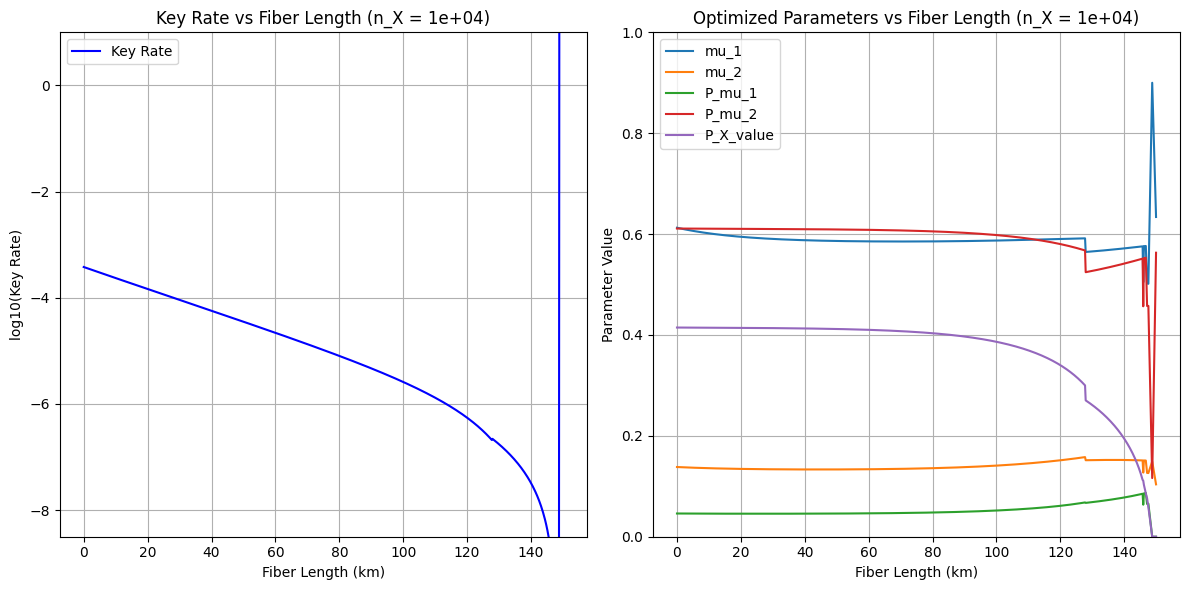


Plotting results for n_X = 1e+05
No data found for n_X = 100000

Plotting results for n_X = 1e+06
No data found for n_X = 1000000

Plotting results for n_X = 1e+07
No data found for n_X = 10000000

Plotting results for n_X = 1e+08
No data found for n_X = 100000000

Plotting results for n_X = 1e+09
No data found for n_X = 1000000000

Plotting results for n_X = 1e+10
No data found for n_X = 10000000000


In [45]:
# Load dataset
# with open("qkd_grouped_dataset_20250213_110036.json", 'r') as f:
#     dataset = json.load(f)
with open("../n_X/good/qkd_grouped_dataset_20250427_145238.json", 'r') as f:
    dataset = json.load(f)

# plot_for_nx(dataset, 500000000)  # Example plot for n_X = 5e8

# Print available n_X values
print("Available n_X values:", list(dataset.keys())[:5])  # Print first 5 unique n_X values

# List of n_X values to plot
n_X_values = [10**s for s in range(4, 11)]  # Generates [10^4, 10^5, ..., 10^9]

# Loop through n_X values and plot
for n_X in n_X_values:
    print(f"\nPlotting results for n_X = {n_X:.0e}")

    plot_for_nx(dataset, n_X)

Available n_X values: ['10000.0', '100000.0', '1000000.0', '10000000.0', '100000000.0', '1000000000.0']


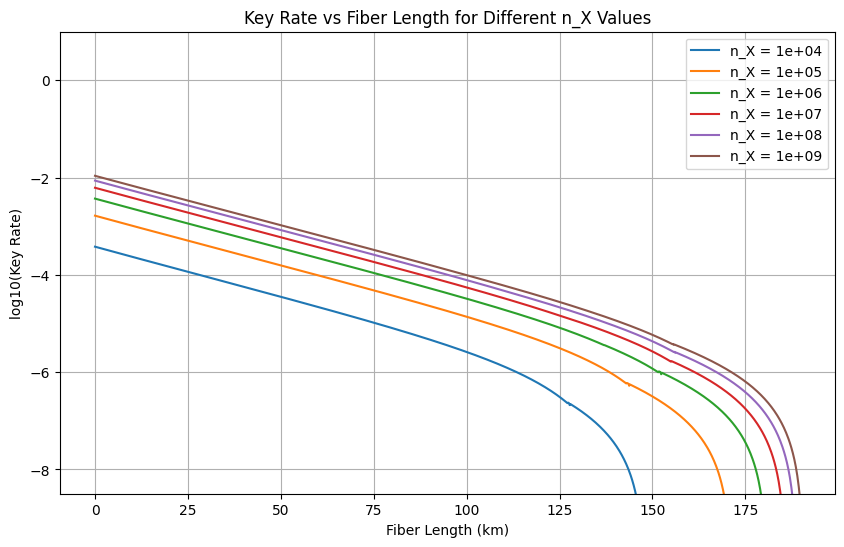

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
with open("../Training_Data/n_X/good/cleaned_combined_datasets.json", 'r') as f:
    dataset = json.load(f)

# Print available keys (debugging)
print("Available n_X values:", list(dataset.keys()))  

# Define n_X values
n_X_values = [10**s for s in range(4, 10)]  # [10^4, 10^5, ..., 10^9]

# Initialize figure
plt.figure(figsize=(10, 6))

# Plot key rate vs fiber length for each n_X
for n_X in n_X_values:
    target_nx_str = str(float(n_X))  # Ensure correct format

    if target_nx_str not in dataset:
        print(f"‚ùå No data found for n_X = {n_X}")
        continue

    filtered_data = dataset[target_nx_str]
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  

    if not filtered_data:
        print(f"‚ö†Ô∏è No non-zero key rates for n_X = {n_X}")
        continue

    # Extract fiber lengths and key rates
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # Plot with unique colors and dashed lines
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', label=f"n_X = {n_X:.0e}")

# Graph formatting
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Key Rate)")
plt.ylim(-8.5, 1.0)
plt.title("Key Rate vs Fiber Length for Different n_X Values")
plt.legend()
plt.grid(True)

# Save and show plot
plt.savefig("..//Training_Data/n_X/good/key_rate_vs_fiber_length.png", dpi=300, bbox_inches="tight")
plt.show()

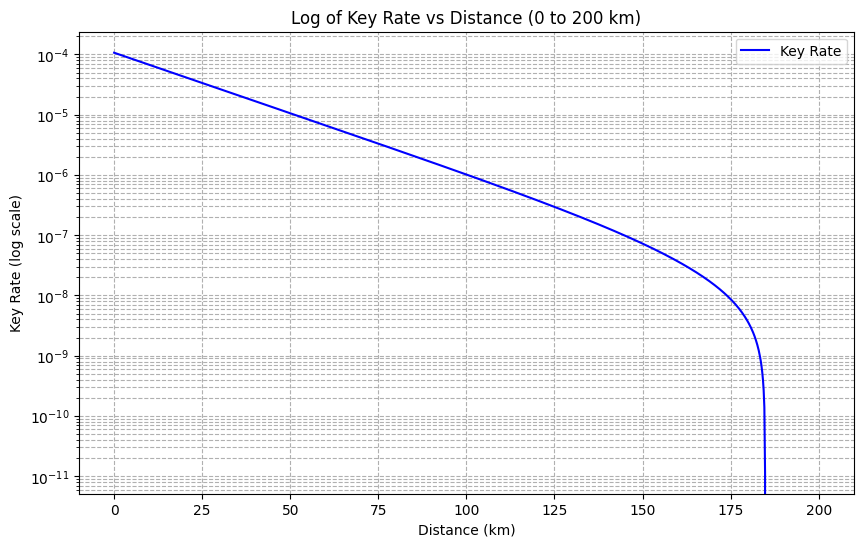

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp  # Assuming JAX is used based on your code

# Your optimal_parameters function
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

# Optimized parameters from your input
optimized_params = {
    "mu_1": 0.34479867337905723,
    "mu_2": 0.19526100517866424,
    "P_mu_1": 0.21504895346866,
    "P_mu_2": 0.4645950203307233,
    "P_X_value": 0.1
}

# Extract params as a tuple for the function
params_tuple = (
    optimized_params["mu_1"],
    optimized_params["mu_2"],
    optimized_params["P_mu_1"],
    optimized_params["P_mu_2"],
    optimized_params["P_X_value"]
)

# Placeholder for the objective function (replace with your actual function)
def another_objective(params_dict, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    # This is a dummy implementation; replace with your actual key rate calculation
    # For now, assume a simple exponential decay model as a placeholder
    params, mu_3, P_mu_3, P_Z_value, mu_k_values = optimal_parameters(params_tuple)
    key_rate = objective(optimized_params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
    return key_rate  # Assuming it returns a tuple with key_rate as first element

# Define distance range
L_values = np.linspace(0, 200, 1000)  # 0 to 200 km, 1000 points

alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


# Calculate key rates for each L value
key_rates = []
for L in L_values:
    key_rate = objective(params_tuple, L, n_X, alpha, eta_Bob, P_dc_value, 
                         epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
    key_rates.append(float(key_rate))  # Convert JAX array to float if needed

# Plotting with logarithmic y-axis
plt.figure(figsize=(10, 6))
plt.semilogy(L_values, key_rates, label='Key Rate', color='blue')  # Use semilogy for log scale
plt.xlabel('Distance (km)')
plt.ylabel('Key Rate (log scale)')
plt.title('Log of Key Rate vs Distance (0 to 200 km)')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.legend()
plt.show()